# A set of scaffolds from CheMBL papers

Been here a few times, keep refining it. :-)

# On to the work

## Start with the preliminaries

We need to do a bunch of imports and define some functions we'll use later.

*Note:* This is a Python3 notebook, so the code below may not work in Python2.

In [1]:
import numpy
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdFMCS as MCS
from rdkit.Chem import Draw
import pickle
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())

2020.09.1
Sun Dec 20 08:43:44 2020


In [2]:
# define a function to convert a query molecule to SVG

from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,250),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    # the MolDraw2D code is not very good at the moment at dealing with atom queries,
    # this is a workaround until that's fixed.
    # The rendering is still not going to be perfect because query bonds are not properly indicated
    opts = drawer.drawOptions()
    for atom in mc.GetAtoms():
        if atom.HasQuery() and atom.DescribeQuery().find('AtomAtomicNum')!=0:
            opts.atomLabels[atom.GetIdx()]=atom.GetSmarts()
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

In [3]:
# define a function to find the MCS for a set of molecules and return some summary info about that MCS

import time
# we will use a namedtuple to return the results
from collections import namedtuple
MCSRes=namedtuple('MCSRes',('smarts','numAtoms','numMols','avgNumMolAtoms','mcsTime'))

def MCS_Report(ms,printSmarts=True,
               atomCompare=MCS.AtomCompare.CompareAny,
               bondCompare=MCS.BondCompare.CompareAny,
               completeRingsOnly=True,
               **kwargs):
    t1=time.time()
    mcs = MCS.FindMCS(ms,atomCompare=atomCompare,bondCompare=bondCompare,timeout=30,completeRingsOnly=completeRingsOnly,
                      **kwargs)
    t2=time.time()
    nAts = numpy.array([x.GetNumAtoms() for x in ms])
    print('Mean nAts %.1f, mcs nAts: %d'%(nAts.mean(),mcs.numAtoms))
    if printSmarts: 
        print(mcs.smartsString)
    mcsM = Chem.MolFromSmarts(mcs.smartsString)         
    mcsM.UpdatePropertyCache(False)
    Chem.SetHybridization(mcsM)
    svg = moltosvg(mcsM,kekulize=False)
    tpl = MCSRes(mcs.smartsString,mcs.numAtoms,len(ms),nAts,t2-t1)
    return tpl,svg


## Grab the datasets data

Get target information from our local ChEMBL copy:

In [5]:
%load_ext sql
%config SqlMagic.feedback = False

In [17]:
d = %sql postgresql://localhost/chembl_26 \
select * from (\
   select assay_id,chembl_id assay_chembl_id,count(distinct(molregno)) cnt,description  \
          from activities join assays using(assay_id) \
          where standard_type = 'Ki' and confidence_score=9 and assay_type='B' and relationship_type='D' \
          group by (assay_id,chembl_id,description) order by cnt desc) tmp \
   where cnt<100 and cnt>50;
print(f'{len(d)} assays found')

367 assays found


In [18]:
d

assay_id,assay_chembl_id,cnt,description
1528353,CHEMBL3706284,98,"Radioligand Binding Assay: HEK293 stably expressing human orexin 2 receptor (Genebank accession numberNM_001526) were grown to confluency in DMEM (Hyclone, cat # SH30022) , 10%FBS, IX Pen/Strep, IX NaPyruvate, 10 mM HEPES, 600 ug/ml G418 media on 150 cm2 tissue culture plates, washed with 5 mM EDTA in PBS (HyClone Dulbecco's Phoshpate Buffered Saline IX with Calcium and Magnesium, Cat # SH30264.01, hereafter referred to simply as PBS) and scraped into 50 ml tubes. After centrifugation (2K xG, 5 min at 4Â°C), the supernatant was aspirated and the pellets frozen and stored at -80Â°C. Cells were resuspended in PBS in the presence of 1 tablet of protease inhibitor cocktail (Roche, Cat. #11836145001) per 50 mL. Each cell pellet from a 15 cm plate was resuspended in 10 mL, stored on ice, and homogenized for 45 sec just prior to addition to the reactions. Competition binding experiments in 96 well polypropylene plates were performed using [3H]-EMPA (Moraveck Corporation, specific activity = 29.6 Ci/mmol)."
1527605,CHEMBL3705289,97,"Binding assay: Binding assay was performed at 4 C. in a final volume of 1 ml, and with an incubation time of 30 min. The radioligand [3H]-rac-2-(1,2,3,4-tetrahydro-1-naphthyl)-2-imidazoline was used at a concentration equal to the calculated Kd value of 60 nM to give a bound at around 0.1% of the total added radioligand concentration, and a specific binding which represented approximately 70-80% of the total binding. Non-specific binding was defined as the amount of [3H]-rac-2-(1,2,3,4-tetrahydro-1-naphthyl)-2-imidazoline bound in the presence of the appropriate unlabelled ligand (10 μM). Competing ligands were tested in a wide range of concentrations (10 μM-30 μM). The final dimethylsulphoxide concentration in the assay was 2%, and it did not affect radioligand binding."
1537148,CHEMBL3734283,97,Inhibition of human GRK2 after 90 to 120 mins by Kinase-Glo assay
1535508,CHEMBL3707832,95,"Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM MgCl2, 1 mM EDTA, 5 mM KCl, 1.5 mM CaCl2, pH=7.4; 5-HT2A: 50 mM Tris-HCl, 10 mM MgCl2, 1 mM EGTA, pH=7.4), homogenized with a Polytron for 20-30 sec at 12.000 rpm and adjusted to a final concentration of approximately 7.5 ug protein/well (D2, D3) and 15 ug protein/well (5-HT2A), respectively.The binding affinity (Ki) of the compounds was determined using radioligand binding. Membranes were incubated in a total volume of 200 ul with a fixed concentration of radioligand (final concentration approximately 0.7 nM [3H]-spiperone for D2, 0.5 nM [3H]-spiperone for D3, and 1.1 nM [3H]-ketanserin for 5-HT2A) and ten concentrations of test compound in ranging between 10 uM-0.1 nM for 1 h at RT. At the end of the incubation, the reaction mixtures were filtered on to unifilter 96-well white microplates with bonded GF/C filters."
1547124,CHEMBL3755859,95,Competitive inhibition of human aromatase extracted from placental microsomes after 5 mins by Dixon plot analysis in presence of [1beta-3H]AD
1528370,CHEMBL3705383,95,"Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM MgCl2, 1 mM EDTA, 5 mM KCl, 1.5 mM CaCl2, pH=7.4; 5-HT2A: 50 mM Tris-HCl, 10 mM MgCl2, 1 mM EGTA, pH=7.4), homogenized with a Polytron for 20-30 sec at 12.000 rpm and adjusted to a final concentration of approximately 7.5 ug protein/well (D2, D3) and 15 ug protein/well (5-HT2A), respectively.The binding affinity (Ki) of the compounds was determined using radioligand binding. Membranes were incubated in a total volume of 200 ul with a fixed concentration of radioligand (final concentration approximately 0.7 nM [3H]-spiperone for D2, 0.5 nM [3H]-spiperone for D3, and 1.1 nM [3H]-ketanserin for 5-HT2A) and ten concentrations of test compound in ranging between 10 u

 * postgresql://localhost/chembl_26


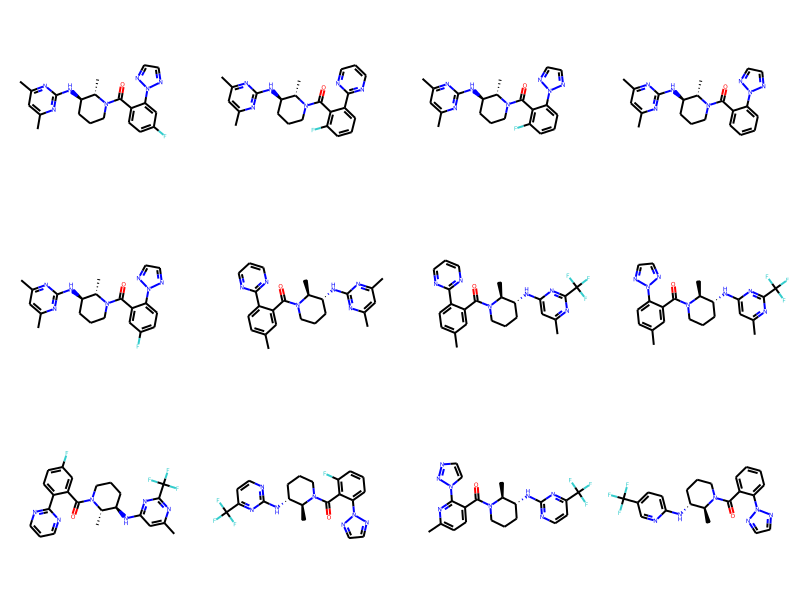

In [14]:
assay_id = 1528353
smis = %sql \
  select chembl_id,m from activities \
  join rdk.mols using (molregno)\
  join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND')\
  where assay_id = :assay_id
ms = [Chem.MolFromSmiles(y) for x,y in smis]
Draw.MolsToGridImage(ms[:12],molsPerRow=4)

Mean nAts 30.7, mcs nAts: 18
[#8,#6,#7,#9]-&!@[#6]1:&@[#6,#7]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@1-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@1-&!@[#6])-&!@[#7,#8]-&!@[#6]


RDKit ERROR: [07:35:34] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:35:34] Aromatic bonds on non aromatic atom 1


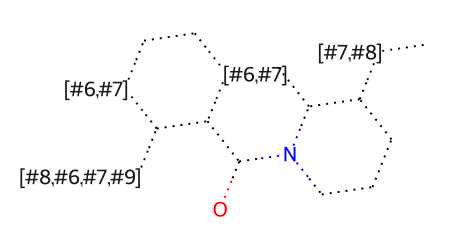

In [15]:
tpl,svg=MCS_Report(ms,threshold=0.9,completeRingsOnly=True)
SVG(svg)

In [19]:
results = []
for row in d:
    assay_id=row[0]
    print(row)   
    smis = %sql \
  select chembl_id,m from activities \
  join rdk.mols using (molregno)\
  join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND')\
  where assay_id = :assay_id
    ms = [Chem.MolFromSmiles(y) for x,y in smis]
    tpl,svg=MCS_Report(ms,threshold=0.9,completeRingsOnly=True)
    results.append((row,smis,tpl,svg))

(1528353, 'CHEMBL3706284', 98, "Radioligand Binding Assay: HEK293 stably expressing human orexin 2 receptor (Genebank accession numberNM_001526) were grown to confluency in DMEM (Hy ... (715 characters truncated) ... petition binding experiments in 96 well polypropylene plates were performed using [3H]-EMPA (Moraveck Corporation, specific activity = 29.6 Ci/mmol).")
 * postgresql://localhost/chembl_26
Mean nAts 30.7, mcs nAts: 18
[#8,#6,#7,#9]-&!@[#6]1:&@[#6,#7]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@1-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@1-&!@[#6])-&!@[#7,#8]-&!@[#6]
(1527605, 'CHEMBL3705289', 97, 'Binding assay: Binding assay was performed at 4 C. in a final volume of 1 ml, and with an incubation time of 30 min. The radioligand [3H]-rac-2-(1,2, ... (483 characters truncated) ... ide range of concentrations (10 μM-30 μM). The final dimethylsulphoxide concentration in the assay was 2%, and it did not affect radioligand binding.')
 * postgresql://localhost/chembl_2

RDKit ERROR: [07:38:30] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:38:30] Aromatic bonds on non aromatic atom 1


Mean nAts 23.8, mcs nAts: 19
[#8]=&!@[#6](-&!@[#6]-&!@[#7,#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#7]=,-;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#7]:&@[#6]:&@[#6]:&@1
(1535508, 'CHEMBL3707832', 95, 'Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM ... (679 characters truncated) ...  for 1 h at RT. At the end of the incubation, the reaction mixtures were filtered on to unifilter 96-well white microplates with bonded GF/C filters.')
 * postgresql://localhost/chembl_26
Mean nAts 32.1, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]2:&@[#6]:&@1:,-;@[#6]:,-;@[#6]:,-;@[#8]:,-;@2
(1547124, 'CHEMBL3755859', 95, 'Competitive inhibition of human aromatase extracted from placental microsomes after 5 mins by Dixon plo

RDKit ERROR: [07:38:36] Aromatic bonds on non aromatic atom 14
RDKit INFO: [07:38:36] Aromatic bonds on non aromatic atom 14


Mean nAts 33.1, mcs nAts: 7
[#6]-&!@[#6,#7]1:&@[#7,#6]:&@[#6,#7]:&@[#8,#6,#7,#16]:&@[#6,#7]:&@1-&!@[#6]
(1528694, 'CHEMBL3705468', 94, 'Radioligand Binding Assay: Radioligand binding assays for cloned muscarinic receptors were performed in 96-well microtiter plates in a total assay vo ... (671 characters truncated) ... centrations ranging from 0.001 nM to 20 nM.Displacement assays for determination of Ki values of test compounds were performed with [3H]-NMS at 1 nM.')
 * postgresql://localhost/chembl_26
Mean nAts 62.4, mcs nAts: 29
[#6]-&!@[#7](-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#8]-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1613478, 'CHEMBL3855278', 93, 'Displacement of [3H]-spiperone from human dopamine D2 receptor expressed in CHO-K1 cell membranes coexpressing Galpha16 after 120 mins by liquid scintillation counting')
 * postgresql://localho

RDKit ERROR: [07:40:10] Aromatic bonds on non aromatic atom 8
RDKit INFO: [07:40:10] Aromatic bonds on non aromatic atom 8


Mean nAts 30.0, mcs nAts: 22
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#6]1:&@[#7]:&@[#6]:&@[#6]:&@[#6](:&@[#7]:&@1)-&!@[#6]1:&@[#6]:&@[#7]:&@[#7]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#7]:&@2
(302524, 'CHEMBL827377', 91, 'Binding affinity for human cyclin-dependent kinase 2')
 * postgresql://localhost/chembl_26
Mean nAts 30.0, mcs nAts: 22
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#6]1:&@[#7]:&@[#6]:&@[#6]:&@[#6](:&@[#7]:&@1)-&!@[#6]1:&@[#6]:&@[#7]:&@[#7]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#7]:&@2
(303563, 'CHEMBL828963', 91, 'Inhibition of [125I]eotaxin-1 binding to human chemokine receptor (hCCR3-C1)')
 * postgresql://localhost/chembl_26
Mean nAts 33.6, mcs nAts: 24
[#6,#7,#8]-&!@[#7,#6]1-,:;@[#6]-,:;@[#6]-,:;@[#7,#6](-,:;@[#6]-,:;@[#6]-,:;@1)-&!@[#6](-&!@[#6]-&!@[#7]-&!@[#6]-&!@[#6,#7]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6]:,-;@[#6]:,-;@1
(213236, 'CHEMBL821446', 88, 'Binding affinity towa

RDKit ERROR: [07:40:13] Aromatic bonds on non aromatic atom 23
RDKit INFO: [07:40:13] Aromatic bonds on non aromatic atom 23


Mean nAts 36.1, mcs nAts: 24
[#7,#8]-,=;!@[#6](=,-;!@[#8,#6,#7])-&!@[#6](-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6](=&!@[#7])-&!@[#7])-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1528352, 'CHEMBL3706283', 88, "Radioligand Binding Assay: Human Embryonic Kidney 293 cells (HEK293) stably expressing rat orexin 1 receptor(Genebank accession number NM_001525) or  ... (710 characters truncated) ... sence of 1 tablet of protease inhibitor cocktail (Roche, Cat. #1 1836145001) per 50 mL. Each cell pellet from a 15 cm plate was resuspended in 10 mL.")
 * postgresql://localhost/chembl_26
Mean nAts 30.6, mcs nAts: 18
[#8,#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@1-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@1-&!@[#6])-&!@[#7,#8]-&!@[#6]
(1537103, 'CHEMBL3734209', 88, 'Displacement of [3H]-PrRP from human GPR10 receptor expressed in HEK293 cell membranes incubated for 90 mins by liquid scintillati

RDKit ERROR: [07:40:47] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:40:47] Aromatic bonds on non aromatic atom 1


Mean nAts 37.5, mcs nAts: 25
[#6]-&!@[#8,#6,#7]-&!@[#7]1:&@[#6](-&!@[#7]-&!@[#6](-&!@[#6])-&!@[#6]2-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@2):&@[#7]:&@[#6]2:&@[#6](:&@[#6]:&@1=&!@[#8])-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6](=,-;!@[#8,#6])-,=;!@[#6,#8]
(1535076, 'CHEMBL3707804', 88, 'Radioligand Binding Assay: liquots of membrane preparations were thawed at RT, resuspended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM ... (691 characters truncated) ...  for 1 h at RT. At the end of the incubation, the reaction mixtures were filtered on to unifilter 96-well white microplates with bonded GF/C filters.')
 * postgresql://localhost/chembl_26
Mean nAts 32.8, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#8]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(1535965, 'CHEMBL3707598', 88, 'Radioligand Binding Assay: liqu

RDKit ERROR: [07:43:13] Aromatic bonds on non aromatic atom 12
RDKit INFO: [07:43:13] Aromatic bonds on non aromatic atom 12


Mean nAts 31.8, mcs nAts: 21
[#8,#6,#16]=,-;!@[#16,#7]-&!@[#7,#6]-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#7]:&@[#16,#8]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(1366807, 'CHEMBL3297242', 82, 'Displacement of [3H]LSD from human recombinant 5-HT7 receptor expressed in CHO-K1 cell membrane after 120 mins by liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:14] Aromatic bonds on non aromatic atom 12
RDKit INFO: [07:43:14] Aromatic bonds on non aromatic atom 12


Mean nAts 31.8, mcs nAts: 21
[#8,#6,#16]=,-;!@[#16,#7]-&!@[#7,#6]-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#7]:&@[#16,#8]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(1366809, 'CHEMBL3297244', 82, 'Displacement of [3H]N-methylspiperone from human recombinant D2 receptor expressed in CHO-K1 cell membrane after 60 mins by liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:15] Aromatic bonds on non aromatic atom 12
RDKit INFO: [07:43:15] Aromatic bonds on non aromatic atom 12


Mean nAts 31.8, mcs nAts: 21
[#8,#6,#16]=,-;!@[#16,#7]-&!@[#7,#6]-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#7]:&@[#16,#8]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(1659425, 'CHEMBL4009037', 81, 'Displacement of [3H]-LSD from recombinant human 5-HT6 receptor expressed in HEK293 cells after 60 mins')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:16] Aromatic bonds on non aromatic atom 12
RDKit INFO: [07:43:16] Aromatic bonds on non aromatic atom 12


Mean nAts 29.7, mcs nAts: 25
[#8]=&!@[#16](=&!@[#8])(-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#7]1:&@[#6,#7]:&@[#6](:&@[#6]2:&@[#6]:&@1:&@[#6,#7]:&@[#6]:&@[#6]:&@[#6,#7]:&@2)-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@1
(418719, 'CHEMBL912951', 80, 'Displacement of [125I]CCK-8S from human CCK2R')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:18] Aromatic bonds on non aromatic atom 9
RDKit INFO: [07:43:18] Aromatic bonds on non aromatic atom 9


Mean nAts 29.5, mcs nAts: 18
[#8,#7]=,-;!@[#6](-&!@[#6]1:,-;@[#6]:,=;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6]:,=;@1-&!@[#7]-&!@[#16,#6](=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-,=;!@[#7,#8]
(981861, 'CHEMBL2427556', 80, 'Binding affinity to human adenosine A3 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:48] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:43:48] Aromatic bonds on non aromatic atom 2


Mean nAts 30.8, mcs nAts: 19
[#6]-&!@[#7]1:&@[#6]:&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7]:&@[#6](:&@[#7]1:&@[#6]:&@2:&@[#7]:&@[#6](:&@[#7]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1)-&!@[#7]
(1535759, 'CHEMBL3707774', 79, 'Radioligand Binding: The binding of [3H]MLA was measured using a modification of the methods of Davies et al., Neuropharmacol. 38: 679 (1999). [3H]ML ... (656 characters truncated) ... er was washed with PBS (3x1 mL) at room temperature. Non-specific binding was determined by inclusion of 50 uM non-radioactive MLA in selected wells.')
 * postgresql://localhost/chembl_26
Mean nAts 17.3, mcs nAts: 15
[#8]=&!@[#6](-&!@[#6]1:&@[#6,#7,#8]:&@[#6,#7,#8]:&@[#7,#6,#8]:&@[#8,#6,#7]:&@1)-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@[#6]-&@1
(429601, 'CHEMBL919033', 79, 'Displacement of [3h]DPCPX from adenosine A receptor in rat cerebral cortex membrane')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:43:49] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:43:49] Aromatic bonds on non aromatic atom 2


Mean nAts 32.5, mcs nAts: 16
[#7]-&!@[#6]1:&@[#7,#6]:&@[#6](-&!@[#7]):&@[#7,#6]:&@[#6]2:&@[#7]:&@1:&@[#7]:&@[#6](:&@[#7]:&@2)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1
(1528657, 'CHEMBL3706132', 79, 'Radioligand Binding: The binding of [3H]MLA was measured using a modification of the methods of Davies et al., Neuropharmacol. 38: 679 (1999). [3H]ML ... (656 characters truncated) ... er was washed with PBS (3x1 mL) at room temperature. Non-specific binding was determined by inclusion of 50 uM non-radioactive MLA in selected wells.')
 * postgresql://localhost/chembl_26
Mean nAts 17.3, mcs nAts: 15
[#8]=&!@[#6](-&!@[#6]1:&@[#6,#7,#8]:&@[#6,#7,#8]:&@[#6,#7,#8]:&@[#8,#6,#7]:&@1)-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@[#6]-&@1
(583010, 'CHEMBL1051848', 79, 'Displacement of [H]GR-113808 from human 5HT4C receptor expressed in HEK293 cells by liquid scintillation counting')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:44:02] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:44:02] Aromatic bonds on non aromatic atom 1
RDKit ERROR: [07:44:02] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:44:02] Aromatic bonds on non aromatic atom 2


Mean nAts 32.3, mcs nAts: 9
[#6]1:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@1-&!@[#6,#7]-&!@[#7,#6,#8]-,=;!@[#6,#7,#8]
(1527942, 'CHEMBL3705629', 79, 'Biochemical Assay: The ability of the compounds to bind to the 5-HT2A, D3 and D2 receptors was determined using radioligand binding to cloned receptors selectively expressed in HEK-293 EBNA cells.')
 * postgresql://localhost/chembl_26
Mean nAts 31.8, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6,#7])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]2:&@[#6]:&@1-&@[#8]-&@[#6]-&@[#8]-&@2
(429600, 'CHEMBL919032', 79, 'Displacement of [3H]ZM241385 from adenosine A2A receptor in rat brain membrane')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:44:02] Aromatic bonds on non aromatic atom 0
RDKit INFO: [07:44:02] Aromatic bonds on non aromatic atom 0


Mean nAts 32.5, mcs nAts: 16
[#7]-&!@[#6]1:&@[#7,#6]:&@[#6](-&!@[#7]):&@[#7,#6]:&@[#6]2:&@[#7]:&@1:&@[#7]:&@[#6](:&@[#7]:&@2)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1
(1535083, 'CHEMBL3707825', 79, 'Biochemical Assay: The ability of the compounds to bind to the 5-HT2A, D3 and D2 receptors was determined using radioligand binding to cloned receptors selectively expressed in HEK-293 EBNA cells.')
 * postgresql://localhost/chembl_26
Mean nAts 31.8, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6,#7])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]2:&@[#6]:&@1-&@[#8]-&@[#6]-&@[#8]-&@2
(1535448, 'CHEMBL3707696', 79, 'Biochemical Assay: The ability of the compounds to bind to the 5-HT2A, D3 and D2 receptors was determined using radioligand binding to cloned receptors selectively expressed in HEK-293 EBNA cells.')
 * postgresql://localhost/chembl_26
Mean nAts 31.8, mcs nAts: 27


RDKit ERROR: [07:44:15] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:44:15] Aromatic bonds on non aromatic atom 1


Mean nAts 33.9, mcs nAts: 21
[#6]1:&@[#7,#6]:&@[#6]:&@[#6,#7]:&@[#6](:&@[#7,#6]:&@1)-&!@[#7]-&!@[#6]1:&@[#7]:&@[#7]:&@[#6]2:&@[#6]:&@1-&@[#6]-&@[#7](-&@[#6]-&@2(-&!@[#6])-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#7,#8]-&!@[#6]
(1637416, 'CHEMBL3880477', 78, 'Displacement of [3H]-2-[4-(3-azidophenyl)-2-oxo-1-pyrrolidinyl]butanamide from SV2A levetiracetam binding site in Sprague-Dawley rat cerebral cortex membranes after 120 mins by liquid scintillation counting method')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:44:45] Aromatic bonds on non aromatic atom 0
RDKit INFO: [07:44:45] Aromatic bonds on non aromatic atom 0


Mean nAts 17.1, mcs nAts: 13
[#6,#7]-&!@[#6]1-&@[#6]-&@[#6](-&@[#7](-&@[#6]-&@1)-&!@[#6](-&!@[#6]-&!@[#6])-&!@[#6](-,=;!@[#7,#8])=,-;!@[#8,#7])=&!@[#8]
(880272, 'CHEMBL2215850', 78, 'Displacement of [125I]-CXCL10 from human CXCR3 expressed in HEK293 cells')
 * postgresql://localhost/chembl_26
Mean nAts 25.1, mcs nAts: 11
[#6,#7]-,=;!@[#7,#6](-&!@[#6,#7]-,=;!@[#6,#8])-&!@[#6,#7]-&!@[#6]1:,-,=;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6]:,-;@1
(1534795, 'CHEMBL3707798', 77, 'Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM ... (546 characters truncated) ...  [3H]-spiperone for D3, and 1.1 nM [3H]-ketanserin for 5-HT2A) and ten concentrations of test compound in ranging between 10 μM-0.1 nM for 1 h at RT.')
 * postgresql://localhost/chembl_26
Mean nAts 31.7, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6,#7])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@

RDKit ERROR: [07:44:47] Aromatic bonds on non aromatic atom 5
RDKit INFO: [07:44:47] Aromatic bonds on non aromatic atom 5


Mean nAts 41.1, mcs nAts: 22
[#6]-&!@[#6](-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6](-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#8])-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#8]-&!@[#6,#15]
(1638064, 'CHEMBL3881125', 77, 'Inhibition of recombinant MCH2 (unknown origin) pre-incubated for 60 mins with Acetyl-Tyr-Val-Ala-Asp-amino-4-methylcoumarin substrate followed by enzyme addition by fluorescence based assay')
 * postgresql://localhost/chembl_26
Mean nAts 41.1, mcs nAts: 22
[#6]-&!@[#6](-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6](-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#8])-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#8]-&!@[#6,#15]
(1638062, 'CHEMBL3881123', 77, 'Inhibition of recombinant CPP32 (unknown origin) pre-incubated for 60 mins with Acetyl-Tyr-Val-Ala-Asp-amino-4-methylcoumarin substrate followed by enzyme addition by fluorescence based assay')
 * postgresql://localhost/chembl_26
Mean nAts 41.1, mcs nAts: 22
[#6]-&!@

RDKit ERROR: [07:45:29] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:45:29] Aromatic bonds on non aromatic atom 2


Mean nAts 38.3, mcs nAts: 29
[#7,#6]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-,:;@1)-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6,#7]:&@[#6]2:&@[#6](:&@[#7,#6]:&@1):&@[#6,#7](=,-;!@[#8,#6]):&@[#7,#6](:&@[#6,#7](:&@[#7,#6]:&@2-,=;!@[#6,#8])=,-;!@[#8,#6])-,=;!@[#6,#8]
(1535789, 'CHEMBL3707837', 77, 'Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM ... (546 characters truncated) ...  [3H]-spiperone for D3, and 1.1 nM [3H]-ketanserin for 5-HT2A) and ten concentrations of test compound in ranging between 10 μM-0.1 nM for 1 h at RT.')
 * postgresql://localhost/chembl_26
Mean nAts 31.7, mcs nAts: 27
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6,#7])-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]2:&@[#6]:&@1-&@[#8]-&@[#6]-&@[#8]-&@2
(855538,

RDKit ERROR: [07:45:59] Aromatic bonds on non aromatic atom 16
RDKit INFO: [07:45:59] Aromatic bonds on non aromatic atom 16


Mean nAts 29.1, mcs nAts: 10
[#6]1-,:;@[#6]-,:;@[#6]-,:;@[#7,#6](-,:;@[#6]-,:;@[#6]-,:;@1)-&!@[#6,#8,#16]-&!@[#6,#7]-&!@[#8,#6,#16]-,=;!@[#6,#7,#8]
(1528852, 'CHEMBL3706025', 77, 'In Vitro Assay: The effectiveness of compounds of the present invention as inhibitors of the coagulation Factors XIa, VIIa, IXa, Xa, XIIa, plasma kal ... (684 characters truncated) ...  absorbance or fluorescence change in the presence of inhibitor is indicative of enzyme inhibition. Such methods are known to one skilled in the art.')
 * postgresql://localhost/chembl_26
Mean nAts 41.7, mcs nAts: 10
[#6,#7,#8]-,=;!@[#8,#6]-&!@[#6]-,=;!@[#7,#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1528054, 'CHEMBL3705361', 77, 'Radioligand Binding Assay: Aliquots of membrane preparations were thawed at RT, resupended in assay buffer (D2, D3: 50 mM Tris-HCl, 120 mM NaCl, 5 mM ... (546 characters truncated) ...  [3H]-spiperone for D3, and 1.1 nM [3H]-ketanserin for 5-HT2A) and ten concentrations of test compound in ra

RDKit ERROR: [07:48:12] Aromatic bonds on non aromatic atom 13
RDKit INFO: [07:48:12] Aromatic bonds on non aromatic atom 13


Mean nAts 32.9, mcs nAts: 11
[#8]=&!@[#6,#16](-&!@[#7,#6]-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7,#6,#8,#17]
(1527780, 'CHEMBL3705314', 74, 'Glucagon SPA Assay: The Glucagon SPA assay is used to determine the ability of test compounds to block the binding of glucagon-cex to the glucagon receptors.')
 * postgresql://localhost/chembl_26
Mean nAts 35.7, mcs nAts: 28
[#6]-&!@[#6](-&!@[#8,#7]-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6](:&@[#6,#7]:&@[#6]:&@1)-&!@[#7,#6]1:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#7,#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6,#7]:&@1)-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]-&!@[#6]-&!@[#6](=,-;!@[#8])-,=;!@[#8]
(1528161, 'CHEMBL3705370', 74, 'Inhibition Assay: Using a 96 well plate (#3915, Costar), a test compound (25 μL), 400 mM Tris-HCl buffer (pH 8.0, 25 μL) and 0.5 mg/mL fluorescence e ... (196 characters truncated) ... cular Devices, Inc.), the reaction rate was measured from the time-course changes at excitation wavelength 320 nm and fluorescen

RDKit ERROR: [07:48:21] Aromatic bonds on non aromatic atom 8
RDKit INFO: [07:48:21] Aromatic bonds on non aromatic atom 8


Mean nAts 40.3, mcs nAts: 33
[#6]-&!@[#6]-&!@[#6,#8]-&!@[#8,#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#6](-&!@[#6]-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#8])-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@[#6](:&@[#7,#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1527622, 'CHEMBL3705079', 74, 'Radioligand Binding Assay: The TAAR1 radioligand 3[H]-(S)-4-[(ethyl-phenyl-amino)-methyl]-4,5-dihydro-oxazol-2-ylamine (described in WO 2008/098857)  ... (254 characters truncated) ... g was defined as the amount of 3[H]-(S)-4-[(ethyl-phenyl-amino)-methyl]-4,5-dihydro-oxazol-2-ylamine bound in the presence of 10 μM unlabeled ligand.')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:48:22] Aromatic bonds on non aromatic atom 21
RDKit INFO: [07:48:22] Aromatic bonds on non aromatic atom 21


Mean nAts 23.9, mcs nAts: 16
[#7]-&!@[#6]1=&@[#7]-&@[#6](-&@[#6]-&@[#8]-&@1)-&!@[#6]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6,#7]:&@[#6]:&@1)-&!@[#7]-&!@[#6]
(371466, 'CHEMBL864183', 74, 'Displacement of [3H]progesterone from Progesterone receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:48:23] Aromatic bonds on non aromatic atom 13
RDKit INFO: [07:48:23] Aromatic bonds on non aromatic atom 13


Mean nAts 21.9, mcs nAts: 13
[#6]-&!@[#6]1=,-;@[#6]-&@[#6](-&!@[#6])(-&!@[#6])-&@[#7]-&@[#6]2:&@[#6]-&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(1528930, 'CHEMBL3705777', 73, 'Radioligand Binding Assay: Radioligand binding assays (screening and dose-displacement) used 0.1 nM [3H]-nociceptin (NEN; 87.7 Ci/mmole) with 10-20 u ... (640 characters truncated) ... quently dried at 50 C. for 2-3 hrs. Fifty L/well scintillation cocktail (BetaScint; Wallac) was added and plates were counted in a Packard Top-Count.')
 * postgresql://localhost/chembl_26
Mean nAts 36.6, mcs nAts: 17
[#7,#6]=,-;!@[#6]1:,-;@[#7]:,-;@[#6]2:&@[#6](:,-;@[#7]:,-;@1-&!@[#6]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(458669, 'CHEMBL942952', 73, 'Displacement of [12]NDPMSH from human MC4R expressed in HEK293 cells')
 * postgresql://localhost/chembl_26
Mean nAts 39.8, mcs nAts: 32
[#6,#8]-,=;!@[#6,#16]-&!@[#7]-&!@[#6]-&!@[#6]1(-&!@[#7]2-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6](=&!@[

RDKit ERROR: [07:49:56] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:49:56] Aromatic bonds on non aromatic atom 1


Mean nAts 20.0, mcs nAts: 15
[#7,#6]-&!@[#6]1=,:;@[#7,#6]-,:;@[#6]-,:;@[#6](-,:;@[#6](=,:;@[#7,#6]-,:;@1)-&!@[#7,#8])-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(320876, 'CHEMBL884801', 73, 'Displacement of [3H]LSD from cloned human 5-hydroxytryptamine 6 receptor expressed in HeLa cells')
 * postgresql://localhost/chembl_26
Mean nAts 25.9, mcs nAts: 14
[#8,#6]=,-;!@[#16](=&!@[#8])(-,=;!@[#6,#8])-&!@[#7]1:&@[#6]:&@[#6](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6]
(1522886, 'CHEMBL3630759', 72, 'Antagonist activity at human TRPV1 heterologously expressed in CHO cells assessed as inhibition of capsaicin-induced activation by FLIPR assay')
 * postgresql://localhost/chembl_26
Mean nAts 35.8, mcs nAts: 29
[#6]-&!@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6,#7]:&@[#6]:&@1-&!@[#17,#6,#7,#8,#9,#16])-&!@[#6](-&!@[#9,#6])(-&!@[#9])-&!@[#9])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@1)-&!@[#9])-&!@[#7]-&!@[#16](-&!@[#6])(=&!@[#8])

RDKit ERROR: [07:50:16] Aromatic bonds on non aromatic atom 11
RDKit INFO: [07:50:16] Aromatic bonds on non aromatic atom 11


Mean nAts 24.4, mcs nAts: 15
[#6,#7]1:&@[#6,#7]:&@[#7,#6](:&@[#7,#6]:&@[#6]:&@1-&!@[#8,#7,#16]-&!@[#6]-&!@[#6]-&!@[#7,#6,#8])-&!@[#6]1-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@1
(1644378, 'CHEMBL3993307', 72, 'Inhibition of human beta factor 12a using fluorogenic substrate Boc-Gln-Gly-Arg-AMC preincubated for 10 mins followed by addition of substrate measured every min for 30 mins')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:50:17] Aromatic bonds on non aromatic atom 4
RDKit INFO: [07:50:17] Aromatic bonds on non aromatic atom 4


Mean nAts 146.3, mcs nAts: 5
[#6,#7]-,=;!@[#6](-,=;!@[#6,#7,#8])-&!@[#6,#7]-&!@[#6,#7]
(54735, 'CHEMBL667186', 72, 'Inhibition constant against binding of Escherichia coli dihydrofolate reductase')
 * postgresql://localhost/chembl_26
Mean nAts 20.2, mcs nAts: 9
[#7,#6]-&!@[#6]1:,-,=;@[#7,#6]:,-,=;@[#6]:,-;@[#6,#7](:,-;@[#6](:,-,=;@[#7,#6]:,-,=;@1)-&!@[#7,#6,#8])-&!@[#6,#8,#35]
(303552, 'CHEMBL828952', 71, 'Inhibitory constant against [3H]methyllycaconitine binding towards Nicotinic acetylcholine receptor alpha-7 of rat brain hippocampus')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:50:47] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:50:47] Aromatic bonds on non aromatic atom 1


Mean nAts 27.1, mcs nAts: 14
[#8,#6,#7]=,-;!@[#6,#16](-&!@[#7,#8]-&!@[#6]1-&@[#6]2-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@1-&!@[#6]-&!@[#6,#7])-&@[#6]-&@[#6]-&@2)-,=;!@[#6,#7,#8]
(570539, 'CHEMBL1026911', 71, 'Displacement of [3H]CP-55940 from human cloned CB2 receptor by filtration assay')
 * postgresql://localhost/chembl_26
Mean nAts 26.5, mcs nAts: 15
[#6]-&!@[#6]-&!@[#6]-&!@[#7]1:&@[#6]:&@[#6](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6](=,-;!@[#8,#6])-,=;!@[#6,#8]
(570538, 'CHEMBL1026910', 71, 'Displacement of [3H]CP-55940 from CB1 receptor in rat brain by filtration assay')
 * postgresql://localhost/chembl_26
Mean nAts 26.5, mcs nAts: 15
[#6]-&!@[#6]-&!@[#6]-&!@[#7]1:&@[#6]:&@[#6](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6](=,-;!@[#8,#6])-,=;!@[#6,#8]
(54926, 'CHEMBL667222', 71, 'Inhibitory activity against Lactobacillus casei dihydrofolate reductase')
 * postgresql://localhost/chembl_26
Mean nAts 20.2, mcs nAts: 15
[#7]-&!@[#6]1:&@[#7]:&@[#6]:&@[#6](:&@[

RDKit ERROR: [07:50:56] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:50:56] Aromatic bonds on non aromatic atom 1


Mean nAts 24.0, mcs nAts: 17
[#7,#6,#8]-&!@[#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#6](:&@[#7]:&@1)=&!@[#8]):&@[#16]:&@[#6]1:&@[#6]:&@2:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#17,#6,#7,#35]
(588709, 'CHEMBL1059318', 70, 'Inhibition of human PIM2 by scintillation counting')
 * postgresql://localhost/chembl_26
Mean nAts 24.0, mcs nAts: 17
[#7,#6,#8]-&!@[#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#6](:&@[#7]:&@1)=&!@[#8]):&@[#16]:&@[#6]1:&@[#6]:&@2:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#17,#6,#7,#35]
(828300, 'CHEMBL2050319', 70, 'Displacement of [3H]histamine from human histamine H4 receptor expressed in HEK cells')
 * postgresql://localhost/chembl_26
Mean nAts 19.7, mcs nAts: 12
[#7,#8]-,=;!@[#6](=,-;!@[#8,#7])-&!@[#6]1:&@[#6,#7]:&@[#6]2:&@[#6](:&@[#7,#6,#8,#16]:&@1):&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@2
(605406, 'CHEMBL1073400', 70, 'Displacement of radioligand from human adenosine A1 receptor expressed in cells by topcount microplate scintillation counting')
 * postgresql://localhost

RDKit ERROR: [07:50:59] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:50:59] Aromatic bonds on non aromatic atom 3


Mean nAts 24.1, mcs nAts: 13
[#8,#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]-&!@[#6]):&@[#7,#6]:&@[#6](:&@[#7]:&@1)-&!@[#7,#6]
(605405, 'CHEMBL1073399', 70, 'Displacement of radioligand from human adenosine A2A receptor expressed in cells by topcount microplate scintillation counting')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:51:05] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:51:05] Aromatic bonds on non aromatic atom 1


Mean nAts 24.1, mcs nAts: 13
[#8,#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]-&!@[#6]):&@[#7,#6]:&@[#6](:&@[#7]:&@1)-&!@[#7,#6]
(596087, 'CHEMBL1040875', 69, 'Displacement of [3H]CP-55940 from human recombinant CB2 receptor expressed in HEK293 cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:51:10] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:51:10] Aromatic bonds on non aromatic atom 1


Mean nAts 25.2, mcs nAts: 14
[#6,#8]-,=;!@[#6](=,-;!@[#8,#6])-&!@[#6]1:&@[#6]:&@[#7](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6]-,=;!@[#6,#8]
(596088, 'CHEMBL1040876', 69, 'Displacement of [3H]CP-55940 from human recombinant CB1 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 25.2, mcs nAts: 14
[#6,#8]-,=;!@[#6](=,-;!@[#8,#6])-&!@[#6]1:&@[#6]:&@[#7](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6]-,=;!@[#6,#8]
(478840, 'CHEMBL925727', 69, 'Displacement of [3H]PGD2 from human CRTH2 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 29.6, mcs nAts: 21
[#6,#8]-&!@[#6]-&!@[#7]1-&@[#6](=&!@[#8])-&@[#6]-&@[#6]2(-&@[#6]-&@1)-&@[#6](=&!@[#8])-&@[#7](-&@[#6]1:&@[#6]-&@2:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#17,#8,#9])-&!@[#6]-&!@[#6]=,-;!@[#8,#6]
(934321, 'CHEMBL2320307', 69, 'Displacement of FITC-AHx-KALETLRRVGDGVQRNHETAF-NH2 from human MCl1 (172 to 327) expressed in Escherichia coli BL21 (DE3) after 1 h

RDKit ERROR: [07:52:23] Aromatic bonds on non aromatic atom 7
RDKit INFO: [07:52:23] Aromatic bonds on non aromatic atom 7


Mean nAts 31.5, mcs nAts: 25
[#6]-&!@[#6]1:&@[#6]:&@[#6](-&!@[#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#7,#6,#8]):&@[#7]:&@[#6](:&@[#6]:&@1)-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6,#7,#16](=,-;!@[#7,#6,#8])-,=;!@[#7,#6,#8]
(877370, 'CHEMBL2182415', 68, 'Displacement of [3H]epibatidine form human alpha7 nAchR expressed in HEK293 cells')
 * postgresql://localhost/chembl_26
Mean nAts 26.2, mcs nAts: 19
[#8,#6]=,-;!@[#6](-&!@[#7]-&!@[#6]1-&@[#6]2-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@1-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#7]:&@[#6]:&@1)-&@[#6]-&@[#6]-&@2)-,=;!@[#6,#8]
(540740, 'CHEMBL1030622', 68, 'Displacement of [125I]nociceptin from human NOP expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 35.2, mcs nAts: 20
[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#7](-&@[#6]2(-&@[#6]-&@1=&!@[#8])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1572912, 'CHEMBL3801235', 68, 'Antagonist activity at C

RDKit ERROR: [07:53:11] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:53:11] Aromatic bonds on non aromatic atom 2


Mean nAts 38.2, mcs nAts: 29
[#7,#6]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-,:;@1)-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6,#7]:&@[#6]2:&@[#6](:&@[#7,#6]:&@1):&@[#6,#7](=,-;!@[#8,#6]):&@[#7,#6](:&@[#6,#7](:&@[#7,#6]:&@2-,=;!@[#6,#8])=,-;!@[#8,#6])-,=;!@[#6,#8]
(960514, 'CHEMBL2389489', 67, 'Antagonist activity at human TRPV1 expressed in CHOK1 cells assessed as inhibition of capsaicin-induced activity by FLIPR assay')
 * postgresql://localhost/chembl_26
Mean nAts 36.0, mcs nAts: 30
[#6]-&!@[#8]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6](-&!@[#9])(-&!@[#9])-&!@[#9]):&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#6]-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6](-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@1)-&!@[#9])-&!@[#7]-&!@[#16](-&!@[#6])(=&!@[#8])=&!@[#8]
(540741, 'CHEMBL1030623', 67, 'Displacement of [125I]diprenorphine from human DOP expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:53:41] Aromatic bonds on non aromatic atom 16
RDKit INFO: [07:53:41] Aromatic bonds on non aromatic atom 16


Mean nAts 35.2, mcs nAts: 20
[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#7](-&@[#6]2(-&@[#6]-&@1=&!@[#8])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(461138, 'CHEMBL944161', 67, 'Displacement of [3H]raclopride from rat dopamine D2 receptor')
 * postgresql://localhost/chembl_26
Mean nAts 22.7, mcs nAts: 11
[#6,#8]-,=;!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6]2:&@[#6](:,-;@[#6]:,-;@1)-,:;@[#6]:,-;@[#6,#7]-,:;@[#6,#7]-,:;@[#6]-,:;@2
(479714, 'CHEMBL921474', 67, 'Binding affinity at human adenosine A1 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:54:25] Aromatic bonds on non aromatic atom 6
RDKit INFO: [07:54:25] Aromatic bonds on non aromatic atom 6


Mean nAts 23.8, mcs nAts: 17
[#7,#6,#8,#16]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6,#7]2:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#8,#7,#16]:&@2):&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7](:&@[#7,#6]:&@[#6,#7]:&@2)-&!@[#6]-,=;!@[#6,#7,#8]
(159136, 'CHEMBL769512', 67, 'Inhibitory activity against HIV-1 protease')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:54:27] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:54:27] Aromatic bonds on non aromatic atom 1


Mean nAts 38.4, mcs nAts: 28
[#6]-&!@[#6]-&!@[#7]1-&@[#6](=&!@[#8])-&@[#7](-&!@[#6]-&!@[#6])-&@[#6](-&@[#6](-&@[#6](-&@[#6]-&@1-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#8])-&!@[#8])-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(540742, 'CHEMBL1030624', 67, 'Displacement of [125I]diprenorphine from human KOP expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 35.2, mcs nAts: 20
[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#7](-&@[#6]2(-&@[#6]-&@1=&!@[#8])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1653671, 'CHEMBL4003037', 67, "Inhibition of 5'--FAM-LTFEHYWAQLTS peptide binding to N-terminal domain human MDM2 (1 to 118 residues) expressed in Escherichia coli BL21(DE3) measured after 15 mins by fluorescence polarization assay")
 * postgresql://localhost/chembl_26
Mean nAts 40.2, mcs nAts: 22
[#6]-&!@[#7]-&!@[#6](-&!@[#6]1:&@[#6](-&!@[#6](=,-;!@[#8])-,=;!@[#8]):&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@

RDKit ERROR: [07:55:03] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:55:03] Aromatic bonds on non aromatic atom 1


Mean nAts 35.2, mcs nAts: 20
[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#7](-&@[#6]2(-&@[#6]-&@1=&!@[#8])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@2)-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1527882, 'CHEMBL3705126', 66, 'Biological Assay: Compound affinity for the rat 5-HT7 receptor subtype was evaluated by competitive radioligand binding assay using 5-carboxamido[H3]typtamine ([3H]5-CT)(Amersham Biosciences) detection.')
 * postgresql://localhost/chembl_26
Mean nAts 20.6, mcs nAts: 12
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1528915, 'CHEMBL3705621', 66, 'Binding Assay: Receptor binding was performed using membrane fractions prepared from the HEK-293 cell line recombinantly expressing rat 5-HT7 recepto ... (301 characters truncated) ... he assay was performed on the HEK-293 cell line stably transfected with r5-HT7 receptor. Cells were pre-incubated with test compounds for 10 minutes.')
 * postgresql://localhost/chembl_26
Mean 

RDKit ERROR: [07:55:17] Aromatic bonds on non aromatic atom 1
RDKit INFO: [07:55:17] Aromatic bonds on non aromatic atom 1


Mean nAts 36.2, mcs nAts: 28
[#16,#6](-&!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6,#7,#8]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@1)-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]2-&@[#6](-&@[#6]-&@1)(-&@[#6]-&@[#6]1:&@[#6](-&@[#6]=&@2):&@[#7](:&@[#7]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#9])-&!@[#6]
(1653672, 'CHEMBL4003038', 66, "Inhibition of 5'--FAM-LTFEHYWAQLTS peptide binding to N-terminal domain human MDMX (1 to 134 residues) measured after 15 mins by fluorescence polarization assay")
 * postgresql://localhost/chembl_26
Mean nAts 40.2, mcs nAts: 22
[#6]-&!@[#7]-&!@[#6](-&!@[#6]1:&@[#6](-&!@[#6](=,-;!@[#8])-,=;!@[#8]):&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#17])-&!@[#6]1:&@[#7]:&@[#7]:&@[#7]:&@[#7]:&@1-&!@[#6]
(1577550, 'CHEMBL3807026', 66, 'Inhibition of human liver cathepsin B using Cbz-Arg-Arg-pNA as substrate at pH 6 incubated for 30 mins measured for 20 mins by photometrical analysis')
 * postgresql://localhost/chembl_26
Mean nAts 25.8, mcs nAts: 12
[#6,#8

RDKit ERROR: [07:56:20] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:56:20] Aromatic bonds on non aromatic atom 2


Mean nAts 24.4, mcs nAts: 16
[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#7,#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]
(429507, 'CHEMBL918630', 65, 'Inhibition of human BChE')
 * postgresql://localhost/chembl_26
Mean nAts 16.1, mcs nAts: 11
[#8]=&!@[#6]1-&@[#7,#6]-&@[#6]2:&@[#6](-&@[#6,#7]-&@1=,-;!@[#8,#6,#17]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(429506, 'CHEMBL918629', 65, 'Inhibition of human AChE')
 * postgresql://localhost/chembl_26
Mean nAts 16.1, mcs nAts: 11
[#8]=&!@[#6]1-&@[#7,#6]-&@[#6]2:&@[#6](-&@[#6,#7]-&@1=,-;!@[#8,#6,#17]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(429504, 'CHEMBL918627', 65, 'Inhibition of human liver CE1 expressed in sf21 cells')
 * postgresql://localhost/chembl_26
Mean nAts 16.1, mcs nAts: 11
[#8]=&!@[#6]1-&@[#7,#6]-&@[#6]2:&@[#6](-&@[#6,#7]-&@1=,-;!@[#8,#6,#17]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(425700, 'CHEMBL913682', 65, 'Displacement of [3H]spiperone from human dopamine D4.4 expressed in CHO cell membrane')
 * postgr

RDKit ERROR: [07:56:20] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:56:20] Aromatic bonds on non aromatic atom 3
RDKit ERROR: [07:56:21] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:56:21] Aromatic bonds on non aromatic atom 3
RDKit ERROR: [07:56:21] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:56:21] Aromatic bonds on non aromatic atom 3


Mean nAts 30.1, mcs nAts: 14
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]
(425699, 'CHEMBL912015', 65, 'Displacement of [3H]spiperone from human dopamine D3 expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 30.1, mcs nAts: 14
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]
(511514, 'CHEMBL980957', 65, 'Displacement of [3H]PK11195 from translocator protein in rat kidney mitochondrial membrane')
 * postgresql://localhost/chembl_26
Mean nAts 29.2, mcs nAts: 23
[#6]-&!@[#6]-&!@[#7](-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2):&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(302753, 'CHEMBL838700', 65, 'Binding affinity against mu opioid receptor in mouse hot plate test')
 * postgresql://localhost/chembl_26
Mean nAts 33.6, mcs nAts: 23
[#6]-&!@[#6]-&

RDKit ERROR: [07:56:47] Aromatic bonds on non aromatic atom 4
RDKit INFO: [07:56:47] Aromatic bonds on non aromatic atom 4


Mean nAts 41.8, mcs nAts: 29
[#6]-&!@[#6]1:&@[#6]:&@[#6](-&!@[#8]-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#6]2:&@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#16](-,=;!@[#6,#8])(=&!@[#8])=,-;!@[#8,#6]):&@[#7]:&@[#6]3:&@[#6]:&@2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@3):&@[#6]:&@[#6](:&@[#6]:&@1-&!@[#17])-&!@[#6]
(1452896, 'CHEMBL3366212', 64, 'Displacement of [3H]NECA from human adenosine A2A receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 26.6, mcs nAts: 18
[#6,#8]-,=;!@[#7,#6,#8]-&!@[#6,#7]-&!@[#6]1:,=;@[#6,#7]:,-;@[#7,#6]:,=;@[#6](:,-;@[#7,#6]2:,-;@[#6,#7]:,-;@1:,=;@[#7,#6]:,-;@[#6](:,=;@[#7,#6]:,-;@2)-&!@[#6]1:,=;@[#6]:,-;@[#6]:,=;@[#6]:,-;@[#8,#6]:,-;@1)-&!@[#7,#6,#16]
(1452898, 'CHEMBL3366214', 64, 'Antagonist activity at human adenosine A2B receptor expressed in CHO cells assessed as inhibition of NECA-stimulated adenylyl cyclase activity')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:57:06] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:57:06] Aromatic bonds on non aromatic atom 3


Mean nAts 26.6, mcs nAts: 18
[#6,#8]-,=;!@[#7,#6,#8]-&!@[#6,#7]-&!@[#6]1:,=;@[#6,#7]:,-;@[#7,#6]:,=;@[#6](:,-;@[#7,#6]2:,-;@[#6,#7]:,-;@1:,=;@[#7,#6]:,-;@[#6](:,=;@[#7,#6]:,-;@2)-&!@[#6]1:,=;@[#6]:,-;@[#6]:,=;@[#6]:,-;@[#8,#6]:,-;@1)-&!@[#7,#6,#16]
(1452895, 'CHEMBL3366211', 64, 'Displacement of [3H]CCPA from human adenosine A1 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:57:06] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:57:06] Aromatic bonds on non aromatic atom 3


Mean nAts 26.6, mcs nAts: 18
[#6,#8]-,=;!@[#7,#6,#8]-&!@[#6,#7]-&!@[#6]1:,=;@[#6,#7]:,-;@[#7,#6]:,=;@[#6](:,-;@[#7,#6]2:,-;@[#6,#7]:,-;@1:,=;@[#7,#6]:,-;@[#6](:,=;@[#7,#6]:,-;@2)-&!@[#6]1:,=;@[#6]:,-;@[#6]:,=;@[#6]:,-;@[#8,#6]:,-;@1)-&!@[#7,#6,#16]
(1452897, 'CHEMBL3366213', 64, 'Displacement of [3H]NECA from human adenosine A3 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:57:06] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:57:06] Aromatic bonds on non aromatic atom 3


Mean nAts 26.6, mcs nAts: 18
[#6,#8]-,=;!@[#7,#6,#8]-&!@[#6,#7]-&!@[#6]1:,=;@[#6,#7]:,-;@[#7,#6]:,=;@[#6](:,-;@[#7,#6]2:,-;@[#6,#7]:,-;@1:,=;@[#7,#6]:,-;@[#6](:,=;@[#7,#6]:,-;@2)-&!@[#6]1:,=;@[#6]:,-;@[#6]:,=;@[#6]:,-;@[#8,#6]:,-;@1)-&!@[#7,#6,#16]
(1528243, 'CHEMBL3706217', 64, 'Radioligand Binding Assay: HEK293 cells stably expressing human CB2 receptors were grown until a confluent monolayer was formed. Briefly, the cells w ... (714 characters truncated) ...  fatty acid free BSA, pH 7.4). After 90 min incubation at 30 C., binding reaction was terminated by the addition of 300 uL/well of cold assay buffer.')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:57:06] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:57:06] Aromatic bonds on non aromatic atom 3


Mean nAts 33.8, mcs nAts: 25
[#6]-&!@[#6]-&!@[#7]1:&@[#7]:&@[#6](:&@[#16,#6]:&@[#6]:&@1=&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6](-&!@[#6]-,#;!@[#9,#7]):&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#8,#7]-,=;!@[#7]-,=;!@[#6])-&!@[#6](-&!@[#6])(-&!@[#6])-&!@[#6]
(393314, 'CHEMBL911524', 63, 'Displacement of [3H]methylspiperone from dopamine D2 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:57:16] Aromatic bonds on non aromatic atom 2
RDKit INFO: [07:57:16] Aromatic bonds on non aromatic atom 2


Mean nAts 35.3, mcs nAts: 22
[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1=&@[#7]-&@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2-&@[#7]-&@[#6]2:&@[#6]-&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(685143, 'CHEMBL1286959', 63, 'Inhibition of human NOX4 overexpressed in human PMN cell membrane assessed as ROS production by cell free assay in presence of NADPH')
 * postgresql://localhost/chembl_26
Mean nAts 28.4, mcs nAts: 14
[#6]-&!@[#6]1:&@[#6]2:&@[#6](=&!@[#8]):&@[#7](:&@[#7]:&@[#6]:&@2:&@[#6]:&@[#6](:&@[#7]:&@1-&!@[#6,#7])=&!@[#8])-&!@[#6]
(728369, 'CHEMBL1685145', 63, 'Displacement of [3H]Lu AE93103 from human NK3 receptor expressed in BHK cells')
 * postgresql://localhost/chembl_26
Mean nAts 39.6, mcs nAts: 24
[#6]-&!@[#7](-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6](=&!@[#8])-&!@[#6]1(-&!@[#6])-&@[#6]-&@[#6]-&@1-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6](-&@[#6]-&@[#6]-&@1)-&!@[#16,#6,#7]=,-;!@[#8,#6,#16]
(425703, 'CHEMBL913685', 63, 'Binding affinity to

RDKit ERROR: [07:59:05] Aromatic bonds on non aromatic atom 11
RDKit INFO: [07:59:05] Aromatic bonds on non aromatic atom 11


Mean nAts 24.7, mcs nAts: 12
[#7]=,-;!@[#6](-,=;!@[#7,#8])-&!@[#6]1:&@[#6]:&@[#6,#7]:,-;@[#6,#7,#8]:,-,=;@[#16,#6,#7,#8]:,-,=;@[#6,#7,#8,#16]:,-;@[#6,#7,#8,#16]:,-;@[#6,#7]:&@[#6,#16]:&@1
(333106, 'CHEMBL853597', 62, 'Inhibition of FKBP12 rotamase activity')
 * postgresql://localhost/chembl_26


RDKit ERROR: [07:59:06] Aromatic bonds on non aromatic atom 3
RDKit INFO: [07:59:06] Aromatic bonds on non aromatic atom 3


Mean nAts 34.7, mcs nAts: 21
[#6]1:&@[#6]:&@[#6]:&@[#6]2:&@[#6](:&@[#6]:&@1)-&@[#6]-&@[#6]-&@[#7]1-&@[#6]-&@2-&@[#6]2-&@[#6]-&@[#6]-&@[#6]-&@[#6](-&@[#7]-&@2-&!@[#16,#6](=,-;!@[#8,#6])-,=;!@[#7,#6,#8])-&@[#6]-&@1=&!@[#8]
(1561631, 'CHEMBL3776608', 62, 'Displacement of [3H]-spiperone from human dopamine D2 receptor expressed in CHO-K1 cell membranes after 120 mins by liquid scintillation counter method')
 * postgresql://localhost/chembl_26
Mean nAts 33.1, mcs nAts: 25
[#6]-&!@[#7]1:&@[#6](-&!@[#16]-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#7]2-&@[#6]-&@[#6]3-&@[#6](-&@[#6]-&@2)-&@[#7](-&@[#6]-&@[#6]-&@3)-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2):&@[#7]:&@[#7]:&@[#6]:&@1-&!@[#6,#7]
(664672, 'CHEMBL1260558', 62, 'Displacement of [3H]-Spiperone from human dopamine D2L receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 31.5, mcs nAts: 21
[#6,#8]1:,-;@[#6,#8]:,-;@[#6,#8]:,-;@[#6]2:&@[#6](:,-;@[#6]:,-;@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@

RDKit ERROR: [08:00:10] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:00:10] Aromatic bonds on non aromatic atom 5


Mean nAts 31.5, mcs nAts: 21
[#6,#8]1:,-;@[#6,#8]:,-;@[#6,#8]:,-;@[#6]2:&@[#6](:,-;@[#6]:,-;@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#8,#6]-&!@[#6,#8]
(302621, 'CHEMBL838818', 62, 'Binding affinity determined against human alpha thrombin')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:00:18] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:00:18] Aromatic bonds on non aromatic atom 5


Mean nAts 39.8, mcs nAts: 16
[#7,#6,#8]-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#6]-&@1-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6](-&!@[#6]=,-;!@[#8,#6])-&!@[#6]
(878513, 'CHEMBL2188178', 62, 'Displacement of [3H]NECA from human adenosine A3 receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 25.3, mcs nAts: 20
[#6,#8]-&!@[#7,#8]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#7]:&@[#7](:&@[#6]:&@[#6]:&@2:&@[#6]2:&@[#7]:&@1:&@[#7]:&@[#6](:&@[#7]:&@2)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1)-&!@[#6]
(878514, 'CHEMBL2188179', 62, 'Displacement of [3H]NECA from human adenosine A2A receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 25.3, mcs nAts: 20
[#6,#8]-&!@[#7,#8]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#7]:&@[#7](:&@[#6]:&@[#6]:&@2:&@[#6]2:&@[#7]:&@1:&@[#7]:&@[#6](:&@[#7]:&@2)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1)-&!@[#6]
(878515, 'CHEMBL2188180', 62, 'Displacement of [3H]CCPA from human adenosine A1 receptor expressed in CHO cel

RDKit ERROR: [08:00:54] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:00:54] Aromatic bonds on non aromatic atom 1


Mean nAts 29.3, mcs nAts: 21
[#6,#16]-&!@[#16,#6,#7,#8]-&!@[#6]1:&@[#7,#6]:&@[#6,#7]:&@[#6]:&@[#6](:&@[#7,#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]2:&@[#6](:&@[#6]:&@1):&@[#16]:&@[#6](:&@[#7]:&@2)-&!@[#7]-&!@[#6](-&!@[#6])=&!@[#8]
(664675, 'CHEMBL1260561', 61, 'Binding affinity to human 5HT1A receptor expressed in HeLa cells by scintillation proximity assay')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:01:02] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:01:02] Aromatic bonds on non aromatic atom 2


Mean nAts 31.5, mcs nAts: 21
[#6,#8]1:,-;@[#6,#8]:,-;@[#6,#8]:,-;@[#6]2:&@[#6](:,-;@[#6]:,-;@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#8,#6]-&!@[#6,#8]
(464863, 'CHEMBL930580', 60, 'Binding affinity at rat recombinant histamine H3 receptor in rat cortical membranes')
 * postgresql://localhost/chembl_26
Mean nAts 15.9, mcs nAts: 8
[#6,#8]1:,-;@[#6,#7]:,-;@[#16,#6,#7]:,-;@[#6,#7](:,-;@[#6,#7]:,-;@1)-&!@[#6]-&!@[#6]-&!@[#7,#6]


RDKit ERROR: [08:01:06] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:01:06] Aromatic bonds on non aromatic atom 5


(635026, 'CHEMBL1118577', 60, 'Displacement of [125I] Tyr-o-CRF from human CRF[125I]receptor expressed in human IMR-3[125I]cells after 100 mins')
 * postgresql://localhost/chembl_26
Mean nAts 32.8, mcs nAts: 24
[#7]-&!@[#6]-&!@[#6]1:&@[#6](-&!@[#6](-&!@[#9])(-&!@[#9])-&!@[#9]):&@[#7]:&@[#6]2:&@[#7]:&@1:&@[#6]:&@[#6](:&@[#7]:&@2-&!@[#6]1:&@[#6](-&!@[#6]):&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1-&!@[#6,#17])-&!@[#6])-&!@[#17]
(635521, 'CHEMBL1118104', 60, 'Displacement of [3H]LSD form human recombinant 5HT6 receptor')
 * postgresql://localhost/chembl_26
Mean nAts 25.4, mcs nAts: 16
[#7,#6]-,=;!@[#6]-&!@[#6]1-&@[#6]-&@[#6]-&@[#6]-&@[#6]2:&@[#6]-&@1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#16](=,-;!@[#8,#6])(=&!@[#8])-,=;!@[#6,#8]
(641177, 'CHEMBL1174684', 60, 'Displacement of [3H](+)-pentazocine from sigma 1 receptor in guinea pig brain membrane')
 * postgresql://localhost/chembl_26
Mean nAts 25.1, mcs nAts: 9
[#6,#7,#8]-,=,#;!@[#6,#7,#8]-&!@[#6]-&!@[#7,#6]1-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@[#6]-,:;@

RDKit ERROR: [08:02:35] Aromatic bonds on non aromatic atom 11
RDKit INFO: [08:02:35] Aromatic bonds on non aromatic atom 11


Mean nAts 15.9, mcs nAts: 8
[#6,#8]1:,-;@[#6,#7]:,-;@[#16,#6,#7]:,-;@[#6,#7](:,-;@[#6,#7]:,-;@1)-&!@[#6]-&!@[#6]-&!@[#7,#6]
(856937, 'CHEMBL2160580', 60, 'Inhibition of human thrombin using fluorogenic Cbz-Gly-Gly-Arg-NH-Mec as substrate measured over 400 secs by spectrophotometry')
 * postgresql://localhost/chembl_26
Mean nAts 33.5, mcs nAts: 11
[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#7]-&!@[#6]
(325793, 'CHEMBL862699', 60, 'Inhibitory constant against human cathepsin B using Boc-Leu-Lys-Arg-AMC substrate')
 * postgresql://localhost/chembl_26
Mean nAts 29.9, mcs nAts: 14
[#6,#7](-&!@[#7,#6]-&!@[#6]-&!@[#8,#6,#7]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]-&!@[#7,#6]-,#;!@[#6,#7]
(325794, 'CHEMBL862700', 60, 'Inhibitory constant against human cathepsin L using Z-Phe-Arg-AMC substrate')
 * postgresql://localhost/chembl_26
Mean nAts 29.9, mcs nAts: 14
[#6,#7](-&!@[#7,#6]-&!@[#6]-&!@[#8,#6,#7]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[

RDKit ERROR: [08:02:36] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:02:36] Aromatic bonds on non aromatic atom 3


Mean nAts 27.8, mcs nAts: 18
[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](=&@[#6](-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#8]-&!@[#6]-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(936415, 'CHEMBL2317408', 60, 'Displacement of [3H]NMS from human M1 muscarinic receptor expressed in CHO-K1 cells')
 * postgresql://localhost/chembl_26
Mean nAts 27.8, mcs nAts: 18
[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6](=&@[#6](-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#8]-&!@[#6]-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(325795, 'CHEMBL862701', 60, 'Inhibitory constant against human cathepsin S using Z-Val-Val-Arg-AMC substrate')
 * postgresql://localhost/chembl_26
Mean nAts 29.9, mcs nAts: 14
[#6,#7](-&!@[#7,#6]-&!@[#6]-&!@[#8,#6,#7]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]-&!@[#7,#6]-,#;!@[#6,#7]
(425772, 'CHEMBL855762', 60, 'Binding affinity to human CCR8 expressed in L1.2 cells by FMAT assay')
 * postgresql://localhost/chembl_26
Mean nAts 34.0, mcs nAts: 20
[#7,#6,#8]-,=;!@[#16,

RDKit ERROR: [08:02:48] Aromatic bonds on non aromatic atom 19
RDKit INFO: [08:02:48] Aromatic bonds on non aromatic atom 19


Mean nAts 36.7, mcs nAts: 20
[#6]-&!@[#6,#7]1:&@[#7]:&@[#6](:&@[#7]:&@[#8,#7]:&@1)-&!@[#6]1:&@[#6](-&!@[#9]):&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@[#6]:&@1)-&!@[#17]
(364154, 'CHEMBL870844', 60, 'Displacement of [3H]ZM241385 from human adenosine A2b receptor expressed in HEK cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:03:19] Aromatic bonds on non aromatic atom 18
RDKit INFO: [08:03:19] Aromatic bonds on non aromatic atom 18


Mean nAts 29.9, mcs nAts: 20
[#6]-&!@[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#7]:&@[#6](:&@[#7]:&@[#6]:&@2:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]-&!@[#6])-&!@[#6,#7]1-,:;@[#6]-,:;@[#6,#7]-,:;@[#6,#7]-,:;@[#6,#7]-,:;@1
(982934, 'CHEMBL2429574', 59, 'Displacement of [3H]PSB-13253 from human recombinant GPR35 exprssed in CHO cells by liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26
Mean nAts 24.8, mcs nAts: 9
[#8,#6,#7]=,-;!@[#6,#7,#8,#16]-&!@[#6]1:&@[#6]:&@[#6](=,-;!@[#8,#6,#7,#9,#17,#35]):&@[#6]:&@[#6]:&@[#7,#6,#8]:&@1
(1342913, 'CHEMBL3259188', 59, 'Competitive reversible inhibition of porcine pancreatic kallikrein using alpha-N-benzoyl-DL-arginine-p-nitroanilide hydrochloride as substrate after 15 to 180 mins by Michaelis-Menten plot analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:03:20] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:03:20] Aromatic bonds on non aromatic atom 2


Mean nAts 24.4, mcs nAts: 11
[#7,#6]=,-;!@[#6,#7]-,=;!@[#6]1:,-;@[#6,#7]:,=;@[#6,#7]:,-;@[#6,#7,#8]:,-,=;@[#16,#6,#7,#8]:,-,=;@[#6,#7,#8,#16]:,-;@[#6,#7,#8,#16]:,-;@[#6,#7]:&@[#6,#7,#16]:,-;@1
(448200, 'CHEMBL898460', 59, 'Displacement of [125I]His5,D-Tyr6]GnRH from human cloned GnRH receptor transfected in COS7 cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:03:21] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:03:21] Aromatic bonds on non aromatic atom 2


Mean nAts 40.9, mcs nAts: 22
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]-&!@[#6]1:&@[#6](-&!@[#9]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#9,#6])-&@[#6]-&@[#7,#6]-&@[#6,#7]-&@[#6]-&@2
(397859, 'CHEMBL856320', 59, 'Displacement of [125I]NDP-MSH from human MC4R stably expressed in HEK293 cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:03:41] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:03:41] Aromatic bonds on non aromatic atom 1


Mean nAts 33.6, mcs nAts: 23
[#6]-&!@[#6](-&!@[#6])-&!@[#6]-&!@[#6](-&!@[#7])-&!@[#6]1:&@[#6]:&@[#6](-&!@[#6,#9,#17]):&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#6,#7,#8,#16]
(1437207, 'CHEMBL3382981', 59, 'Displacement of [3H]-(+)-pentazocine from sigma-1 receptor in Dunkin Hartley guinea pig brain membranes after 180 mins by liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26
Mean nAts 24.4, mcs nAts: 17
[#6]1:&@[#6]:&@[#6](-&!@[#8]-&!@[#6]-&!@[#6]-,=;!@[#6,#8]-&!@[#7,#6]):&@[#7]:&@[#6](:&@[#7]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1278707, 'CHEMBL3096081', 59, 'Displacement of [3H]PSB-603 from human adenosine A2B receptor')
 * postgresql://localhost/chembl_26
Mean nAts 28.6, mcs nAts: 18
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]):&@[#7]:&@[#6]1:&@[#7]:&@2-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6]
(1278706, 'CHEMBL3096080', 59, 'Displacement of

RDKit ERROR: [08:04:16] Aromatic bonds on non aromatic atom 21
RDKit INFO: [08:04:16] Aromatic bonds on non aromatic atom 21


Mean nAts 28.6, mcs nAts: 18
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]):&@[#7]:&@[#6]1:&@[#7]:&@2-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6]
(1278708, 'CHEMBL3096082', 59, 'Displacement of [3H]CCPA from human adenosine A1 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 28.6, mcs nAts: 18
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]):&@[#7]:&@[#6]1:&@[#7]:&@2-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6]
(1278709, 'CHEMBL3096083', 59, 'Displacement of [3H]CCPA from adenosine A1 receptor in rat brain cortex')
 * postgresql://localhost/chembl_26
Mean nAts 28.6, mcs nAts: 18
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]):&@[#7]:&@[#6]1:&@[#7]:&@2-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6]
(629414, 'CHEMBL1105767', 59, 'Binding affinity to human histamine H3 receptor')
 * postgresql://localhost/chembl_26
Mean nAts 27.4, mcs nAts: 16
[#7]1-&@[#6]-&@[#6](-&@[

RDKit ERROR: [08:05:08] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:05:08] Aromatic bonds on non aromatic atom 0


Mean nAts 30.7, mcs nAts: 17
[#6,#7]-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#7,#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#16,#7,#8]:&@1):&@[#6,#7]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@2
(621603, 'CHEMBL1113035', 58, 'Displacement of SST14 from human recombinant SST2 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:05:10] Aromatic bonds on non aromatic atom 8
RDKit INFO: [08:05:10] Aromatic bonds on non aromatic atom 8


Mean nAts 30.7, mcs nAts: 17
[#6,#7]-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#7,#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#16,#7,#8]:&@1):&@[#6,#7]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@2
(1280134, 'CHEMBL3097705', 58, 'Displacement of [3H]methyllycaconitine from alpha7 nAChR in Sprague-Dawley rat forebrain P2 fraction after 90 mins by liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26
Mean nAts 23.6, mcs nAts: 12
[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6,#7])-&!@[#7]1-&@[#6]-&@[#6]2-&@[#6]-&@[#6](-&@[#6]-&@1)-&@[#6]-&@[#7]-&@[#6]-&@2
(1527788, 'CHEMBL3705322', 58, 'Biological Assay: Biological assay using monoamine oxidase or LSD1.')
 * postgresql://localhost/chembl_26
Mean nAts 24.5, mcs nAts: 14
[#7,#8]-,=;!@[#6](=,-;!@[#8,#7])-&!@[#6]-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(446257, 'CHEMBL895361', 58, 'Displacement of [125I]neurokinin A from human recombinant NK2 receptor')
 * postgresql://localhost/chembl_26

RDKit ERROR: [08:05:11] Aromatic bonds on non aromatic atom 8
RDKit INFO: [08:05:11] Aromatic bonds on non aromatic atom 8


Mean nAts 42.3, mcs nAts: 24
[#8,#6,#7,#16]=,-;!@[#6](-&!@[#7]-&!@[#6]1(-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6](-&!@[#6]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6])-&@[#6]-&@[#6]-,=;@[#6]-&@[#6]-&@1)-,=;!@[#6,#7,#8]
(621599, 'CHEMBL1113031', 58, 'Displacement of SST14 from human recombinant SST5 receptor expressed in CHO cells by radioligand binding assay')
 * postgresql://localhost/chembl_26
Mean nAts 30.7, mcs nAts: 17
[#6,#7]-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#7,#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#16,#7,#8]:&@1):&@[#6,#7]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@2
(1785273, 'CHEMBL4256790', 58, 'Binding affinity to N-terminal 6x-His-SUMO tagged WDR5 delta23 deletion mutant (24 to 334 residues) (unknown origin) expressed in Escherichia coli BL21 (DE3) in presence of FITC-MLL peptide by FPA assay')
 * postgresql://localhost/chembl_26
Mean nAts 25.5, mcs nAts: 14
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#7]2:

RDKit ERROR: [08:05:17] Aromatic bonds on non aromatic atom 8
RDKit INFO: [08:05:17] Aromatic bonds on non aromatic atom 8
RDKit ERROR: [08:05:17] Aromatic bonds on non aromatic atom 6
RDKit INFO: [08:05:17] Aromatic bonds on non aromatic atom 6


Mean nAts 23.3, mcs nAts: 17
[#7]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6]2:&@[#6,#7,#16]:&@[#6,#7]:&@[#6,#7]:&@[#8,#7,#16]:&@2):&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7](:&@[#7]:&@[#7]:&@2)-&!@[#6]-&!@[#6]
(931327, 'CHEMBL3069984', 58, 'Binding affinity to acetylcholinesterase (unknown origin)')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:05:22] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:05:22] Aromatic bonds on non aromatic atom 4


Mean nAts 28.2, mcs nAts: 8
[#6,#7,#8,#9]-,=;!@[#8,#6,#7,#16]-&!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#6]:,-;@1
(560533, 'CHEMBL1021383', 58, 'Displacement of radioligand from human recombinant adenosine A1 receptor at 21 degC after 90 mins by cell-based microplate scintillation counting')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:05:22] Aromatic bonds on non aromatic atom 7
RDKit INFO: [08:05:22] Aromatic bonds on non aromatic atom 7


Mean nAts 23.3, mcs nAts: 17
[#7]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6]2:&@[#6,#7,#16]:&@[#6,#7]:&@[#6,#7]:&@[#8,#7,#16]:&@2):&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7](:&@[#7]:&@[#7]:&@2)-&!@[#6]-&!@[#6]
(355136, 'CHEMBL853189', 58, 'Displacement of [3H]nisoxetine from NET')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:05:27] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:05:27] Aromatic bonds on non aromatic atom 4


Mean nAts 30.1, mcs nAts: 16
[#6]-&!@[#6]-&!@[#7](-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@1
(621605, 'CHEMBL1113037', 58, 'Displacement of SST14 from human recombinant SST4 receptor')
 * postgresql://localhost/chembl_26
Mean nAts 30.7, mcs nAts: 17
[#6,#7]-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#7,#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#16,#7,#8]:&@1):&@[#6,#7]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@2
(443964, 'CHEMBL892111', 57, 'Displacement of [125I][Tyr14]nociceptin FQ from human NOP receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 28.7, mcs nAts: 21
[#6,#8]-&!@[#6]1(-&!@[#8,#6])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1278712, 'CHEMBL3096086', 57, 'Displacement of [3H]MSX-2 from human adenosine A2A receptor expressed in CHO cells')
 * postgresql://localhost/chemb

RDKit ERROR: [08:05:29] Aromatic bonds on non aromatic atom 8
RDKit INFO: [08:05:29] Aromatic bonds on non aromatic atom 8


Mean nAts 28.7, mcs nAts: 18
[#6]-&!@[#7]1:&@[#6](=&!@[#8]):&@[#6]2:&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]):&@[#7]:&@[#6]1:&@[#7]:&@2-&@[#6]-&@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6]
(860488, 'CHEMBL2166657', 57, 'Inhibition of human N-terminal poly-His tagged-PI3Kalpha expressed in Sf9 baculovirus system co-expressing p85alpha after 20 mins by AlphaScreen assay')
 * postgresql://localhost/chembl_26
Mean nAts 27.5, mcs nAts: 20
[#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6]2:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#7,#6]:&@[#6]:&@2-&!@[#7,#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@2):&@[#7,#6]:&@[#6]:&@[#7]:&@1
(443967, 'CHEMBL892114', 57, 'Displacement of [3H]diprenorphine from human MOP receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 28.7, mcs nAts: 21
[#6,#8]-&!@[#6]1(-&!@[#8,#6])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(860487, 'CHEMBL2166656

RDKit ERROR: [08:05:39] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:05:39] Aromatic bonds on non aromatic atom 1


Mean nAts 27.5, mcs nAts: 20
[#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6]2:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#7,#6]:&@[#6]:&@2-&!@[#7,#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@2):&@[#7,#6]:&@[#6]:&@[#7]:&@1
(355134, 'CHEMBL853187', 57, 'Displacement of [3H]citalopram from SERT')
 * postgresql://localhost/chembl_26
Mean nAts 30.3, mcs nAts: 16
[#6]-&!@[#6]-&!@[#7](-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@1
(634857, 'CHEMBL1120489', 57, 'Displacement [3H]Arg human recombinant Vasopressin V2 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:05:40] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:05:40] Aromatic bonds on non aromatic atom 1


Mean nAts 31.3, mcs nAts: 8
[#6,#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#6,#8,#17]
(634856, 'CHEMBL1120488', 57, 'Displacement [3H]Arg human recombinant Vasopressin V1a receptor')
 * postgresql://localhost/chembl_26
Mean nAts 31.3, mcs nAts: 8
[#6,#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#6,#8,#17]
(520160, 'CHEMBL947848', 57, 'Inhibition of human liver CE1-mediated O-nitrophenyl acetate hydrolysis by spectrophotometry')
 * postgresql://localhost/chembl_26
Mean nAts 29.9, mcs nAts: 16
[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(404874, 'CHEMBL869276', 57, 'Displacement of [125I]NDP-MSH from human MC4R expressed in HEK293 cells')
 * postgresql://localhost/chembl_26
Mean nAts 36.0, mcs nAts: 25
[#6,#7]-&!@[#6](-&!@[#7,#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#6]-&!@[#6]1:&@[#6]:&

RDKit ERROR: [08:07:12] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:07:12] Aromatic bonds on non aromatic atom 5


Mean nAts 30.5, mcs nAts: 15
[#6]-&!@[#6]-&!@[#7]1:&@[#6,#7]:&@[#6](-&!@[#6,#7]-,=;!@[#6,#7,#8]):&@[#6](:&@[#6]2:&@[#6]:&@1:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@[#6,#7]:&@2)=&!@[#8,#16]
(860486, 'CHEMBL2166655', 57, 'Inhibition of human N-terminal poly-His tagged-PI3Kgamma expressed in Sf9 baculovirus system co-expressing p85alpha after 20 mins by AlphaScreen assay')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:07:13] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:07:13] Aromatic bonds on non aromatic atom 2


Mean nAts 27.5, mcs nAts: 20
[#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6]2:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#7,#6]:&@[#6]:&@2-&!@[#7,#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@2):&@[#7,#6]:&@[#6]:&@[#7]:&@1
(443966, 'CHEMBL892113', 57, 'Displacement of [3H]diprenorphine from human KOP receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 28.7, mcs nAts: 21
[#6,#8]-&!@[#6]1(-&!@[#8,#6])-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(685646, 'CHEMBL1285548', 57, 'Inhibition of wild type HIV1 protease by FRET')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:07:14] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:07:14] Aromatic bonds on non aromatic atom 1


Mean nAts 44.9, mcs nAts: 40
[#6]-&!@[#6](-&!@[#6])-&!@[#6]-&!@[#7](-&!@[#6]-&!@[#6](-&!@[#8])-&!@[#6](-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1-&@[#6]-&@[#7](-&@[#6](-&@[#8]-&@1)=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(860485, 'CHEMBL2166654', 57, 'Inhibition of human N-terminal poly-His tagged-PI3Kdelta expressed in Sf9 baculovirus system co-expressing p85alpha after 20 mins by AlphaScreen assay')
 * postgresql://localhost/chembl_26
Mean nAts 27.5, mcs nAts: 20
[#6,#7]-&!@[#6]1:&@[#6,#7]:&@[#6](-&!@[#6]2:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#7,#6]:&@[#6]:&@2-&!@[#7,#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@2):&@[#7,#6]:&@[#6]:&@[#7]:&@1
(443965, 'CHEMBL892112', 57, 'Displacement of [3H]diprenorphine from human DOP receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 28.7, mcs nAts: 21
[#6,#8]-&!@[#

RDKit ERROR: [08:07:19] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:07:19] Aromatic bonds on non aromatic atom 1


Mean nAts 31.7, mcs nAts: 22
[#6]-&!@[#6]1:&@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]):&@[#7]:&@[#7](:&@[#6]:&@1-&!@[#7]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#9,#17]
(588141, 'CHEMBL1049258', 57, 'Displacement of [3H]CP-55940 from human recombinant CB1 receptor expressed in HEK cells')
 * postgresql://localhost/chembl_26
Mean nAts 31.7, mcs nAts: 22
[#6]-&!@[#6]1:&@[#6](-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]):&@[#7]:&@[#7](:&@[#6]:&@1-&!@[#7]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#9,#17]
(1534939, 'CHEMBL3707803', 56, 'Biological Assay: Biological assay using monoamine oxidase or LSD1.')
 * postgresql://localhost/chembl_26
Mean nAts 24.9, mcs nAts: 14
[#7,#8]-,=;!@[#6](=,-;!@[#8,#7])-&!@[#6]-&!@[#7]-&!@[#6]1-&@[#6]-&@[#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(363667, 'CHEMBL853234', 56, 'Displacement of [3H]BK from human B2 receptor transfected in CHO cells')
 * postgresql://l

RDKit ERROR: [08:08:50] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:08:50] Aromatic bonds on non aromatic atom 2


Mean nAts 50.6, mcs nAts: 31
[#6,#7,#8]-,=;!@[#6]-&!@[#6](-&!@[#6](=,-;!@[#8,#7])-,=;!@[#8,#6,#7])-&!@[#7]1-&@[#6](=&!@[#8])-&@[#6](-&@[#6]-&@1-&!@[#6]=,-;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#7]1-&@[#6](=&!@[#8])-&@[#8]-&@[#6]-&@[#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(611932, 'CHEMBL1071493', 56, 'Inhibition of human adenosine 2A receptor')
 * postgresql://localhost/chembl_26
Mean nAts 23.1, mcs nAts: 7
[#6,#7,#8,#16]-,=;!@[#6,#7]1:,-,=;@[#6,#7]:,-;@[#7,#6]:,-;@[#6,#7]:,-;@[#7,#6,#8]:,-;@[#6,#7]:,-;@1
(336777, 'CHEMBL864338', 56, 'Inhibitory activity against Src in cell free assay')
 * postgresql://localhost/chembl_26
Mean nAts 25.0, mcs nAts: 18
[#7]-&!@[#6]1:&@[#7]:&@[#6]:&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#7]:&@[#7]:&@2-&!@[#6]=,-;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(303283, 'CHEMBL828276', 56, 'Inhibition of [3H]ZM-241385 binding to adenosine A2a receptor of rat brain tissue')
 * postgresql://localhost/chembl_26
Mean nAt

RDKit ERROR: [08:09:23] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:09:23] Aromatic bonds on non aromatic atom 0


Mean nAts 23.4, mcs nAts: 7
[#7,#6,#8,#9]-,=;!@[#6,#7]1:,-;@[#6,#7]:,-,=;@[#6]:,-;@[#6,#7,#8]:,-;@[#6,#7]:,-,=;@[#6,#7]:,-;@1
(391332, 'CHEMBL870468', 56, 'Displacement of [3H]methylspiperone from human dopamine D2 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 33.9, mcs nAts: 27
[#6,#8]-,=;!@[#6](=,-;!@[#8,#6])-&!@[#7]-&!@[#7]1-&@[#6]2:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@2-&@[#7]=&@[#6](-&@[#6]2:&@[#6]-&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6])-&!@[#17]
(1522895, 'CHEMBL3630768', 56, 'Inhibition of recombinant HIV-1 protease expressed in Escherichia coli using Arg-Glu (EDANS)-Ser-Gln-Asn-Tyr-Pro-Ile-Val-Gln Lys(DABCYL)-Arg as substrate by spectrofluorometric analysis')
 * postgresql://localhost/chembl_26
Mean nAts 31.6, mcs nAts: 17
[#6]-&!@[#6]1=&@[#7]-&@[#6](-&!@[#6])-&@[#6](-&@[#7]-&@[#6]2:&@[#6]-&@1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#6](=&!@[#8])-&!@[#8])=&!@[#8]
(1690030, 'CHEMBL4040600', 

RDKit ERROR: [08:09:45] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:09:45] Aromatic bonds on non aromatic atom 2


Mean nAts 34.6, mcs nAts: 31
[#6]-&!@[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6]:&@[#7,#6]:&@[#6]:&@1
(444277, 'CHEMBL894517', 55, 'Binding affinity to human cloned adrenergic alpha-1B receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:09:53] Aromatic bonds on non aromatic atom 30
RDKit INFO: [08:09:53] Aromatic bonds on non aromatic atom 30


Mean nAts 34.6, mcs nAts: 31
[#6]-&!@[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6]:&@[#7,#6]:&@[#6]:&@1
(444278, 'CHEMBL894518', 55, 'Binding affinity to human cloned adrenergic Alpha-1D receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:10:03] Aromatic bonds on non aromatic atom 30
RDKit INFO: [08:10:03] Aromatic bonds on non aromatic atom 30


Mean nAts 34.6, mcs nAts: 31
[#6]-&!@[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6]:&@[#7,#6]:&@[#6]:&@1
(469216, 'CHEMBL948917', 55, 'Inhibition of human alpha-thrombin')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:10:12] Aromatic bonds on non aromatic atom 30
RDKit INFO: [08:10:12] Aromatic bonds on non aromatic atom 30


Mean nAts 40.5, mcs nAts: 13
[#6,#7]-&!@[#6](-&!@[#7,#6]-&!@[#6,#16](=,-;!@[#8,#6])-,=;!@[#6,#8])-&!@[#6](=&!@[#8])-&!@[#6,#7]1:,-;@[#7,#6,#16]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#16,#6,#7,#8]:,-;@1
(1468240, 'CHEMBL3411783', 55, 'Binding affinity to CB2 receptor (unknown origin)')
 * postgresql://localhost/chembl_26
Mean nAts 30.2, mcs nAts: 10
[#6,#8]-,=;!@[#6,#7]-&!@[#8,#6,#7,#16]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@1-,=;!@[#8,#7,#16]
(700657, 'CHEMBL1645696', 55, 'Inhibition of human recombinant CA6 by stopped-flow CO2 hydration assay')
 * postgresql://localhost/chembl_26
Mean nAts 11.8, mcs nAts: 1
[#9]
(700655, 'CHEMBL1645694', 55, 'Inhibition of human recombinant CA1 by stopped-flow CO2 hydration assay')
 * postgresql://localhost/chembl_26
Mean nAts 11.8, mcs nAts: 1
[#9]
(700656, 'CHEMBL1645695', 55, 'Inhibition of human recombinant CA2 by stopped-flow CO2 hydration assay')
 * postgresql://localhost/chembl_26
Mean nAts 11.8, mcs nAts: 1
[#9]
(700659, 'CHEMBL1645698', 55,

RDKit ERROR: [08:10:14] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:10:14] Aromatic bonds on non aromatic atom 3
RDKit ERROR: [08:10:14] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:10:14] Aromatic bonds on non aromatic atom 3
RDKit ERROR: [08:10:14] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:10:14] Aromatic bonds on non aromatic atom 3


Mean nAts 30.7, mcs nAts: 13
[#6,#8]-,=;!@[#6,#7]-&!@[#6,#7]-&!@[#6,#7]-&!@[#7,#6]-&!@[#6,#7]-,=;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(302845, 'CHEMBL827890', 54, 'Binding affinity for Human gonadotropin-releasing hormone receptor')
 * postgresql://localhost/chembl_26
Mean nAts 34.5, mcs nAts: 26
[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6]1:&@[#6](-&!@[#6]):&@[#7](-&!@[#6]-&!@[#6]2:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@2):&@[#6](:&@[#7](:&@[#6]:&@1=&!@[#8])-&!@[#6]-&!@[#6](-&!@[#6,#7])-&!@[#7,#6])=&!@[#8]
(373920, 'CHEMBL868542', 54, 'Inhibition of uPA')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:10:23] Aromatic bonds on non aromatic atom 11
RDKit INFO: [08:10:23] Aromatic bonds on non aromatic atom 11


Mean nAts 42.5, mcs nAts: 24
[#7]=&!@[#6](-&!@[#7])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6]-&!@[#6](-&!@[#7]-&!@[#16](=,-;!@[#8,#6])(=&!@[#8])-,=;!@[#6,#8])-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6]-&@[#6]-&@[#6]-&@1
(373921, 'CHEMBL868543', 54, 'Inhibition of plasmin')
 * postgresql://localhost/chembl_26
Mean nAts 42.5, mcs nAts: 24
[#7]=&!@[#6](-&!@[#7])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6]-&!@[#6](-&!@[#7]-&!@[#16](=,-;!@[#8,#6])(=&!@[#8])-,=;!@[#6,#8])-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6]-&@[#6]-&@[#6]-&@1
(373922, 'CHEMBL868544', 54, 'Inhibition of thrombin')
 * postgresql://localhost/chembl_26
Mean nAts 42.5, mcs nAts: 24
[#7]=&!@[#6](-&!@[#7])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6]-&!@[#6](-&!@[#7]-&!@[#16](=,-;!@[#8,#6])(=&!@[#8])-,=;!@[#6,#8])-&!@[#6](=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#7,#6]-&@[#6]-&@[#6]-&@1
(373923, 'CHEMBL868545', 54, 'Inhibition of f10a')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:12:34] Aromatic bonds on non aromatic atom 23
RDKit INFO: [08:12:34] Aromatic bonds on non aromatic atom 23


Mean nAts 35.6, mcs nAts: 30
[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6](-&!@[#17]):&@[#6]:&@[#6](:&@[#6]:&@1-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#16]:&@[#6]:&@[#6](:&@[#6]:&@1-&!@[#17])-&!@[#6]-&!@[#7])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#7,#6]:&@1)-&!@[#17]
(444279, 'CHEMBL894519', 54, 'Binding affinity to human dopamine D2 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:12:44] Aromatic bonds on non aromatic atom 23
RDKit INFO: [08:12:44] Aromatic bonds on non aromatic atom 23


Mean nAts 34.7, mcs nAts: 32
[#6]-&!@[#6](-&!@[#6])-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@[#6]-&@1)-&!@[#7]-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6,#7]:&@[#6]:&@[#6,#7]:&@[#6]:&@1
(472994, 'CHEMBL931641', 54, 'Displacement of [3H]CP-55940 from human recombinant CB2 receptor expressed in HEK cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:12:45] Aromatic bonds on non aromatic atom 31
RDKit INFO: [08:12:45] Aromatic bonds on non aromatic atom 31


Mean nAts 28.4, mcs nAts: 20
[#6]-&!@[#6]1(-&!@[#6])-&@[#6](-&@[#6]-&@1(-&!@[#6])-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6]:&@[#7](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6]-&!@[#6]
(472995, 'CHEMBL931642', 54, 'Displacement of [3H]CP-55940 from human recombinant CB1 receptor expressed in HEK cells')
 * postgresql://localhost/chembl_26
Mean nAts 28.4, mcs nAts: 20
[#6]-&!@[#6]1(-&!@[#6])-&@[#6](-&@[#6]-&@1(-&!@[#6])-&!@[#6])-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6]:&@[#7](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#6]-&!@[#6]
(501433, 'CHEMBL994692', 54, 'Displacement of [3H]LSD from human recombinant 5HT6 receptor')
 * postgresql://localhost/chembl_26
Mean nAts 23.2, mcs nAts: 21
[#6]-&!@[#6]1:&@[#6](-&!@[#8,#6]-&!@[#6,#8,#16]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@[#6]:&@2):&@[#6,#7]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#7]-&@[#6]-&@[#6]-&@1
(536731, 'CHEMBL984525', 54, 'Displacement of [3H]paroxetine from serotonin transporter in Sprague

RDKit ERROR: [08:13:45] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:13:45] Aromatic bonds on non aromatic atom 1


Mean nAts 32.3, mcs nAts: 17
[#6]-&!@[#6]-&!@[#6]-&!@[#7](-&!@[#6])-&!@[#6]1-&@[#6]-&@[#8]-&@[#6]2:&@[#6](-&@[#6]-&@1):&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#8,#6]-,=;!@[#6,#7,#8]
(560534, 'CHEMBL1021384', 54, 'Displacement of radioligand from human recombinant adenosine A2B receptor at 21 degC after 60 mins by cell-based microplate scintillation counting')
 * postgresql://localhost/chembl_26
Mean nAts 23.9, mcs nAts: 22
[#7]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6]2:&@[#6,#7,#16]:&@[#6,#7]:&@[#6,#7]:&@[#8,#7,#16]:&@2):&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7](:&@[#7]:&@[#7]:&@2)-&!@[#6]-&!@[#6]1:,-;@[#6]:,-;@[#6,#7]:,-;@[#6]:,-;@[#7,#6]:,-;@[#6,#7]:,-;@1
(560535, 'CHEMBL1021385', 54, 'Displacement of radioligand from human recombinant adenosine A3 receptor at 21 degC after 60 mins by cell-based microplate scintillation counting')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:13:52] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:13:52] Aromatic bonds on non aromatic atom 4


Mean nAts 23.9, mcs nAts: 22
[#7]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#6]2:&@[#6,#7,#16]:&@[#6,#7]:&@[#6,#7]:&@[#8,#7,#16]:&@2):&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7](:&@[#7]:&@[#7]:&@2)-&!@[#6]-&!@[#6]1:,-;@[#6]:,-;@[#7,#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#7,#6]:,-;@1
(675412, 'CHEMBL1273492', 54, 'Inhibition of human N-terminal His6-tagged reticulocyte 15-lipoxygenase-1 after 15 mins by UV-vis spectrophotometer analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:13:57] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:13:57] Aromatic bonds on non aromatic atom 4


Mean nAts 29.8, mcs nAts: 20
[#8,#6]=,-;!@[#6](-&!@[#8,#7]-&!@[#6]-&!@[#6]#,-,=;!@[#6]-&!@[#6]-&!@[#16,#7]-&!@[#6]1:&@[#7]:&@[#7]:&@[#6](:&@[#8]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-,=;!@[#6,#8]
(803919, 'CHEMBL1954606', 54, 'Displacement of [3H]methyllylcaconitine from alpha7 nAChR in rat brain')
 * postgresql://localhost/chembl_26
Mean nAts 27.4, mcs nAts: 7
[#6,#7,#8]-,=;!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6,#7,#8]:,-;@[#7,#6]:,-;@[#6]:,-;@1
(876705, 'CHEMBL2182818', 54, 'Displacement of [3H]CP55940 from human CB1 receptor expressed in CHO cells incubated for 1 hr')
 * postgresql://localhost/chembl_26
Mean nAts 31.1, mcs nAts: 13
[#6,#8]-,=;!@[#6,#7]-&!@[#6,#7]-&!@[#6,#7]-&!@[#7,#6]-&!@[#6,#7]-,=;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(979760, 'CHEMBL2421805', 54, 'Inhibition of JAK2 (unknown origin)')
 * postgresql://localhost/chembl_26
Mean nAts 20.2, mcs nAts: 15
[#8,#6]=,-;!@[#6,#7,#16](-&!@[#7,#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#7,#6]:&@[#6]:&@[#6,#7]

RDKit ERROR: [08:14:02] Aromatic bonds on non aromatic atom 6
RDKit INFO: [08:14:02] Aromatic bonds on non aromatic atom 6
RDKit ERROR: [08:14:02] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:14:02] Aromatic bonds on non aromatic atom 3


Mean nAts 25.9, mcs nAts: 13
[#8]-&!@[#6]1-&@[#6]-&@[#6]-,=,:;@[#6]-&@[#6]-&@[#6]-&@1-&!@[#7]1-&@[#6]-&@[#6]-,=;@[#6,#7]:,-;@[#6]-&@[#6]-&@1
(1503356, 'CHEMBL3590859', 54, 'Displacement of (-)-[3H]pentazocine from sigma1 receptor in Sprague-Dawley rat cortical membranes incubated for 2 hrs by liquid scintillation counting based competitive radioligand binding assay')
 * postgresql://localhost/chembl_26
Mean nAts 25.9, mcs nAts: 13
[#8]-&!@[#6]1-&@[#6]-&@[#6]-,=,:;@[#6]-&@[#6]-&@[#6]-&@1-&!@[#7]1-&@[#6]-&@[#6]-,=;@[#6,#7]:,-;@[#6]-&@[#6]-&@1
(1528733, 'CHEMBL3705892', 54, 'Radioligand Binding: The TAAR1 radioligand 3[H](S)-4-[(ethyl-phenyl-amino)-methyl]-4,5-dihydro-oxazol-2-ylamine (described in WO 2008/098857) was use ... (659 characters truncated) ... ) (binding buffer), 300 ul of the radioligand 3[H](S)-4-[(ethyl-phenyl-amino)-methyl]-4,5-dihydro-oxazol-2-ylamine at a concentration of 3.3Kd in nM.')
 * postgresql://localhost/chembl_26
Mean nAts 28.4, mcs nAts: 26
[#8]=&!@[#6](-&!@[#

RDKit ERROR: [08:14:04] Aromatic bonds on non aromatic atom 15
RDKit INFO: [08:14:04] Aromatic bonds on non aromatic atom 15


Mean nAts 28.4, mcs nAts: 26
[#8]=&!@[#6](-&!@[#7]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6]1-&@[#6]-&@[#7,#6]-&@[#6]-&@[#6,#7]-&@[#8,#6]-&@1)-&!@[#6]1:&@[#6,#7]:&@[#6,#7](:&@[#7,#6]:&@[#7,#6]:&@1)-&!@[#6]1:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@1
(1776530, 'CHEMBL4233522', 54, 'Displacement of [3H]-Nalpha-methylhistamine from human histamine H3 receptor expressed in HEK293 cell membranes')
 * postgresql://localhost/chembl_26
Mean nAts 22.4, mcs nAts: 9
[#6,#7,#8]-,=;!@[#6,#7]-&!@[#6,#8]-&!@[#6]1:&@[#7,#6,#8]:&@[#7,#16]:&@[#6](:&@[#8,#7]:&@1)-&!@[#7,#6]
(1344334, 'CHEMBL3257004', 53, 'Reversible competitive inhibition of boar spermatozoa acrosin using BzArgOEt as substrate by Dixon plot analysis')
 * postgresql://localhost/chembl_26
Mean nAts 25.0, mcs nAts: 12
[#7,#6,#8]=,-;!@[#6,#7](-&!@[#7,#6,#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#6,#8]-&!@[#8,#6]-&!@[#6]
(873559, 'CHEMBL2187476', 53, 'Displacement of [3H]epibatidine from human alpha

RDKit ERROR: [08:14:04] Aromatic bonds on non aromatic atom 15
RDKit INFO: [08:14:04] Aromatic bonds on non aromatic atom 15
RDKit ERROR: [08:14:04] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:14:04] Aromatic bonds on non aromatic atom 3


Mean nAts 18.2, mcs nAts: 15
[#6,#7]1:&@[#6,#7]:&@[#7,#6]:&@[#6,#7]:&@[#6](:&@[#6]:&@1)-&!@[#7,#6]1-,=;@[#6]-&@[#6]2-&@[#6]-&@[#7]-&@[#6]-&@[#6](-&@[#6]-,=;@1)-&@[#6]-&@2
(769241, 'CHEMBL1833078', 53, 'Displacement of [3H]PK11195 from TSPO receptor in rat kidney membranes')
 * postgresql://localhost/chembl_26
Mean nAts 23.6, mcs nAts: 16
[#6]-&!@[#6,#7]-&!@[#7,#6](-,=;!@[#6,#8])-&!@[#6]-&!@[#6]1:&@[#6,#7,#8]:&@[#8,#7]:&@[#6](:&@[#7,#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(990337, 'CHEMBL2445750', 53, 'Displacement of [3H]-CP55940 from CB1 receptor in rat brain homogenate after 1.5 hrs by microbeta liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:14:04] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:14:04] Aromatic bonds on non aromatic atom 5
RDKit ERROR: [08:14:04] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:14:04] Aromatic bonds on non aromatic atom 5


Mean nAts 27.4, mcs nAts: 17
[#6]-&!@[#6]-&!@[#7]1:&@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6,#7]:&@[#6](:&@[#6]:&@2)-&!@[#6]#,-,=;!@[#7,#8,#16]
(990336, 'CHEMBL2445749', 53, 'Displacement of [3H]-CP55940 from human CB2 receptor expressed in HEK293 cells after 1.5 hrs by microbeta liquid scintillation counting analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:14:09] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:14:09] Aromatic bonds on non aromatic atom 2


Mean nAts 27.4, mcs nAts: 17
[#6]-&!@[#6]-&!@[#7]1:&@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6,#7]:&@[#6](:&@[#6]:&@2)-&!@[#6]#,-,=;!@[#7,#8,#16]
(384211, 'CHEMBL868581', 53, 'Binding affinity to human 5HT2C receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:14:13] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:14:13] Aromatic bonds on non aromatic atom 2


Mean nAts 31.5, mcs nAts: 28
[#8]=&!@[#6]1-&@[#6,#7](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)=,-;@[#6]-&@[#6]-,=;@[#7,#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@1)-&!@[#8]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6,#8]-&@[#6]-&@[#6]-&@1)-&!@[#17,#6,#7,#8]
(384212, 'CHEMBL868582', 53, 'Binding affinity to human 5HT2A receptor')
 * postgresql://localhost/chembl_26
Mean nAts 31.5, mcs nAts: 28
[#8]=&!@[#6]1-&@[#6,#7](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)=,-;@[#6]-&@[#6]-,=;@[#7,#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@1)-&!@[#8]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[#6]-&@[#6]-&@[#6,#8]-&@[#6]-&@[#6]-&@1)-&!@[#17,#6,#7,#8]
(384213, 'CHEMBL868583', 53, 'Binding affinity to human 5HT2B receptor')
 * postgresql://localhost/chembl_26
Mean nAts 31.5, mcs nAts: 28
[#8]=&!@[#6]1-&@[#6,#7](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)=,-;@[#6]-&@[#6]-,=;@[#7,#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@1)-&!@[#8]-&!@[#6]-&!@[#6]-&!@[#7]1-&@[

RDKit ERROR: [08:15:47] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:15:47] Aromatic bonds on non aromatic atom 2


Mean nAts 32.2, mcs nAts: 17
[#6]-&!@[#6]-&!@[#6]-&!@[#7](-&!@[#6])-&!@[#6]1-&@[#6]-&@[#8]-&@[#6]2:&@[#6](-&@[#6]-&@1):&@[#6](:&@[#6]:&@[#6]:&@[#6]:&@2)-&!@[#8,#6]-,=;!@[#6,#7,#8]
(447747, 'CHEMBL895641', 53, 'Displacement of [125I]NDP-alphaMSH from human melanocortin 4 receptor expressed in CHOK1 cells')
 * postgresql://localhost/chembl_26
Mean nAts 39.8, mcs nAts: 25
[#7,#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#7]:&@1-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#7,#6,#8]):&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@2)-&!@[#6](=&!@[#8])-&!@[#7](-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#6])-&!@[#6]-&!@[#6]-&!@[#6]-&!@[#6]
(157733, 'CHEMBL765171', 53, 'Inhibitory activity against HIV protease')
 * postgresql://localhost/chembl_26
Mean nAts 46.8, mcs nAts: 38
[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#6]-&!@[#7]1-&@[#6](=&!@[#8])-&@[#7](-&!@[#6]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2)-&@[#6](-&@[#6](-&@[#6](-&@[#6]-&@1-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#8])-&!@[#8])-&!@[#6]-&!@[#6]1:&

RDKit ERROR: [08:16:31] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:16:31] Aromatic bonds on non aromatic atom 0


Mean nAts 39.0, mcs nAts: 23
[#6]1:,-;@[#6]:,-;@[#6,#7]:,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]1-&@[#6]-&@[#6]-&@[#6]-&@[#6](-&@[#6]-&@1=&!@[#8])-&!@[#7]-&!@[#16,#6](=,-;!@[#8,#6,#7])-,=;!@[#6,#8]
(1638156, 'CHEMBL3881217', 53, 'Displacement of [3H]-PGD2 from PGD2 receptor in human platelet membranes after 2 hrs by micro beta scintillation counting analysis')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:17:02] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:17:02] Aromatic bonds on non aromatic atom 0


Mean nAts 35.1, mcs nAts: 30
[#6]-&!@[#6](-&!@[#6])-&!@[#8,#16]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6,#7]:&@1)-&!@[#16](=&!@[#8])(=&!@[#8])-&!@[#7]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#8,#7]-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#8]
(856369, 'CHEMBL2160724', 53, 'Binding affinity to human CCR3 expressed in CHOK1 cells by radioligand displacement assay')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:17:02] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:17:02] Aromatic bonds on non aromatic atom 4


Mean nAts 33.5, mcs nAts: 22
[#6,#9,#17]-&!@[#7,#6]1-,:;@[#6]-,:;@[#6]-,:;@[#6](-,:;@[#6]-,:;@[#6]-,:;@1)-&!@[#6,#8]-&!@[#7,#6]1-&@[#6]-&@[#6]-&@[#6,#7](-&@[#6]-&@[#6]-&@1)-&!@[#8,#6]-&!@[#6,#7]1:,-;@[#6]:,-;@[#6]:,-;@[#6,#7](:,-;@[#6]:,-;@[#6]:,-;@1)-&!@[#17,#6,#8]
(1671313, 'CHEMBL4021342', 53, 'Displacement of [3H]-MRS-1754 from human adenosine A2B receptor expressed in HEK293 cell membranes after 90 mins')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:17:04] Aromatic bonds on non aromatic atom 20
RDKit INFO: [08:17:04] Aromatic bonds on non aromatic atom 20


Mean nAts 33.5, mcs nAts: 22
[#6]#,-;!@[#6]-&!@[#6,#8]-&!@[#7,#6]1:&@[#6]:&@[#6](:&@[#6,#7,#8]:&@[#7]:&@1)-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#6](=&!@[#8]):&@[#7](:&@[#6](:&@[#7]:&@2)=&!@[#8])-&!@[#6]-&!@[#6]-&!@[#6]
(1352085, 'CHEMBL3267350', 52, 'Inhibition of human recombinant adenosine A3 receptor')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:17:32] Aromatic bonds on non aromatic atom 7
RDKit INFO: [08:17:32] Aromatic bonds on non aromatic atom 7


Mean nAts 26.5, mcs nAts: 7
[#6,#7,#8]-&!@[#7,#6]1:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#7,#6]:,-;@[#6,#7,#8]:,-;@1
(1330007, 'CHEMBL3222515', 52, 'Displacement of [3H]CP55,940 from human recombinant CB1 receptor expressed in CHO-K1 cells')
 * postgresql://localhost/chembl_26
Mean nAts 22.8, mcs nAts: 8
[#6,#8,#15]=,-;!@[#6,#7,#8]-&!@[#6]1:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1
(1527992, 'CHEMBL3705912', 52, 'Binding Assay: Evaluation of the affinity of compounds for the human MCH-1 receptor was accomplished using 4-(3,4,5-tritritiumbenzyloxy)-1-(1-(2-(pyr ... (26 characters truncated) ... azol-5-yl)pyridin-2(1H)-one and membranes prepared from stable CHO-K1 cells expressing the human MCH1 receptor obtained from Euroscreen (Batch 1138).')
 * postgresql://localhost/chembl_26
Mean nAts 33.2, mcs nAts: 21
[#6,#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#7](:&@[#6](:&@[#6]:&@1)=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]2:&@[#6](:&@[#6,#7]:&@1):&@[#7]:&@[#6]1:&@[#6]:&@2-&@[#6]-&@[#7,#6]-&@[#6

RDKit ERROR: [08:18:03] Aromatic bonds on non aromatic atom 11
RDKit INFO: [08:18:03] Aromatic bonds on non aromatic atom 11


Mean nAts 22.8, mcs nAts: 8
[#6,#8,#15]=,-;!@[#6,#7,#8]-&!@[#6]1:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1
(873597, 'CHEMBL2187886', 52, 'Displacement of [3H]BMS-599240 from BACE1 expressed in HEK293 cells')
 * postgresql://localhost/chembl_26
Mean nAts 32.4, mcs nAts: 26
[#6]-&!@[#6]1:&@[#8,#7,#16]:&@[#7,#8]:&@[#6](:&@[#6]:&@1-&!@[#6](=&!@[#8])-&!@[#7]=&!@[#6](-&!@[#7])-&!@[#7]-&!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#9,#8]
(859794, 'CHEMBL2169622', 52, 'Displacement of [3H]CP-55940 from CB1 receptor in Sprague-Dawley rat brain by scintillation counting')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:18:04] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:18:04] Aromatic bonds on non aromatic atom 1


Mean nAts 29.2, mcs nAts: 19
[#6]-&!@[#6]1-&@[#6]-&@[#8]-&@[#6]2:&@[#6]3:&@[#7]-&@1:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@3:&@[#6]:&@[#6]:&@[#6]:&@2)=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]
(859793, 'CHEMBL2169621', 52, 'Displacement of [3H]CP-55940 from CB2 receptor in Sprague-Dawley rat spleen by scintillation counting')
 * postgresql://localhost/chembl_26
Mean nAts 29.2, mcs nAts: 19
[#6]-&!@[#6]1-&@[#6]-&@[#8]-&@[#6]2:&@[#6]3:&@[#7]-&@1:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@3:&@[#6]:&@[#6]:&@[#6]:&@2)=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]
(859792, 'CHEMBL2169620', 52, 'Displacement of [3H]CP-55940 from human recombinant CB2 receptor expressed in CHO cell membranes incubated for 60 mins by scintillation counting')
 * postgresql://localhost/chembl_26
Mean nAts 29.2, mcs nAts: 19
[#6]-&!@[#6]1-&@[#6]-&@[#8]-&@[#6]2:&@[#6]3:&@[#7]-&@1:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@3:&@[#6]:&@[#6]:&@[#6]:&@2)=&!@[#8])-&!@[#6](=&!@[#8])-&!@[#7]-&!@[#6]
(859791, 'CHEMBL2169619', 52, 'Displacement of [3H]CP-

RDKit ERROR: [08:20:29] Aromatic bonds on non aromatic atom 14
RDKit INFO: [08:20:29] Aromatic bonds on non aromatic atom 14


Mean nAts 31.6, mcs nAts: 23
[#6]-&!@[#8]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6,#7]:&@[#6,#7]:&@1)-&!@[#6]-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#7]:&@1-&!@[#6]-&!@[#6]):&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#6,#7](-,=;!@[#7,#6,#8])=,-;!@[#8,#6,#7]
(497564, 'CHEMBL998621', 52, 'Displacement of [125I]CXCL10 from human CXCR3 expressed in HEK293T cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:20:33] Aromatic bonds on non aromatic atom 2
RDKit INFO: [08:20:33] Aromatic bonds on non aromatic atom 2


Mean nAts 26.7, mcs nAts: 14
[#6]1:,-;@[#6]:,-;@[#6,#7](-&!@[#17,#6,#7,#8]):,-;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-,=;@1-&!@[#6,#7]-&!@[#7,#6]1-,:;@[#6]-,:;@[#6]-,:;@[#6,#7]-,:;@[#6]-,:;@[#6]-,:;@1
(475717, 'CHEMBL934603', 52, 'Displacement of [3H]histamine from human histamine H4 receptor expressed in HEK293T cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:20:33] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:20:33] Aromatic bonds on non aromatic atom 0


Mean nAts 22.3, mcs nAts: 11
[#7,#6,#8]-,=;!@[#6]1:&@[#7,#6]:&@[#6,#7]:&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2
(450845, 'CHEMBL899931', 52, 'Displacement of [125I]NDP-MSH from human MC4 receptor expressed in HEK293 cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:20:35] Aromatic bonds on non aromatic atom 1
RDKit INFO: [08:20:35] Aromatic bonds on non aromatic atom 1


Mean nAts 38.5, mcs nAts: 31
[#6]-&!@[#6]-&!@[#6](-&!@[#7])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6](=&!@[#8])-&!@[#6]1-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#17,#8])-&!@[#6,#16]
(448716, 'CHEMBL897862', 52, 'Displacement of [3H]LSD from cloned human 5HT6 expressed in HeLa cells')
 * postgresql://localhost/chembl_26
Mean nAts 25.9, mcs nAts: 14
[#8]=&!@[#16](=&!@[#8])(-&!@[#6])-&!@[#6]1:&@[#6]:&@[#7](:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#6]:&@[#6]:&@[#7]:&@2)-&!@[#6]
(436469, 'CHEMBL904776', 52, 'Inhibition of Plasmodium falciparum recombinant enoyl ACP reductase expressed in BL21 (DE3) cells with respect to crotonyl CoA')
 * postgresql://localhost/chembl_26
Mean nAts 24.3, mcs nAts: 9
[#6]-&!@[#6]-,=;!@[#7,#6]1-&@[#6,#16]-&@[#6](-&@[#16,#7]-&@[#6]-&@1=&!@[#16,#8])=&!@[#6,#16]
(425511, 'CHEMBL909601', 52, 'Displacement of Bad-derived peptide from Bcl-xL by fluorescence polarizatio

RDKit ERROR: [08:21:47] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:21:47] Aromatic bonds on non aromatic atom 0


Mean nAts 28.4, mcs nAts: 20
[#8]=&!@[#6](-&!@[#7]-,=;!@[#6]1:&@[#6,#7](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6,#7]:&@2):&@[#7,#6]:&@[#6,#7]:&@[#7,#6]:&@1)-&!@[#6]1:,-,=;@[#6]:,-;@[#6]:,-;@[#6,#7]:,-;@[#6,#7]:,-;@[#6]:,-;@1
(1681750, 'CHEMBL4032027', 52, 'Inhibition of human factor 11a using pyro-Glu-Pro-Arg-pNA as substrate at 37 degC after 10 to 120 mins by spectrophotometric method')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:21:48] Aromatic bonds on non aromatic atom 5
RDKit INFO: [08:21:48] Aromatic bonds on non aromatic atom 5


Mean nAts 42.7, mcs nAts: 33
[#8,#6,#7]=,-;!@[#6,#7]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@[#6]:&@1)-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1-&@[#6]:,-;@[#6]-,:;@[#6]-&@[#6]-&@[#7]-&@1-&!@[#6](=&!@[#8])-&!@[#6]=&!@[#6]-&!@[#6]1:&@[#6]:&@[#6](-&!@[#17]):&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#7]1:&@[#6]:&@[#7]:&@[#7]:&@[#7]:&@1
(327232, 'CHEMBL865131', 52, 'Inhibitory activity against human glutaminyl cyclase')
 * postgresql://localhost/chembl_26
Mean nAts 20.5, mcs nAts: 10
[#6,#7]-,=;!@[#7,#6,#8]-,=;!@[#6,#7]-&!@[#6]-&!@[#6]-&!@[#7]1:&@[#6]:&@[#6]:&@[#7]:&@[#6]:&@1
(304037, 'CHEMBL840215', 52, 'Inhibition constant against [3H]-spiperone binding to human Dopamine receptor D3 expressed in CHO cells')
 * postgresql://localhost/chembl_26
Mean nAts 19.2, mcs nAts: 9
[#6]1-&@[#6]-&@[#6]-&@[#6,#7]2:&@[#6](-,:;@[#6]-&@1):&@[#16,#6,#7]:&@[#6,#7]:&@[#7,#6]:&@2
(157714, 'CHEMBL763388', 52, 'Inhibition constant against HIV-1 Protease')
 * postgresql://localhost/chembl_26
Mean nAts 45.4, mcs nAts: 9
[#6,#7,#8]-

RDKit ERROR: [08:22:19] Aromatic bonds on non aromatic atom 3
RDKit INFO: [08:22:19] Aromatic bonds on non aromatic atom 3


Mean nAts 34.4, mcs nAts: 12
[#6]1-,:;@[#6,#7]-,:;@[#6,#7]-,:;@[#6]:&@[#6,#7]:&@[#6]:&@[#6](:&@[#6]:&@[#6,#7]-,:;@[#7,#6]-,:;@1)-&!@[#8,#6,#16]-,=;!@[#6,#7,#8]
(1790426, 'CHEMBL4262345', 51, 'Displacement of [3H]-(+)-pentazocine from human sigma 1 receptor transfected in HEK293 cells after 120 mins by liquid scintillation counting method')
 * postgresql://localhost/chembl_26
Mean nAts 26.6, mcs nAts: 16
[#7,#6,#8,#16]-,=;!@[#6](=,-;!@[#8,#6,#7,#16])-&!@[#7]-&!@[#6]1:&@[#7]:&@[#6]:&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#6]:&@[#7]:&@[#7]:&@2-&!@[#6]-&!@[#6]-&!@[#7,#6]
(1772844, 'CHEMBL4229836', 51, 'Displacement of [3H]-8-OH-DPAT from human 5-HT1AR expressed in HEK293 cell membranes after 1 hr by microbeta counting method')
 * postgresql://localhost/chembl_26
Mean nAts 34.4, mcs nAts: 12
[#6]1-,:;@[#6,#7]-,:;@[#6,#7]-,:;@[#6]:&@[#6,#7]:&@[#6]:&@[#6](:&@[#6]:&@[#6,#7]-,:;@[#7,#6]-,:;@1)-&!@[#8,#6,#16]-,=;!@[#6,#7,#8]
(344236, 'CHEMBL867755', 51, 'Inhibition of bovine CA4')
 * postgresql://localhost

RDKit ERROR: [08:23:15] Aromatic bonds on non aromatic atom 10
RDKit INFO: [08:23:15] Aromatic bonds on non aromatic atom 10


Mean nAts 25.9, mcs nAts: 9
[#6](-&!@[#6]-&!@[#6]-&!@[#6])-&!@[#6]1:&@[#7,#6,#8]:&@[#6,#7,#8]:&@[#6,#7,#8]:&@[#8,#7,#16]:&@1
(436470, 'CHEMBL904775', 51, 'Inhibition of Plasmodium falciparum recombinant enoyl ACP reductase expressed in BL21 (DE3) cells with respect to NADH')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:23:15] Aromatic bonds on non aromatic atom 4
RDKit INFO: [08:23:15] Aromatic bonds on non aromatic atom 4


Mean nAts 24.4, mcs nAts: 9
[#6]-&!@[#6]-,=;!@[#7,#6]1-&@[#6,#16]-&@[#6](-&@[#16,#7]-&@[#6]-&@1=&!@[#16,#8])=&!@[#6,#16]
(932187, 'CHEMBL3073105', 51, 'Binding affinity to dopamine D2 receptor (unknown origin)')
 * postgresql://localhost/chembl_26
Mean nAts 27.5, mcs nAts: 15
[#6]1:&@[#6]:&@[#6,#7]:&@[#6](:&@[#6,#7]:&@[#6]:&@1)-&!@[#7]1-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@[#6]-&@1)-&!@[#6]-&!@[#6]-&!@[#6,#8]
(587702, 'CHEMBL1037716', 51, 'Displacement of [3H]CCPA from human adenosine A1 receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:23:16] Aromatic bonds on non aromatic atom 0
RDKit INFO: [08:23:16] Aromatic bonds on non aromatic atom 0


Mean nAts 34.4, mcs nAts: 23
[#6]-&!@[#7]1:&@[#6]:&@[#6]2:&@[#6](:&@[#7]:&@1):&@[#7]:&@[#6](:&@[#7]1:&@[#6]:&@2:&@[#7]:&@[#6](:&@[#7]:&@1)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#8]:&@1)-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#6,#8]
(953474, 'CHEMBL2351085', 51, 'Displacement of [125I]-CX3CL1 from human CX3CR1 transfected in HEK293 cells after 24 hrs by scintillation counting analysis')
 * postgresql://localhost/chembl_26
Mean nAts 27.0, mcs nAts: 24
[#6,#8]-&!@[#6]-&!@[#6](-&!@[#6]-,=;!@[#8,#6,#7])-&!@[#7]-&!@[#6]1:&@[#7]:&@[#6](-&!@[#16,#8]-&!@[#6]-&!@[#6]2:&@[#6]:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@[#6,#7]:&@2):&@[#7]:&@[#6]2:&@[#6]:&@1:&@[#16]:&@[#6](:&@[#7]:&@2)=,-;!@[#8,#7]
(422416, 'CHEMBL909851', 51, 'Displacement of [3H]diprenorphine from human cloned mu opioid receptor expressed in CHO cells')
 * postgresql://localhost/chembl_26


RDKit ERROR: [08:23:47] Aromatic bonds on non aromatic atom 11
RDKit INFO: [08:23:47] Aromatic bonds on non aromatic atom 11


Mean nAts 27.1, mcs nAts: 19
[#6]1-&@[#6]-&@[#7]2-&@[#6]-&@[#6](-&!@[#6])-&@[#6](-&@[#6]-&@[#6]-&@2-&@[#6]-&@[#7,#6]-&@1)(-&!@[#6])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@1)-&!@[#8,#6]
(610979, 'CHEMBL1070310', 51, 'Displacement of [3H]PGE2 from mouse EP3 receptor expressed in CHO cell membrane')
 * postgresql://localhost/chembl_26
Mean nAts 35.9, mcs nAts: 33
[#6]-&!@[#6](-&!@[#6])-&!@[#6]-&!@[#6](-&!@[#7]-&!@[#6](=&!@[#8])-&!@[#6]1:&@[#6]:&@[#6](-&!@[#6]-&!@[#8]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2):&@[#6]:&@[#6]:&@[#6]:&@1-&!@[#6]-&!@[#6]-&!@[#6](=&!@[#8])-&!@[#8])-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1
(1772842, 'CHEMBL4229834', 51, 'Displacement of [3H]-ketanserin from human 5-HT2AR expressed in CHO-K1 cell membranes after 1.5 hrs by microbeta counting method')
 * postgresql://localhost/chembl_26
Mean nAts 34.4, mcs nAts: 12
[#6]1-,:;@[#6,#7]-,:;@[#6,#7]-,:;@[#6]:&@[#6,#7]:&@[#6]:&@[#6](:&@[#6]:&@[#6,#7]-,:;@[#7,#6]-,:;@1)-&!@[#8,#6,#16]-,=;!@[#6,#7,#8]

In [20]:
for i,row in enumerate(results):
    ms = list(row[1])
    row = (row[0],ms,row[2],row[3])
    results[i] = row
import pickle
pickle.dump(results,open('../data/scaffolds_revisited_again.pkl','wb+'))

In [4]:
results = pickle.load(open('../data/scaffolds_revisited_again.pkl','rb'))

In [21]:
results[0]

((1528353, 'CHEMBL3706284', 98, "Radioligand Binding Assay: HEK293 stably expressing human orexin 2 receptor (Genebank accession numberNM_001526) were grown to confluency in DMEM (Hy ... (715 characters truncated) ... petition binding experiments in 96 well polypropylene plates were performed using [3H]-EMPA (Moraveck Corporation, specific activity = 29.6 Ci/mmol)."),
 [('CHEMBL3704924', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3ccc(F)cc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704925', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3c(F)cccc3-c3ncccn3)[C@H]2C)n1'),
  ('CHEMBL3704926', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3c(F)cccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704927', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3ccccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704928', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3cc(F)ccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704929', 'Cc1ccc(-c2ncccn2)c(C(=O)N2CCC[C@@H](Nc3nc(C)cc(C)n3)[C@@H]2C)c1'),
  ('CHEMBL3704930', 'Cc1ccc(-c2ncccn2)c(C(=O)N2CCC[C@@H](Nc3cc(C)nc(C(F)(F)F)n3)[C@@H]2C)c1'),
  ('CHEMBL3704931', 'Cc1ccc(

In [13]:
tmp = []
for row in results:
    tmp.append((row[0][1],row[2].smarts,str(row[2].numAtoms/row[2].avgNumMolAtoms.mean())))
with open('../data/scaffolds_revisited_again.txt','w+') as outf:
    print('assay_chembl_id\tsmarts\tfraction_of_average_molecule_size',file=outf)
    for row in tmp:
        print('\t'.join(row),file=outf)

In [14]:
len(results)

367

The data is organized in a dictionary with one entry per paper.

The `MCS_Report()` function defined above prints out the mean number of atoms per molecule in the input along with the size of the MCS. This is intended to help assess whether or not the MCS is actually a scaffold.

How many "scaffolds" do we have in total?

In [7]:
tbl = []
for row in results:
    db,smis,tpl,svg = row
    m = Chem.MolFromSmarts(tpl.smarts)
    m.UpdatePropertyCache(False)
    rdDepictor.Compute2DCoords(m)
    #svg = moltosvg(m,kekulize=False)
    tbl.append((db[0],tpl.numAtoms,tpl.avgNumMolAtoms.mean(),tpl.smarts,tpl.mcsTime))
df = pd.DataFrame(data=tbl,columns=('assay_id','numAtoms','avgNumMolAtoms','smarts','time'))
#PandasTools.RenderImagesInAllDataFrames(images=True)
df.head(5)

,assay_id,numAtoms,avgNumMolAtoms,smarts,time
0,1528353,18,30.676190,"[#8,#6,#7,#9]-&!@[#6]1:&@[#6,#7]:&@[#6]:&@[#6]...",30.103430
1,1527605,15,18.164948,[#7]-&!@[#6]1=&@[#7]-&@[#6](-&@[#6]-&@[#8]-&@1...,0.049682
2,1537148,19,23.814433,"[#8]=&!@[#6](-&!@[#6]-&!@[#7,#8]-&!@[#6]1:&@[#...",0.114761
3,1535508,27,32.147368,"[#6,#7,#8]-,=;!@[#6,#16](=,-;!@[#8,#6])-&!@[#7...",0.473388
4,1547124,19,24.715789,[#6]-&!@[#6]12-&@[#6]-&@[#6]-&@[#6]3-&@[#6](-&...,4.220924


In [8]:
len(df)

367

How many are reasonably sized?

In [9]:
len(df[df.numAtoms>6])

357

How many make up a large percentage of the average molecule size?

In [10]:
len(df[df.numAtoms/df.avgNumMolAtoms>0.6])

205

Not bad! It's still worth looking at the ones that are super small:

,assay_id,numAtoms,avgNumMolAtoms,mol,smarts,time
93,219473,5,34.382353,,"[#6,#7]-[#16](-,=[#7,#8])(=[#8])=,-[#8,#6]",0.011775
161,872705,5,16.116667,,"[#7,#6]1-,:[#6,#7,#8]-,:[#6,#7,#8]-,:[#6,#7,#8]-,:[#6,#7,#8]-,:1",0.018745
241,700655,0,11.785714,,,0.000230
250,700659,0,11.785714,,,0.000242
251,700658,0,11.785714,,,0.000235
252,700657,0,11.785714,,,0.000287
253,700656,0,11.785714,,,0.000229
279,411464,6,41.471698,,"[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-1",0.058937
316,835846,6,13.538462,,"[#6,#5,#7,#8,#16,#17,#35]-[#7,#6]1:,-[#6,#7,#16]:,-,=[#6,#7,#16]:,-[#7,#6]:,-,=[#7,#6]:,-1",0.022784
325,344235,5,17.339623,,"[#6,#7]-[#16](-,=[#7,#8])(=[#8])=,-[#8,#6,#7]",0.006560

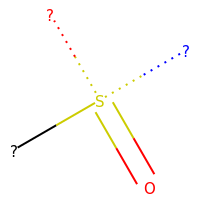
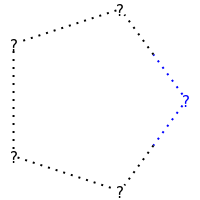
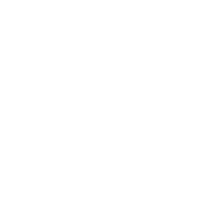
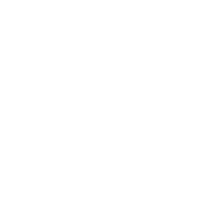
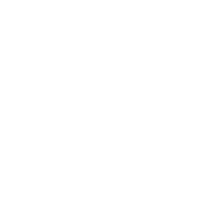
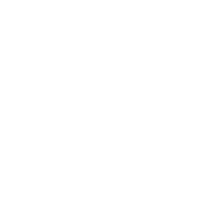
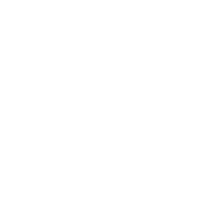
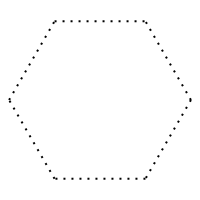
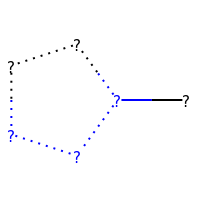
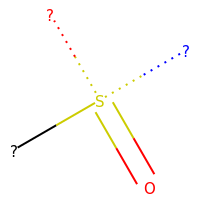
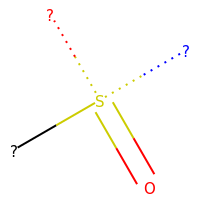

In [46]:
df[df.numAtoms<=6]

We can also render those better:

In [56]:
d = %sql postgresql://localhost/chembl_23 \
select * from (\
   select assay_id,count(distinct(molregno)) cnt,description  \
          from activities join assays using(assay_id)  \
          where standard_type = 'Ki' and confidence_score=9 and assay_type='B' and relationship_type='D' \
          group by (assay_id,description) order by cnt desc) tmp \
   where cnt<50 and cnt>20;
print(len(d))

2885


In [57]:
results = []
for i,row in enumerate(d):
    assay_id=row[0]
    print('Row:',i+1,row[-1])
    smis = %sql \
      select molregno,m from activities join rdk.mols using (molregno) where assay_id = :assay_id
    ms = [Chem.MolFromSmiles(y) for x,y in smis]
    tpl,svg=MCS_Report(ms,threshold=0.9,completeRingsOnly=True)
    results.append((row,smis,tpl,svg))

Row: 1 Displacement of [3H]PSB0413 from human platelet P2Y12 receptor
 * postgresql://localhost/chembl_23
Mean nAts 32.5, mcs nAts: 18
[#6,#8,#16]-[#6]1:,-[#6]:,-[#6](-[#8,#7]):,-[#6]2:[#6](:,-[#6]:,-1)-,:[#6](=,-[#8,#6])-,:[#6]1:,-[#6]:,-[#6]:[#6]:,-[#6]:,-[#6]:1-,:[#6]-,:2=,-[#8]
Row: 2 Displacement of [125I]RTI55 from human DAT expressed in COS1 cell membrane
 * postgresql://localhost/chembl_23
Mean nAts 19.0, mcs nAts: 7
[#6]-[#6]1=,-,:[#6]-,:[#6,#7]-,:[#6]-,:[#6,#7]-,:[#6]-,:1
Row: 3 Displacement of [3H]ZM-241385 from human adenosine A2a receptor expressed in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 30.3, mcs nAts: 19
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#7]:[#6](-[#6]3:[#6,#7]:[#7]:[#7,#6](:[#6]:3)-[#6,#7]):[#7]:[#6]:2:[#7](:[#6]:1=[#8])-[#6]
Row: 4 Binding affinity to human factor 10a after 10 mins
 * postgresql://localhost/chembl_23
Mean nAts 33.3, mcs nAts: 26
[#6]1:,-[#6]:,-[#6](-[#17,#6]):,=[#6](:,-[#16]:,-1)-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#6](=[

Mean nAts 30.2, mcs nAts: 18
[#7,#6,#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 32 Displacement of [3H]CP-55940 from human CB2 receptor expressed in CHO cell membranes after 1 hr by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 30.2, mcs nAts: 18
[#7,#6,#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 33 Displacement of [3H]histamine from human histamine H4 receptor
 * postgresql://localhost/chembl_23
Mean nAts 19.3, mcs nAts: 9
[#7]-[#6]1:[#6,#7]:[#6](-[#7]):[#7,#6]:[#6](:[#7,#6]:1)-[#7]
Row: 34 Binding affinity for HIV-1 protease enzyme was measured by using fluorescent peptide substrate
 * postgresql://localhost/chembl_23
Mean nAts 39.9, mcs nAts: 28
[#6]-[#6]-[#7]1-[#6](=[#8,#7])-[#7](-[#6]-[#6])-[#6](-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6](-[#6](-[#6]-1-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#8])-[#8]
Row: 35 BindingDB_Paten

Mean nAts 35.0, mcs nAts: 33
[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#7]:[#6](:[#7]:2)-[#6]1:[#6]:[#6](-[#6](-[#6]-[#6](=[#8])-[#8])-[#6](=[#8])-[#8]):[#6]:[#6](:[#6]:1-[#8])-[#6]1:[#6]:[#6]:[#6]:[#6,#7]:[#6]:1
Row: 59 Displacement of Flu-BID/FAM-BID from His-tagged MCL1 (171 to 327) (unknown origin) expressed in Escherichia coli BL21(DE3) after 3 hrs by fluorescence polarization assay
 * postgresql://localhost/chembl_23
Mean nAts 28.4, mcs nAts: 18
[#6,#8]-,=[#16,#6](=,-[#8,#6])-[#7]-[#6]1:[#6]:[#6](-[#16,#6]-[#6]-[#6]):[#6](:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2)-[#8]
Row: 60 Inhibition of fluorescently labeled VER51001 binding to full length human HSP90beta after 30 mins by fluorescence polarization assay
 * postgresql://localhost/chembl_23
Mean nAts 26.1, mcs nAts: 19
[#6]-[#16,#6,#7,#8]-[#6]1:[#7]:[#6](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2-[#6,#17])-[#9,#6,#8,#17]):[#6]2:[#6](:[#7]:1):[#7]:[#6,#7]:[#6,#7]:2
Row: 61 Inhibition of human recombinant cathepsin K expressed in b

Mean nAts 40.5, mcs nAts: 29
[#6]-[#7]1-[#6](=[#8])-[#7,#6](-[#6,#7]-[#6](=[#8])-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#7]=[#6](-[#6]2:[#6]-1:[#6]:[#6]:[#6]:[#6]:2)-[#6]1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6,#7]-,:1
Row: 80 Displacement of [3H]N-alpha-methylhistamine from human recombinant histamine H3 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 27.0, mcs nAts: 22
[#17,#6,#7,#35]-[#6]1:[#6,#7]:[#6,#7]:[#6]2:[#6](:[#7,#6]:1):[#16]:[#6](:[#7]:2)-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#7]1-[#6]-[#6]-[#6]-[#6]-[#6]-1
Row: 81 Inhibition of mouse TAAR1
 * postgresql://localhost/chembl_23
Mean nAts 24.0, mcs nAts: 18
[#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#17,#6,#8,#9,#35])-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#17,#6,#7,#8,#9,#16,#35])-[#17,#7,#9,#16,#35]
Row: 82 Inhibition of rabbit skeletal muscle glycogen phosphorylase b assessed as inorganic phosphate release
 * postgresql://localhost/chembl_23
Mean nAts 23.2, mcs nAts: 15
[#6,#7,#8]-,=[#6](=,

Mean nAts 35.9, mcs nAts: 24
[#7,#6,#8]-[#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-[#6]:,-1)-[#6]1:[#7]:[#6]:[#6]:[#7]:[#6]:1-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 103 Displacement of [3H]LSD from human recombinant 5HT7 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 29.5, mcs nAts: 20
[#6]1(-[#6]-[#6]-[#6]-[#6]-[#7]2-[#6]-[#6]-,=[#6,#7]-,:[#6]-[#6]-2)-[#6](=[#8])-[#7]-[#6]2:[#6]-1:[#6]:[#6]:[#6]:[#6]:2
Row: 104 Inhibition of human thymidylate synthase A
 * postgresql://localhost/chembl_23
Mean nAts 23.9, mcs nAts: 11
[#8,#6,#7,#16]=,-[#6]1-,:[#8,#6]-,:[#6]-,:[#6]:[#6]2:[#6]-,:1:[#6]:[#6]:[#6]:[#6]:2
Row: 105 Binding affinity for human 5-hydroxytryptamine 6 receptor
 * postgresql://localhost/chembl_23
Mean nAts 25.2, mcs nAts: 8
[#6,#7]1:,-[#6,#7]:,-[#6,#7]:,-[#6,#7](:,-[#6,#7]:,-[#6,#7]:,-1)-[#16,#7,#8]=,-[#8,#6,#7,#16]
Row: 106 Inhibition of mouse Oat1-mediated [3H]PAH uptake in Xenopus oocytes after 1 hr
 * postgresql://loc

Mean nAts 41.0, mcs nAts: 34
[#6,#7,#8]-,=[#6]-[#7]-[#6]-[#6]1(-[#7]2-[#6]-[#6]-[#7](-[#6]-[#6]-2)-[#6](=[#8])-[#6](-[#6]-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2-[#17])-[#17])-[#7]-[#6](=[#8])-[#6]-[#6]-[#7])-[#6]-[#6]-[#6]-[#6]-[#6]-1
Row: 132 Binding affinity to human neuropeptide Y receptor type 2 receptor expressed in CHO cells using Cy5-pNPY by flow cytometric analysis
 * postgresql://localhost/chembl_23
Mean nAts 80.8, mcs nAts: 35
[#7]=,-[#6](-,=[#7,#8])-,=[#7]-[#6]-[#6]-[#6]-[#6](-[#7]-[#6](=[#8])-[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](=[#8])-[#7]-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8,#6]
Row: 133 Displacement of [3H]-U-69,593 from Opioid receptor kappa 1 in guinea pig cerebellar.
 * postgresql://localhost/chembl_23
Mean nAts 48.3, mcs nAts: 38
[#6](-[#7]-[#6](=[#8])-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-1-[#6]-[#7]1-[#6]-[#6]-[#6]2(-[#6](-[#6]-1-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]-2:1)-[#8])-[#6])-[#6])-[#6](=[#8])-[#7]-[#6

Mean nAts 29.7, mcs nAts: 19
[#6]-[#7]-[#6]-[#6]1:[#6]:[#6](-[#6](=[#8])-[#7]):[#6]:[#6]:[#6]:1-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 163 Binding affinity to human BK1 receptor
 * postgresql://localhost/chembl_23
Mean nAts 36.9, mcs nAts: 26
[#6]-[#8]-[#6](=[#8])-[#6]1:[#6](-[#9,#17]):[#6]:[#6]:[#6]:[#6]:1-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#9])-[#6]-[#7]-[#6]1:[#6,#7]:[#6]:[#6]:[#6]:[#7,#6]:1
Row: 164 Inhibition of HIV1 protease
 * postgresql://localhost/chembl_23
Mean nAts 44.5, mcs nAts: 24
[#7]-[#6]-[#6](-[#8])-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#8]-[#6]1-[#6]-[#8]-[#6]2-[#6]-1-[#6]-[#6]-[#8]-2
Row: 165 Displacement of [125I]human urotensin 2 from human recombinant urotensin 2 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 29.7, mcs nAts: 12
[#7,#6]-[#6]-[#6](=[#8])-[#7]1-[#6]-[#6]-[#6,#8]-[#6]-[#6]-1-[#6]-[#7]
Row: 166 Inhibition of Mycobacterium tuberculosis PtpA
 * postgresql://localhost/chembl_23
Mean nAts 22.

Mean nAts 34.7, mcs nAts: 32
[#6]-[#6](-[#6])-[#6]1-[#6]2:[#7]:[#6]3:[#6]:[#6]:[#6](:[#6]:[#6]:3:[#7]:2-[#6]-[#6]-[#7]-1-[#6]1:[#7]:[#6]:[#6](:[#6](:[#7]:1)-[#6](-[#9])(-[#9])-[#9])-[#6]-,=[#8,#6,#7])-[#16](-[#6])(=[#8])=[#8]
Row: 192 Binding affinity against human immunodeficiency virus (HIV) protease
 * postgresql://localhost/chembl_23
Mean nAts 39.2, mcs nAts: 23
[#7,#6,#8,#16]-[#6,#7,#16]-[#6,#7]-[#6,#7]-[#6]-[#6]-[#7,#6]-[#6,#7]-[#8,#6]-[#6,#8]-[#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]2:[#6]-1:[#6]:[#6]:[#6]:[#6]:2
Row: 193 Binding affinity to 5HT1A receptor (unknown origin)
 * postgresql://localhost/chembl_23
Mean nAts 28.8, mcs nAts: 18
[#6]-[#7,#8]-[#6]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6,#7]:[#6,#7]:[#6]:[#6]:[#6,#7]:1
Row: 194 Binding affinity to 5HT2A receptor (unknown origin)
 * postgresql://localhost/chembl_23
Mean nAts 28.8, mcs nAts: 18
[#6]-[#7,#8]-[#6]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6,#7]:[#6,#7]:[#6]:[#6]:[#6,#7]:1


Mean nAts 24.8, mcs nAts: 17
[#6,#8]-,=[#6]-[#7](-[#6]-[#6])-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6](:[#6]:[#6](:[#7]:2)-,=[#8])-[#6,#8,#17,#35]
Row: 225 Displacement of [3H]CP-55940 from human CB2 receptor expressed in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 34.5, mcs nAts: 24
[#6]-,=,#[#6]-[#6]-[#7]1:[#6]:[#6](-[#6](=[#8])-[#7]-[#7,#6]2-[#6]-[#6]-[#6]-[#6]-[#6]-2):[#6](:[#6]2:[#6]:1:[#6]:[#6]:[#6](:[#6]:2)-[#35,#6,#7,#16,#53])=[#8]
Row: 226 Displacement of [3H]CP-55940 from human CB1 receptor expressed in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 34.5, mcs nAts: 24
[#6]-,=,#[#6]-[#6]-[#7]1:[#6]:[#6](-[#6](=[#8])-[#7]-[#7,#6]2-[#6]-[#6]-[#6]-[#6]-[#6]-2):[#6](:[#6]2:[#6]:1:[#6]:[#6]:[#6](:[#6]:2)-[#35,#6,#7,#16,#53])=[#8]
Row: 227 Inhibition of GST-tagged astrosclera willeyana Astrosclerin-3 expressed in Escherichia coli after 15 mins preincubation by stopped flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 16.3, mcs nAts: 6
[#6]1:,

Mean nAts 30.2, mcs nAts: 20
[#6,#7]-[#7]-[#6]-[#6]1:[#6](-[#6]):[#7]:[#6]2:[#7]:1-[#6]-[#6]-[#7]-2-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#6,#17,#35])-[#6,#17]
Row: 252 Displacement of [3H]5-HT from human 5-HT7 receptor expressed in HEK293 cells after 30 mins by microbeta counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 26.6, mcs nAts: 15
[#7,#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7,#6](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 253 Binding affinity to human thrombin by standard kinetic photometric assay
 * postgresql://localhost/chembl_23
Mean nAts 25.4, mcs nAts: 19
[#6,#7]-[#6,#7]-[#6](=[#8])-[#7,#6]1-[#6]-[#6]-[#6]-[#6,#7]-1-[#6](=[#8])-[#7,#6]-[#6]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-1
Row: 254 Inhibition of human recombinant dUTPase
 * postgresql://localhost/chembl_23
Mean nAts 27.8, mcs nAts: 10
[#6]1:[#6]:[#6]:[#7,#6](:[#6]:[#7,#6]:1)-[#6,#14]-[#6,#7,#8]-,=[#6]-[#8,#6,#7]
Row: 255 Inhibition of human glutaminyl cyclase expressed in Escherichia coli DH5alpha

Mean nAts 24.7, mcs nAts: 18
[#6]1:[#6]:[#6,#7]:[#6]:[#6](:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#8,#6,#7])-[#6](-[#6])(-[#6])-[#6]-,=[#8,#6,#7]
Row: 276 Inhibition of bovine thrombin using D-Phe-Pip-Arg-p-NA as substrate by chromogenic assay
 * postgresql://localhost/chembl_23
Mean nAts 30.7, mcs nAts: 20
[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#7]-[#6]-[#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6,#7]:[#6]:[#7,#6]:[#6]:[#6,#7]:1
Row: 277 Inhibition of human factor 10a using Z-D-Arg-Gly-Arg-p-NA as substrate by chromogenic assay
 * postgresql://localhost/chembl_23
Mean nAts 30.7, mcs nAts: 23
[#6,#7,#8,#9,#16,#17,#35]-[#7,#6]1-,:[#6]-,:[#6]-,:[#6](-,:[#6]-,:[#6]-,:1)-[#6,#8]-[#7,#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#8,#6,#7]-[#6,#8]-[#6]1:,-[#6]:,-[#6]:,-[#6,#7]:,-[#6]:,-[#6]:,-1
Row: 278 Displacement of [3H]CP-55940 from Sprague-Dawley rat brain CB1 receptor after 90 mins by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 31.5, mcs nAts: 20
[#6]-[#

Mean nAts 75.4, mcs nAts: 40
[#6]-[#6]-[#6]-[#7](-[#7]-[#6](=[#8])-[#6]1-[#6]-[#6]-[#6]-[#7]-1-[#6](=[#8])-[#6](-[#7]-[#6](=[#8])-[#6](-[#7]-[#6](=[#8])-[#6](-[#6]-[#6](=[#8])-[#8])-[#7]-[#6](-,=[#6,#8])=,-[#8,#6])-[#6](-[#6])-[#6])-[#6](-[#6])-[#6])-[#6,#16](=,-[#8,#6])-,=[#8,#6,#7,#16]
Row: 306 BindingDB_Patents: Inhibition Assay. Antibacterial activity as measured by the minimal inhibitory concentrations (MIC) and minimal bactericidal concentrations of compounds are well known (see., e.g., National Committee for Clinical Laboratory Standards 2000 Performance standards for antimicrobial disk susceptibility tests: approved standard, 7th ed. M2-A7, vol. 20, no. 1, Committee for Clinical Laboratory Standards, Wayne, Pa.).
 * postgresql://localhost/chembl_23
Mean nAts 25.6, mcs nAts: 13
[#6,#7]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#7]:[#6](:[#7]:[#6]:2-[#7])-[#7]
Row: 307 Inhibition of rat SERT
 * postgresql://localhost/chembl_23
Mean nAts 29.7, mcs nAts: 19
[#6]-[#7]-[#6]-[#6]1:[#6]:[#6

Mean nAts 17.0, mcs nAts: 15
[#8,#6]=,-[#6]1-[#6,#7]2:,-[#6]:,-[#6]:,-[#6,#7]:,-[#6]:,-[#6]:,-2-[#6]-[#6,#7]2-,:[#7,#6]-1-,:[#6]-,:[#6,#7]-,:[#7,#6]-,:[#6]-,:2
Row: 336 Inhibition of human STEP using pNPP as substrate after 5 mins by spectrophotometric plate reader analysis
 * postgresql://localhost/chembl_23
Mean nAts 23.9, mcs nAts: 12
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 337 Displacement of [3H](+)-pentazocine from sigma-1 receptor in rat brain homogenates
 * postgresql://localhost/chembl_23
Mean nAts 21.8, mcs nAts: 12
[#7,#8]-[#6]1-[#6]2-[#6]3-[#6]-[#6]4-[#6]-1-[#6]1-[#6]-2-[#6]-[#6]-3-[#6]-1-4
Row: 338 Inhibition of human recombinant Carbonic anhydrase 2 compound preincubated for 15 mins by stopped flow CO2 hydrase assay method
 * postgresql://localhost/chembl_23
Mean nAts 16.4, mcs nAts: 6
[#6]1:,-[#6,#7]:,-[#6,#7,#8]:,-[#6,#16]:,-[#6]:,-[#6,#7]:,-1
Row: 339 Inhibition of human recombinant c-Src by filter-binding assay
 * postgresql://localhos

Mean nAts 31.3, mcs nAts: 22
[#6]-[#6]-,#[#8,#6]-[#6]1:[#7]:[#6](-[#7]):[#6]2:[#6](:[#7]:1):[#7](:[#6]:[#7]:2)-[#6]1-[#8]-[#6](-[#6]-[#8,#7])-[#6](-[#6]-1-[#8])-[#8]
Row: 368 Inhibition of [3H]R-PIA binding to human Adenosine A1 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 30.2, mcs nAts: 20
[#6]-[#7]-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#7]:[#6]:[#7]:2-[#6]1-[#8,#6]-[#6](-[#6]-[#8,#7])-[#6](-[#6]-1-[#8])-[#8]
Row: 369 Displacement of [3H]CP-55940 from human recombinant CB1 receptor
 * postgresql://localhost/chembl_23
Mean nAts 29.5, mcs nAts: 18
[#6]-,=[#6]-,=[#6]-,=[#6]-,=[#6]-,=[#6]-,=[#6]-,=[#6]-,=[#6]=,-[#6,#7]-[#6,#7]-[#7,#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#7]:,-[#6]:,-[#6]:,-1
Row: 370 Inhibition of Pim1 (unknown origin) using 5FAM-ARKRRRHPSGPPTA as substrate after 90 mins
 * postgresql://localhost/chembl_23
Mean nAts 25.0, mcs nAts: 11
[#6]-[#6]1:[#7,#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6](:[#7,#6]:[#6]:2)-[#6,#7]
Row: 371 Binding affinity to FKBP51 FK506-b

Mean nAts 6.6, mcs nAts: 0

Row: 399 Inhibition of [3H]DA uptake at VMAT2 in rat striatal synaptic vesicles
 * postgresql://localhost/chembl_23
Mean nAts 29.2, mcs nAts: 22
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6]-[#6]1-[#6]-[#6]-[#6]-[#6](-[#7]-1)-[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 400 Displacement of [3H]-ZM241385 from human A2B receptor expressed in HEK293 cell membranes
 * postgresql://localhost/chembl_23
Mean nAts 29.9, mcs nAts: 19
[#6]-[#6]-[#7]1:[#6](=[#8]):[#7]:[#6]:[#6](:[#6]:1):[#7]:[#6](:[#7])-[#6]1:[#6]:[#7]:[#7](:[#6]:1)-[#6]-[#6]
Row: 401 Displacement of [3H]-CPX from human A1 receptor expressed in CHO cell membranes
 * postgresql://localhost/chembl_23
Mean nAts 29.9, mcs nAts: 19
[#6]-[#6]-[#7]1:[#6](=[#8]):[#7]:[#6]:[#6](:[#6]:1):[#7]:[#6](-[#6]1:[#6]:[#7]:[#7](:[#6]:1)-[#6]-[#6]):[#7]
Row: 402 Displacement of [125]DOI from human recombinant full length 5HT2C receptor expressed in HEK293E cells
 * postgresql://localhost/chembl_23
Mean nAts 29.5, mcs nA

Mean nAts 23.5, mcs nAts: 7
[#7,#6,#8]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-1
Row: 430 Displacement of [3H]granisetron from human 5HT3A receptor expressed in HEK293 cells by filter binding assay
 * postgresql://localhost/chembl_23
Mean nAts 22.5, mcs nAts: 14
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#16,#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]
Row: 431 Inhibition of human carbonic anhydrase 2 preincubated for 15 mins by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 6.5, mcs nAts: 0

Row: 432 Displacement of [3H]N-alpha methyl histamine from human cloned histamine H3 receptor expressed in C6 cells
 * postgresql://localhost/chembl_23
Mean nAts 23.5, mcs nAts: 7
[#7,#6,#8]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-1
Row: 433 Displacement of [3H]N-methylspiperone from human D2L receptor expressed in CHO cells after 1.5 hrs by microbeta counting method
 * postgresql://localhost/chembl_23
Mean nAts 29.8, mcs nAts: 9
[#7,#6]1-,:[#6]-,:[#6]-,:[#7,#6](-,:[#6

Mean nAts 13.6, mcs nAts: 11
[#7,#6,#8,#17]-[#6,#7]1=,-,:[#7,#6]-,:[#6]2:,-[#6,#7]:,-,=[#6,#7]:,-[#6,#7]:,-,=[#6,#7]:,-[#6]:2-,:[#6,#7]-,=,:[#7,#6]-,:1
Row: 454 Inhibition of human carbonic anhydrase 7 preincubated for 15 mins by CO2 hydration stopped-flow assay
 * postgresql://localhost/chembl_23
Mean nAts 14.1, mcs nAts: 7
[#7,#6,#8]-[#6]1:[#6]:[#6]:[#6,#7]:[#6]:[#6]:1
Row: 455 Binding affinity to Homo sapiens (human) alpha1A adrenergic receptor
 * postgresql://localhost/chembl_23
Mean nAts 43.9, mcs nAts: 35
[#7,#6,#8]-,=[#6](=,-[#8,#7])-[#6]1=[#6](-[#6])-[#7]-[#6](=[#6](-[#6]-1-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](=[#8])-[#7]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]
Row: 456 BindingDB_Patents: FLIPR Assay. The agonistic or antagonistic effect of the substances to be tested on the vanilloid receptor 1 (VR1) can also be determined using the following assay. In this assay, the influx of Ca2+ through the channel is quantified with the a

Mean nAts 37.8, mcs nAts: 11
[#6,#7]1:[#6,#7](-[#6]):[#6,#7]:[#7,#6](:[#6](:[#7,#6]:1)=[#8])-[#6]-[#6,#8]-[#7,#6]
Row: 477 Inhibition of archaeon Methanosarcina thermophila gamma-CA after 15 mins by stopped-flow/Co2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 6.6, mcs nAts: 0

Row: 478 Inhibition of human carbonic anhydrase 1 preincubated for 15 mins by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 6.5, mcs nAts: 0

Row: 479 Inhibition of binding to human D3 receptor expressed in HEK 293 cells by radioligand binding assay
 * postgresql://localhost/chembl_23
Mean nAts 21.0, mcs nAts: 6
[#6,#7]1:,-[#6,#8]:,-[#6]:,-[#6]:,-[#6]:,-[#6,#7,#8]:,-1
Row: 480 Inhibition of human carbonic anhydrase 2 preincubated for 15 mins by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 6.5, mcs nAts: 0

Row: 481 Binding affinity against opioid receptor kappa 1 using [3H]-U-69,593 as radioligand in guinea pig brain membranes.

Mean nAts 32.1, mcs nAts: 19
[#6]-[#7]1:[#7]:[#6](-[#6]-[#6]2:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-2):[#6]2:[#6](:[#6]:1=[#8]):[#6]:[#6]:[#6]:[#6]:2
Row: 510 Displacement of [3H]E-3-(2-chloro-8-methylquinolin-3-yl)-1-(thiophen-2-yl)prop-2-en-1-one from mGluR1 in rat cerebellar membrane after 14 to 16 hrs by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 23.9, mcs nAts: 8
[#6,#8]=,-[#6,#7,#8]-[#6]1:,-[#6,#7]:,-[#7,#6]:,-[#6]:,-[#6,#7]:,-[#6,#7]:,-1
Row: 511 Inhibitory activity against Carbonic anhydrase I
 * postgresql://localhost/chembl_23
Mean nAts 21.8, mcs nAts: 8
[#6]1:,-[#6]:,-[#6,#16]:,-[#6]:,-[#6,#16]:,-[#6,#7]:,-1-[#16,#6,#7,#8]=,-[#8,#6,#7]
Row: 512 Displacement of [3H]CCPA from human recombinant adenosine A1 receptor expressed in CHO cells after 60 mins by gamma counter
 * postgresql://localhost/chembl_23
Mean nAts 27.7, mcs nAts: 7
[#8,#6,#7]-,=[#6,#7]1:,-[#6,#7]:,-[#6,#7]:,-[#6,#7]:,-[#6,#7]:,-[#6,#7]:,-1
Row: 513 Inhibition of human cloned carbonic an

Mean nAts 28.5, mcs nAts: 16
[#7]-[#6]1:[#7]:[#6](-[#8,#7]):[#7]:[#6]2:[#7]:1:[#7]:[#6](:[#7]:2)-[#6]1:[#6]:[#6]:[#6]:[#8]:1
Row: 543 Displacement of [125I]IABN from human dopamine D2L receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 25.5, mcs nAts: 23
[#8,#6,#7,#9]-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]1:[#6,#7]:[#7,#6,#8]:[#6](:[#6,#7]:1):[#6]:[#6]:[#6]:[#6]
Row: 544 Displacement of [125I]IABN from human dopamine D3 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 25.5, mcs nAts: 23
[#8,#6,#7,#9]-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]1:[#6,#7]:[#7,#6,#8]:[#6](:[#6,#7]:1):[#6]:[#6]:[#6]:[#6]
Row: 545 Displacement of [125I]NDP-MSH from human MC4R expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 39.1, mcs nAts: 30
[#6]-[#6,#7]-[#6](-[#7,#6])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](=[#8])-

Mean nAts 19.7, mcs nAts: 13
[#7]-[#6](=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1:[#7]:[#6](:[#7]:2)-[#6]
Row: 572 Displacement of [beta-33P]-2MeS-ADP from human P2Y1 receptor transfected in HEK293 cells assessed as residual [beta-33P] bound to plate after 1 hr by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 28.9, mcs nAts: 23
[#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]-[#6]1:[#6]:[#6]:[#6]:[#7]:[#6]:1-[#8,#7,#16]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 573 Inhibition of human cytosolic carbonic anhydrase 2 by stopped flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 11.2, mcs nAts: 4
[#6,#8]-,=[#6,#7](-,=[#6,#7,#8])-,=[#6,#7,#8]
Row: 574 Displacement of [3H]-MPEP from human mGluR5 expressed in CHO cells after 60 mins
 * postgresql://localhost/chembl_23
Mean nAts 26.6, mcs nAts: 21
[#8,#6]=,-[#6](-,=[#6,#8])-[#7]1-[#6]-[#6]-[#6]-[#6]-1-[#6]1:[#6]:[#6,#7]:[#6](:[#7,#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6,#7]:[#6](:[#6]:1)-[#17,#6,#9]


Mean nAts 29.0, mcs nAts: 15
[#6]-[#6](=[#8])-[#8]-[#6]-[#6]1(-[#6]-[#8])-[#6]-[#6](=[#6]-[#6])-[#6](-[#8]-1)=[#8]
Row: 597 Inhibition of human cytosolic carbonic anhydrase 1 preincubated for 15 mins by stopped flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 6.6, mcs nAts: 0

Row: 598 Displacement of [3H]-(+)-pentazocine from human sigma1 receptor transfected in HEK293 cells after 120 mins by liquid scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 25.8, mcs nAts: 11
[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1)-,:[#7,#6]-,:[#6](-[#6,#7])-,:[#6]-,:[#6]-,:2
Row: 599 Displacement of [3H]U-69593 from cloned human kappa opioid receptor
 * postgresql://localhost/chembl_23
Mean nAts 31.6, mcs nAts: 27
[#6,#8]-,=[#6](=,-[#8,#6])-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)(-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#7]:[#6]:[#6]:[#7]:1-[#6]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6,#7]:,-1
Row: 600 Inhibition of human carbonic anhydrase 12 catalytic domain preincub

Mean nAts 37.9, mcs nAts: 30
[#6]-[#6]1:[#6]:[#6]:[#6]2:[#7,#6](:[#6]:1):[#7,#6]:[#6]1:[#6,#7]:2-[#6]-[#6](-[#6]-[#6]-1)(-[#6])-[#7]-[#6](=[#8])-[#6]1:[#6,#7]:[#6]:[#6](:[#6]:[#6]:1-[#17])-[#7]1:[#6]:[#7]:[#6,#7]:[#7,#6]:1
Row: 628 Inhibition of human carbonic anhydrase-2 by CO2 hydration reaction based colorimetric stopped-flow method
 * postgresql://localhost/chembl_23
Mean nAts 6.6, mcs nAts: 0

Row: 629 Inhibition of human cloned CA1 by CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 33.3, mcs nAts: 9
[#6]-[#8,#6,#7,#16]-[#6,#7,#8]-[#6]1:,-[#6,#8]:,-[#6,#7]:,-[#6,#16]:,-[#6,#8]:,-[#6]:,-1
Row: 630 Inhibition of human cloned CA2 by CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 33.3, mcs nAts: 9
[#6]-[#8,#6,#7,#16]-[#6,#7,#8]-[#6]1:,-[#6,#8]:,-[#6,#7]:,-[#6,#16]:,-[#6,#8]:,-[#6]:,-1
Row: 631 Displacement of [3H]5-HT from human recombinant 5-HT1B receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 32.5, mcs nAts: 26
[#6

Mean nAts 39.1, mcs nAts: 33
[#6]-[#7](-[#6](=[#8])-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#9])-[#6]1-[#6]-[#7](-[#6](=[#8])-[#6]2:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6,#7]:,-[#6]:,-2)-[#6,#7])-[#6]-[#6]-1-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17]
Row: 653 Inhibition of human NET
 * postgresql://localhost/chembl_23
Mean nAts 19.0, mcs nAts: 17
[#6]-[#7]1-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6](-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 654 Displacement of [3H]histamine from human recombinant histamine H4 receptor
 * postgresql://localhost/chembl_23
Mean nAts 29.6, mcs nAts: 21
[#6]1:[#6]:[#6](-[#8]-[#6]-[#6]-[#6]-[#7,#6]):[#6]:[#6]:[#6]:1-[#6]1:[#7]:[#6]2:[#6]:[#6](-[#9,#6]):[#6]:[#6]:[#6]:2:[#7]:1
Row: 655 BindingDB_Patents: Scintillation Proximity Assay. The CCR3 receptor binding assay was performed in a Scintillation Proximity Assay (SPA) design with the radioligand recombinant human 125Iodine-eotaxin-1. Cell membranes of hCCR3 C1 cells were again homogenized by passing through a s

Mean nAts 25.0, mcs nAts: 17
[#7,#6]-[#6]1:[#6,#7]:[#6](-[#7]-[#6](-,=[#6,#8])=,-[#8,#6,#7]):[#7,#6]:[#6](:[#7]:1)-[#7]1:,-[#7,#6]:,-[#6]:,-[#6]:,-[#6]:,-1-[#6]
Row: 682 Inhibition of PARP1 using [3H]NAD+ after 1 hr by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 28.9, mcs nAts: 20
[#7,#6]-[#6]1:[#6]:[#6](-[#6]-[#6]2:[#7]:[#7]:[#6](:[#6]3:[#6]:2-[#7]-[#6]-[#6]-[#6]-3)=[#8]):[#6]:[#6]:[#6]:1-[#9]
Row: 683 Displacement of [125J]-eotaxin-1 from rat CCR3 transfected in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 33.8, mcs nAts: 28
[#6,#8]-[#6]-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6]:1-[#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#16,#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#9,#6,#8,#17]
Row: 684 Displacement of [125J]-eotaxin-1 from mouse CCR3 transfected in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 33.8, mcs nAts: 28
[#6,#8]-[#6]-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6]:1-[#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[

Mean nAts 21.4, mcs nAts: 16
[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](-,=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 714 Inhibition of human BChE
 * postgresql://localhost/chembl_23
Mean nAts 21.4, mcs nAts: 16
[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](-,=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 715 Inhibition of human beta tryptase
 * postgresql://localhost/chembl_23
Mean nAts 42.1, mcs nAts: 27
[#8,#6]-,=[#6](=,-[#8,#6])-[#7]-[#6](-[#6]-[#6]-[#6]-[#6]-[#7])-[#6](=[#8])-[#6]1:[#7]:[#8]:[#6](:[#7]:1)-[#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-[#6]:,-1)-[#6,#8]-[#7,#6,#8]-[#6]
Row: 716 Displacement of [3H]DPCPX from human cloned adenosine A1 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 26.6, mcs nAts: 17
[#6]-[#6]1:,-[#6]:,-[#7]2:[#6](:,-[#7,#6]:,=1):[#7]:[#6]1:[#6]:2:[#6](=[#8]):[#7](-[#6]):[#6](:[#7]:1-[#6])=[#8]
Row: 717 Displacement of [3H]ZM241385 from human cloned adenosine A2A receptor expressed in CHO cells
 * postgresql:

Mean nAts 24.2, mcs nAts: 21
[#6]-[#8]-[#6]1:[#6]:,-[#6]-,:[#6,#7]-[#6]-[#7,#6]-[#6]-,:[#6](:,-[#6]-[#6]-[#6,#7]-,:[#6]:,-[#6]:[#6]:1-[#8]):[#6]:[#6]:[#6]:[#6]
Row: 744 Displacement of [3H]spiperone from dopamine D2 receptor (unknown origin) expressed in human HEK293 cells by liquid scintillation counter
 * postgresql://localhost/chembl_23
Mean nAts 24.2, mcs nAts: 21
[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#6]-[#6]-[#6,#7]:,-[#6]:,-[#6]:[#6](:[#6](:[#6])-[#8])-[#8]-[#6])-[#6]-[#7,#6]-[#6,#7]-,:[#6]
Row: 745 Displacement of [3H]8-OH-DPAT from 5-HT1A receptor (unknown origin) expressed in HEK293 cells by liquid scintillation counter
 * postgresql://localhost/chembl_23
Mean nAts 24.2, mcs nAts: 21
[#6]-[#8]-[#6]1:[#6]:,-[#6]-,:[#6,#7]-[#6]-[#7,#6]-[#6]-,:[#6](:,-[#6]-[#6]-[#6,#7]-,:[#6]:,-[#6]:[#6]:1-[#8]):[#6]:[#6]:[#6]:[#6]
Row: 746 Displacement of [125I]SS-14 from human SSTR3 expressed in CHO cells after 60 to 90 mins
 * postgresql://localhost/chembl_23
Mean nAts 27.0, mcs nAts: 16
[#6]-

Mean nAts 18.4, mcs nAts: 13
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]12-[#6]-[#6,#7]-[#7,#6]-[#6]-[#6]-1-[#6]-2
Row: 767 Displacement of [N-methyl-3H]citalopram from human recombinant SERT expressed in pig LLCPK cells after 2 hrs by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 18.4, mcs nAts: 13
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]12-[#6]-[#6,#7]-[#7,#6]-[#6]-[#6]-1-[#6]-2
Row: 768 Displacement of [3H]N-methylspiperone from rat dopamine D4 receptor by PDSP assay
 * postgresql://localhost/chembl_23
Mean nAts 24.4, mcs nAts: 15
[#6]1:[#6]:[#6,#7]:[#6](:[#6,#7]:[#6]:1)-[#7,#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]
Row: 769 Displacement of [3H]CP55,940 from human CB1 receptor expressed in CHO cells after 2 hrs by liquid scintillation counter
 * postgresql://localhost/chembl_23
Mean nAts 26.9, mcs nAts: 19
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6]1:[#6]:[#6]2:[#6](-[#8,#6]):[#6]:[#6]:[#6]:[#6]:2:[#8]:[#6]:1=[#8]
Row: 770 Displacement of [3H]NT from

Mean nAts 30.9, mcs nAts: 28
[#6]-[#7]1-[#6]-[#6]-[#6]23-[#6](-[#6]-1-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]-2:1)-[#8])(-[#6]-[#6]1:[#6]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#7]:[#6]:1-[#6]-3)-[#8]
Row: 794 Displacement of [3H]-8-OH-DPAT from 5-HT1A receptor in Sprague-Dawley albinus rat cerebral cortex membranes after 15 mins
 * postgresql://localhost/chembl_23
Mean nAts 26.5, mcs nAts: 9
[#8]=[#6]1-[#6]-[#7,#16]-[#6](-[#7]-1-[#6]-[#6])=[#8]
Row: 795 Displacement of [3H]DAMGO from mu opioid receptor in mouse whole brain without cerebellum
 * postgresql://localhost/chembl_23
Mean nAts 30.9, mcs nAts: 28
[#6]-[#7]1-[#6]-[#6]-[#6]23-[#6](-[#6]-1-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]-2:1)-[#8])(-[#6]-[#6]1:[#6]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#7]:[#6]:1-[#6]-3)-[#8]
Row: 796 Displacement of [3H]ZM241385 from human recombinant adenosine A2A receptor expressed in CHO cells after 120 mins by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 35.5, mcs nAts: 25
[#6]-[#6]-[#6]-[#

Mean nAts 43.6, mcs nAts: 31
[#8]=[#16](=[#8])(-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1-[#6]-[#6]2-[#8]-[#6]-1-[#6](-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8,#7])=[#6]-2-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]
Row: 823 Displacement of [125I]NDP-MSH from human MC4R expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 43.5, mcs nAts: 38
[#6,#8]-,=[#6](=,-[#8,#6])-[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#6](=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1(-[#6]-[#7]-[#6](=[#8])-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-[#6]-[#6]-[#6]-1
Row: 824 Displacement of [3H]-N-methylspiperone from human dopamine D4 receptor expressed in HEK293 cell membranes after 1 hr by liquid scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 33.4, mcs nAts: 28
[#8,#17]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#6]-[#6,#7]1:[#6]:[#7,#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#7]:1
Row: 825 Displa

Mean nAts 26.4, mcs nAts: 21
[#8,#7]=,-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#7]2:[#7]:1:[#7]:[#6](:[#6]:2=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 852 Displacement of [3H]NECA from human adenosine A2A receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 26.4, mcs nAts: 21
[#8,#7]=,-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#7]2:[#7]:1:[#7]:[#6](:[#6]:2=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 853 Displacement of [3H]AB-MECA from human adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 26.4, mcs nAts: 21
[#8,#7]=,-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#7]2:[#7]:1:[#7]:[#6](:[#6]:2=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 854 Displacement of [3H]spiperone from human D2 receptor transfected in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 132.7, mcs nAts: 11
[#6,#8]-,=[#6]-[#7,#6]1-[#6]-[#6]-[#6]-[#6,#7]-1-[#6]-[#7,#6]-[#6]=,-[#8,#6]
Row: 855 Displacement of [3H]-(+)-pentazocine from sigm

Mean nAts 44.4, mcs nAts: 38
[#7,#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](=[#8])-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#7]-[#6](=[#8])-[#6]1-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]-[#7]-1
Row: 883 Displacement of radioligand [125I]AB-MECA binding at rat A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 36.2, mcs nAts: 25
[#6]-[#6]-[#7]-[#6](=,-[#8])-[#6]1-[#8]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7]-[#6](=,-[#8,#7])-,=[#6,#7,#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 884 Displacement of [3H]N-methylspiperone from human dopamine D3 receptor by PDSP assay
 * postgresql://localhost/chembl_23
Mean nAts 24.5, mcs nAts: 15
[#6]1:[#6]:[#6,#7]:[#6](:[#6,#7]:[#6]:1)-[#7,#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]
Row: 885 Displacement of [125I]CGRP from human recombinant CL receptor /RAMP1
 * postgresql://localhost/chembl_23
Mean nAts 35.5, mcs nAts: 28
[#6]-[#7]1:[#6]:[#6](-[#6]):[#6]:[

Mean nAts 38.5, mcs nAts: 29
[#6,#8]-,=[#7,#6]-[#6,#7]-[#6]1:[#6]:[#7,#6]:[#6](:[#6](:[#6]:1)-[#17])-[#7]1-[#6]-[#6]-[#7,#6](-[#6]-[#6]-1)-[#6,#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 907 Inhibition of MAO-B in rat liver homogenate after 60 mins by Lineweaver-Burke plot
 * postgresql://localhost/chembl_23
Mean nAts 27.8, mcs nAts: 13
[#6]-[#7]1:[#6](=,-[#16,#7]):[#7]:[#6]2:[#6](:[#6]:1=[#8]):[#6]:[#6]:[#6]:[#6]:2
Row: 908 Inhibition of MAO-A in rat liver homogenate after 60 mins by Lineweaver-Burke plot
 * postgresql://localhost/chembl_23
Mean nAts 27.8, mcs nAts: 13
[#6]-[#7]1:[#6](=,-[#16,#7]):[#7]:[#6]2:[#6](:[#6]:1=[#8]):[#6]:[#6]:[#6]:[#6]:2
Row: 909 Inhibition of Mycobacterium tuberculosis MbtA expressed in Escherichia coli assessed as ATP-[32P]Ppi exchange
 * postgresql://localhost/chembl_23
Mean nAts 49.2, mcs nAts: 38
[#7]-[#6]1:[#7]:[#6](-[#7]2:[#6]:[#6](-[#6]):[#7]:[#7]:2):[#7]:[#6]2:[#6]:1:[#7]:[#6]:[#7]:2-[#6]1-[#8]-[#6](-[#6]-[#8]-[#16]

Mean nAts 30.4, mcs nAts: 25
[#6](-[#7,#16]-[#6]1:[#7]:[#6]:[#7]:[#6]:[#6]:1)-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#7,#6]:2:[#6](:[#6]:1-[#6]1:[#6,#7]:[#6]:[#6]:[#6]:[#6,#7]:1)=,-[#8]
Row: 938 Displacement of [3H]N-alpha-methylhistamine from histamine H3 receptor in guinea pig brain
 * postgresql://localhost/chembl_23
Mean nAts 23.5, mcs nAts: 17
[#6,#8]-,=[#6,#7,#8,#16]-[#6,#7,#16]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#6]-[#6]1:[#6]:[#7]:[#6]:[#7]:1
Row: 939 Displacement of [3H]DPCPX from human recombinant adenosine A1 receptor expressed in CHOK1 cells
 * postgresql://localhost/chembl_23
Mean nAts 31.8, mcs nAts: 25
[#6]-[#7]-[#6]1:[#7]:[#6]:[#6]2:[#6](:[#7]:1):[#7](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):[#6](:[#7]:2-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)=[#8]
Row: 940 Displacement of [3H](+)-Pentazocine from sigma 1 receptor in guinea pig brain membranes after 120 mins by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 28.6, mcs nAts: 8
[#6]1:,-[#6

Mean nAts 36.2, mcs nAts: 25
[#6]-[#6]-[#7]-[#6](=[#8])-[#6]1-[#8]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7]-[#6](=,-[#8,#7])-,=[#7,#6,#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 966 Binding affinity towards human opioid receptor like 1 was determined by using [3H]nociceptin as radioligand expressed in Chinese hamster ovary (CHO) cells
 * postgresql://localhost/chembl_23
Mean nAts 32.0, mcs nAts: 27
[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#8]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#7]1:[#6](-,=[#8]):[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2)-[#17,#6,#7,#9]
Row: 967 Inhibition of human coagulation factor 11a at 25 degC
 * postgresql://localhost/chembl_23
Mean nAts 37.8, mcs nAts: 24
[#6,#7,#8]-,=[#6](=,-[#8,#6,#7])-[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#7]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#6](:[#7]:1)-[#17]
Row: 968 Displacement of [3H]N/OFQ from human recombinant ORL1 receptor expressed in HEK293 cells after 45 mins by scintillation proximity

Mean nAts 40.7, mcs nAts: 31
[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6](-[#6]-[#6](=[#8])-[#7]-[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:4):[#7]:[#7]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#6]-[#7]
Row: 992 Displacement of [125I]alpha-bungarotoxin from alpha7 nAchR in rat frontal cortices
 * postgresql://localhost/chembl_23
Mean nAts 21.1, mcs nAts: 19
[#6,#7]1:[#6]:[#6]:[#6](:[#6]:[#6,#7]:1)-[#6,#7]1:[#6]:[#7,#6](-[#6]2-[#6]-[#7]3-[#6]-[#6]-[#6]-2-[#6]-[#6]-3):[#7]:[#7]:1
Row: 993 Displacement of [3H]RAMHA from human histamine H3 receptor expressed in SK-N-MC cells
 * postgresql://localhost/chembl_23
Mean nAts 27.0, mcs nAts: 16
[#7,#6,#8]-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7,#6]
Row: 994 Displacement of [3H]RAMHA from histamine H3 receptor in Wistar rat brain membrane
 * postgresql://localhost/chembl_23
Mean nAts 27.0, mcs nAts: 16
[#7,#6,#8]-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7,#6]
Row:

Mean nAts 29.1, mcs nAts: 20
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]1:[#7]:[#8]:[#6](:[#7]:1)-[#6]1:[#6]:[#6,#7]:[#6](:[#6]:[#6]:1)-[#6,#7]
Row: 1014 Displacement of [3H]CCPA from adenosine A1 receptor in rat brain cortical membrane
 * postgresql://localhost/chembl_23
Mean nAts 27.7, mcs nAts: 20
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6]1:[#7]:2-[#6]-[#6]-[#6]-[#7]-1-[#6]-[#6]-[#6,#7,#8]
Row: 1015 Displacement of [125I][Phe13,Tyr19]-MCH from rat MCHR1 by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 31.5, mcs nAts: 24
[#8,#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6,#7]:1)-[#7]1:[#6]:[#7]:[#7,#6]2:[#6](:[#6]:1=[#8]):[#7,#6,#16]:[#6](:[#6,#7]:2)-[#6]1:[#6,#7]:[#6]:[#6](:[#6]:[#6,#7]:1)-[#17]
Row: 1016 Binding affinity to Bcl-XL in 1% human serum by fluorescence polarization assay
 * postgresql://localhost/chembl_23
Mean nAts 45.9, mcs nAts: 38
[#8]=[#6](-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#7](=[#8])-[#8

Mean nAts 31.1, mcs nAts: 29
[#8,#17]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]=,-[#6]-[#6]-[#7]-[#6](=[#8])-[#6]1:[#6,#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#16,#6,#7,#8]:1
Row: 1039 Displacement of [125I]-glucagon-cex from human glucagon receptor by cell based assay in presence of 0.2% bovine serum albumin
 * postgresql://localhost/chembl_23
Mean nAts 33.9, mcs nAts: 29
[#6]-[#6]-[#6](-[#8,#7]-[#6]1:[#6]:[#6,#7]:[#6](:[#6,#7]:[#6,#7]:1)-[#7]1:[#6]:[#6,#7]:[#6]:[#7,#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6](=[#8])-[#7]-[#6]-[#6]-[#6](=[#8])-[#8]
Row: 1040 Displacement of [3H]CCPA from adenosine A1 receptor in rat brain cortical membranes after 90 mins by liquid scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 25.4, mcs nAts: 11
[#8,#6]=,-[#6](-,=[#6,#8])-[#7]-[#6]1:[#7]:[#6]:[#6]:[#6](:[#16]:1)=[#8]
Row: 1041 Inhibition of high affinity uptake by the serotonin transporter (5-HT) from rat synaptosomal nerve endings by 

Mean nAts 35.0, mcs nAts: 27
[#8,#7]-,=[#6]-[#6]1:[#6]:[#7]:[#7](:[#6]:1)-[#6]1:[#7]:[#6](-[#7]-[#6]):[#6]2:[#6](:[#7]:1):[#7](:[#6]:[#7]:2)-[#6]1-[#8]-[#6](-[#6]-[#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 1068 Binding affinity against H1 receptor of Guinea pig ileum
 * postgresql://localhost/chembl_23
Mean nAts 20.7, mcs nAts: 13
[#8]=[#6](-[#7]-[#6,#7])-[#8]-[#6]-[#6]-[#6]-[#6]1:[#6]:[#7]:[#6]:[#7]:1
Row: 1069 Displacement of [3H]nisoxetine from norepinephrine transporter in Sprague-Dawley rat frontal cortex after 1 hr by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 27.4, mcs nAts: 17
[#6]-[#6]-[#8]-[#6](=[#8])-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-[#7]-[#6]-[#6]-1
Row: 1070 Displacement of [3H]WIN 35428 from dopamine transporter in Sprague-Dawley rat brain after 1 hr by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 27.4, mcs nAts: 17
[#6]-[#6]-[#8]-[#6](=[#8])-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-[#7]-[#

Mean nAts 36.5, mcs nAts: 20
[#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6])-[#6](=[#8])-[#7]-[#6]-[#6]-[#7,#6,#8,#16]
Row: 1099 In vitro binding affinity for human histamine H3 receptor using [3H]N-alpha-methylhistamine
 * postgresql://localhost/chembl_23
Mean nAts 26.8, mcs nAts: 19
[#6]-[#6]1-[#6]-[#6]-[#6]-[#7]-1-[#6]-[#6]-[#6]1:[#6]:[#6]2:[#6]:[#6](-[#7,#6]-[#6,#7]):[#6]:[#6]:[#6]:2:[#8]:1
Row: 1100 Inhibition of cathepsin K
 * postgresql://localhost/chembl_23
Mean nAts 36.5, mcs nAts: 20
[#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6])-[#6](=[#8])-[#7]-[#6]-[#6]-[#7,#6,#8,#16]
Row: 1101 Inhibition of cathepsin S
 * postgresql://localhost/chembl_23
Mean nAts 36.5, mcs nAts: 20
[#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6])-[#6](=[#8])-[#7]-[#6]-[#6]-[#7,#6,#8,#16]
Row: 1102 Binding affinity to human OX2 receptor
 * postgresql://localhost/chembl_23
Mean nAts 30.2, mcs nAts: 18
[#6]

Mean nAts 28.1, mcs nAts: 21
[#6]-[#7]-[#6]-[#6]1:[#6]:[#6](-[#6]#,-[#6]-[#6]-[#6]-[#7]):[#6]:[#6]:[#6]:1-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1128 Displacement of [3H]CP-55,940 from human recombinant CB1 receptor transfected in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 31.9, mcs nAts: 13
[#7,#6]1:[#6]:[#6,#7](-[#6]-[#6,#7]-,=[#7,#6,#8]):[#6]2:[#6]:1:[#6]:[#6]:[#6](:[#6]:2)-[#6,#8,#35]
Row: 1129 Displacement of [3H]CP-55,940 from human recombinant CB2 receptor transfected in HEK cells
 * postgresql://localhost/chembl_23
Mean nAts 31.9, mcs nAts: 13
[#7,#6]1:[#6]:[#6,#7](-[#6]-[#6,#7]-,=[#7,#6,#8]):[#6]2:[#6]:1:[#6]:[#6]:[#6](:[#6]:2)-[#6,#8,#35]
Row: 1130 Displacement of [3H]ZM2413853 from human adenosine A2A receptor expressed in human HeLa cells by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 23.3, mcs nAts: 12
[#6,#8]-,=[#6](=,-[#8,#6])-[#7]-[#6]1:[#6,#7]:[#6](-[#6]):[#7,#6]:[#6](:[#7]:1)-[#6]
Row: 1131 Binding affinity for the Opio

Mean nAts 36.3, mcs nAts: 17
[#6,#7]-[#6]-[#6]1:[#6]:[#7](-[#6]2:[#6]:[#6]:[#6]:[#6,#7]:[#6,#7]:2):[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2
Row: 1156 Displacement of [3H]GW2433 from human PPARalpha receptor by scintillation proximity assay
 * postgresql://localhost/chembl_23
Mean nAts 39.0, mcs nAts: 29
[#6]-[#6]-[#8]-[#6]1:[#6]:[#6](-[#6]-[#8,#7]-[#6]2:,-[#6]:,-[#6]:,-[#6,#8]:,-[#6]:,-[#6,#7]:,-2):[#6]:[#6]:[#6]:1-[#16]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6](=[#8])-[#8]
Row: 1157 Displacement of [3H]GW2433 from human PPARdelta receptor by scintillation proximity assay
 * postgresql://localhost/chembl_23
Mean nAts 39.0, mcs nAts: 29
[#6]-[#6]-[#8]-[#6]1:[#6]:[#6](-[#6]-[#8,#7]-[#6]2:,-[#6]:,-[#6]:,-[#6,#8]:,-[#6]:,-[#6,#7]:,-2):[#6]:[#6]:[#6]:1-[#16]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6](=[#8])-[#8]
Row: 1158 Displacement of [3H]rosiglitazone from human PPARgamma receptor by filtration assay
 * postgresql://localhost/chembl_23
Mean nAts 39.0, mcs nAts: 29
[#6]-[#6]-[#8

Mean nAts 32.9, mcs nAts: 20
[#8,#6]=,-[#6]-[#7]-[#6]-[#6]-,=[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#17,#8]
Row: 1183 Inhibition of thrombin (unknown origin) using S-2238 as substrate incubated for 15 mins prior to substrate addition measured every 10 secs by spectrophotometric analysis
 * postgresql://localhost/chembl_23
Mean nAts 37.3, mcs nAts: 22
[#8,#6]=,-[#6]-[#7]-[#6]-[#6]1-[#6]-[#7](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#7]2-[#6]-[#6]-[#8,#6]-[#6]-[#6]-2)-[#6](-[#8]-1)=[#8]
Row: 1184 Inhibitory activity against catalytic domain of human carbonic anhydrase XII
 * postgresql://localhost/chembl_23
Mean nAts 23.1, mcs nAts: 9
[#7,#6,#8,#16,#17]-,=[#6,#7,#16]1:,-[#6,#7]:,-[#6]:,-[#6,#7](:,-[#6]:,-[#6]:,-1)-[#16,#6,#7]-[#7,#6]
Row: 1185 Displacement of [125I]-IABN from human dopamine D3 receptor expressed in HEK293 cells after 60 mins by gamma counting
 * postgresql://localhost/chembl_23
Mean nAts 32.9, mcs nAts: 20
[#8,#6]=,-[#6]-[#7]-[#6]-[#6]

Mean nAts 32.2, mcs nAts: 26
[#6,#8]-,=[#6](=,-[#8,#6,#7])-[#7]-[#16](=[#8])(=[#8])-[#8]-[#6]-[#6]1-[#8]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7])-[#6](-[#6]-1-[#8])-[#8]
Row: 1214 Displacement of [3H]N-methylspiperone from human dopamine D2 receptor by PDSP assay
 * postgresql://localhost/chembl_23
Mean nAts 24.4, mcs nAts: 15
[#6]1:[#6]:[#6,#7]:[#6](:[#6,#7]:[#6]:1)-[#7,#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]
Row: 1215 Displacement of [3H]PSB11 from human adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 28.1, mcs nAts: 20
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6]1:[#7]:2-[#6]-[#6]-[#6]-[#7]-1-[#6]-[#6]-[#6,#7,#8]
Row: 1216 Inhibition of Lactobacillus casei thymidylate synthase using N5,N10-methylene tetrahydrofolate by chromogenic assay
 * postgresql://localhost/chembl_23
Mean nAts 22.5, mcs nAts: 13
[#6]-[#7]1-[#6](=[#8])-[#6]2:[#6]:[#6]:[#6]:[#6](:[#6]:2-[#6]-1=[#8])-[#6]
Row: 1217 I

Mean nAts 37.3, mcs nAts: 22
[#8,#6]=,-[#6]-[#7]-[#6]-[#6]1-[#6]-[#7](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#7]2-[#6]-[#6]-[#8,#6]-[#6]-[#6]-2)-[#6](-[#8]-1)=[#8]
Row: 1245 Displacement of [3H]N-alpha-methylhistamine from human histamine H3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 17.1, mcs nAts: 7
[#6]-[#6]-[#6]1:,-[#6,#7]:,-[#7,#6,#8]:,-[#6,#7]:,=[#7,#6]:,-1
Row: 1246 Displacement of [3H]DAMGO form human mu opioid receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 26.1, mcs nAts: 8
[#7,#6]-[#6,#8]-[#6,#7]1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:1
Row: 1247 Displacement of [3H]Naltrindole form human delta opioid receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 26.1, mcs nAts: 8
[#7,#6]-[#6,#8]-[#6,#7]1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:1
Row: 1248 Inhibition of human DHFR using dihydrofolate as substrate preincubated for 10 mins followed by substrate addition by spectrophotometric analysis in 

Mean nAts 33.3, mcs nAts: 21
[#8,#6]=,-[#6](-[#7]-[#6]-[#6]-,=[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#17,#8])-,=[#6,#8]
Row: 1276 Inhibition of [3H]cAMP binding to recombinant human Phosphodiesterase 4D5 (PDE4D5) in baculovirus expression system
 * postgresql://localhost/chembl_23
Mean nAts 36.1, mcs nAts: 15
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#8]-[#6]1-[#6]-[#6]-[#6]-[#6]-1)-[#6]
Row: 1277 Inhibition of [3H]cAMP binding to recombinant human Phosphodiesterase 4D3 (PDE4D3) in baculovirus expression system
 * postgresql://localhost/chembl_23
Mean nAts 36.1, mcs nAts: 15
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#8]-[#6]1-[#6]-[#6]-[#6]-[#6]-1)-[#6]
Row: 1278 Inhibition of [3H]cAMP binding to recombinant human Phosphodiesterase 4DE (PDE4DE) in baculovirus expression system
 * postgresql://localhost/chembl_23
Mean nAts 36.1, mcs nAts: 15
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#8]-[#6]1-[#6]-[#6]-[#6]-[#6]-1)-[#6]
Row: 1279 Displace

Mean nAts 29.6, mcs nAts: 20
[#8]=[#6](-[#6]-[#6]-[#6]-[#6]-[#7,#6])-[#7]1:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2
Row: 1304 In vitro binding affinity by measuring the inhibition of bovine trypsin
 * postgresql://localhost/chembl_23
Mean nAts 38.3, mcs nAts: 19
[#6]-[#6,#7]-[#7,#6]-[#6]-[#6]-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6]:[#6]:[#6]:[#6]:2
Row: 1305 Inhibitory activity against scytalone dehydratase enzyme obtained from Magnaporthe grisea
 * postgresql://localhost/chembl_23
Mean nAts 21.2, mcs nAts: 15
[#6,#7]-,#[#6]-[#6]-[#6](=[#8])-[#7]-[#6]-[#6]-[#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1306 Displacement of [3H]Nalpha-methylhistamine from human histamine H3 receptor expressed in human SK-N-MC cells
 * postgresql://localhost/chembl_23
Mean nAts 13.6, mcs nAts: 7
[#6,#7,#8]-[#6]-[#6]1:,-[#6,#7]:,-[#7,#6]:,-[#6,#7]:,-[#7,#6,#8]:,-1
Row: 1307 Inhibition of human recombinant carbonic anhydrase 2 preincubated for 15 mins by 

Mean nAts 23.8, mcs nAts: 15
[#7]-[#6]1:[#7]:[#6](-[#6,#7]-[#7,#6]-,=[#6,#8]):[#6]:[#6](:[#7]:1)-[#6]1:[#6]:[#6]:[#6]:[#8]:1
Row: 1332 Displacement of [3H]DPCPX from human adenosine A2B receptor expressed in HEK293 cells after 60 mins by filtration binding assay
 * postgresql://localhost/chembl_23
Mean nAts 22.8, mcs nAts: 15
[#6]-[#7]-[#6]1:[#6,#7]:[#6]:[#6](:[#6](:[#7]:1)-[#17,#6,#7])-[#6]1:[#6]:[#6]:[#7]:[#6]:[#6,#7]:1
Row: 1333 Inhibition of 5 nM [3H]DTBZ binding to Vesicular Monoamine Transporter (VAMT2) of rat vesicle membranes 
 * postgresql://localhost/chembl_23
Mean nAts 24.9, mcs nAts: 9
[#6]-[#6]=,-[#6]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6,#7]:,-1
Row: 1334 Antagonist activity at human TRPV1 expressed in CHO cells assessed as inhibition of capsaicin-induced activity by FLIPR assay
 * postgresql://localhost/chembl_23
Mean nAts 35.1, mcs nAts: 26
[#8,#6,#7,#16]-[#6]1:[#7,#6]:[#6](-[#6]):[#6,#7]:[#6,#7]:[#6]:1-[#6]-[#7]-[#6](=[#8])-[#6](-[#6])-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6

Mean nAts 33.3, mcs nAts: 26
[#6]-[#7](-[#6])-[#6]1-[#6]-[#6]-[#7](-[#6]-1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#7]:1)-[#6]1:[#6]:[#8,#7]:[#6]2:[#6](:[#6]:1=[#8]):[#6]:[#6]:[#6](:[#6]:2)-[#6,#8]
Row: 1360 Inhibition of [3H]-CGS- 21680 binding to human Adenosine A2A receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 30.8, mcs nAts: 21
[#8,#7]-[#6]-[#6]1-[#8,#6]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7]-[#6]-[#6])-[#6](-[#6]-1-[#8])-[#8]
Row: 1361 Displacement of [125I]alpha-bungarotoxin from alpha7 nicotinic acetylcholine receptor in rat brain cortex membrane homogenates
 * postgresql://localhost/chembl_23
Mean nAts 22.0, mcs nAts: 16
[#6]-[#6]-[#7]1-[#6]-[#6]2-[#6]-[#6](-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6](:[#7]:1-[#6]-2)=[#8]
Row: 1362 Displacement of (+/-)-[3H]epibatidine from alpha4beta2 nicotinic acetylcholine receptor in rat brain cortex membrane homogenates
 * postgresql://localhost/chembl_23
Mean nAts 22.0, mcs nAts: 16
[#6]-[#6]-[#7]1-[#6]-[

Mean nAts 33.5, mcs nAts: 16
[#8]=[#6]1:[#8]:[#6]2:[#6]:[#6](-[#8]-[#6]-[#6]-[#6]-[#6,#7]):[#6]:[#6]:[#6]:2:[#6]:[#6]:1
Row: 1390 Inhibition constant against human carbonic anhydrase IX
 * postgresql://localhost/chembl_23
Mean nAts 35.5, mcs nAts: 8
[#7,#6]-,=[#16,#6,#7,#8]-[#6]1:[#6,#7]:[#6,#8]:[#6]:[#6]:[#6,#7]:1
Row: 1391 Inhibition constant against human carbonic anhydrase II
 * postgresql://localhost/chembl_23
Mean nAts 35.5, mcs nAts: 8
[#7,#6]-,=[#16,#6,#7,#8]-[#6]1:[#6,#7]:[#6,#8]:[#6]:[#6]:[#6,#7]:1
Row: 1392 Displacement of [3H](R)-alpha-methylhistamine from human recombinant histamine H3 receptor expressed in CHO cells by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 30.1, mcs nAts: 20
[#6]-[#7]1-[#6]-[#6]-[#6,#7](-[#6]-[#6]-1)-[#8,#6,#7]-[#6](:[#6]:[#6]:[#6]1:[#7,#6]:[#6](-[#6](=,-[#8,#7])-,=[#7,#8]):[#6,#7]:[#6,#7]:1):[#6]
Row: 1393 Inhibition constant against human carbonic anhydrase I
 * postgresql://localhost/chembl_23
Mean nAts 35.5, mcs n

Mean nAts 35.9, mcs nAts: 28
[#8,#6]=,-[#6](-,=[#6,#8])-[#7]-[#6]1-[#6]-[#6]-[#6]2(-[#6]34-[#6]-1-[#8]-[#6]1:[#6]-3:[#6](-[#6]-[#6]-2-[#7](-[#6]-[#6]-4)-[#6]-[#6]2-[#6]-[#6]-2):[#6]:[#6]:[#6]:1-[#8])-[#8]
Row: 1420 Displacement of [3H]LSD from human recombinant 5HT6 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 27.5, mcs nAts: 20
[#7,#6]-[#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1-[#8]-[#6]-[#6]-[#7]-2-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1421 Displacement of [3H]DAMGO from human mu opioid receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 35.9, mcs nAts: 28
[#8,#6]=,-[#6](-,=[#6,#8])-[#7]-[#6]1-[#6]-[#6]-[#6]2(-[#6]34-[#6]-1-[#8]-[#6]1:[#6]-3:[#6](-[#6]-[#6]-2-[#7](-[#6]-[#6]-4)-[#6]-[#6]2-[#6]-[#6]-2):[#6]:[#6]:[#6]:1-[#8])-[#8]
Row: 1422 Inhibition of human liver MAOA expressed in yeast
 * postgresql://localhost/chembl_23
Mean nAts 31.6, mcs nAts: 27
[#8]=[#6]1-[#8]-[#6](-[#6]-[#7]2:[#6]:[#6]:[#7]:[#7]:2)-[#6]-

Mean nAts 39.9, mcs nAts: 23
[#8]=[#16](=[#8])(-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17,#8])-[#7]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]-[#6]-[#6]-1-[#6]-[#6,#7,#8,#16]-,=[#7,#6,#8,#16]
Row: 1449 Inhibition of Drosophila melanogaster recombinant carbonic anhydrase-1 expressed in Escherichia coli BL21 (DE3) preincubated for 15 mins by CO2 hydration stopped-flow assay
 * postgresql://localhost/chembl_23
Mean nAts 13.1, mcs nAts: 4
[#6,#7,#8,#16]-,=[#7,#6](-,=[#6,#8,#16])-[#6,#7,#16]
Row: 1450 Inhibition of human CA12 pre-incubated for 15 mins by stopped-flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 12.9, mcs nAts: 4
[#6,#7,#8,#16]-,=[#7,#6](-,=[#6,#8,#16])-[#6,#7,#16]
Row: 1451 Displacement of [3H]Arg8-vasopressin from human vasopressin V1b receptor expressed in CHO-K1 cells by Packard Topcount scintillation counter
 * postgresql://localhost/chembl_23
Mean nAts 39.9, mcs nAts: 23
[#8]=[#16](=[#8])(-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17,#8])-[#7]1-[#6]2:[#6]:[#

Mean nAts 29.9, mcs nAts: 21
[#6]-[#8]-[#6]-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-1-[#6](=[#8])-[#7]-[#6]1:[#6,#7]:[#6]:[#7,#6]:[#6,#7]:[#6,#7]:1
Row: 1479 Binding affinity to human OX2R by radioligand displacement binding assay
 * postgresql://localhost/chembl_23
Mean nAts 29.9, mcs nAts: 21
[#6]-[#8]-[#6]-[#6]1(-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]-[#6]-1-[#6](=[#8])-[#7]-[#6]1:[#6,#7]:[#6]:[#7,#6]:[#6,#7]:[#6,#7]:1
Row: 1480 Binding affinity against cloned human 5-hydroxytryptamine 1D receptor
 * postgresql://localhost/chembl_23
Mean nAts 35.0, mcs nAts: 20
[#6]-[#8]-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7]-[#6]-[#6]-1)-[#7](-[#6](=[#8])-[#7,#6,#8])-[#6]-[#6]-2
Row: 1481 Inhibition constant against human carbonic anhydrase XII
 * postgresql://localhost/chembl_23
Mean nAts 36.2, mcs nAts: 11
[#7,#8,#9]-,=[#16,#6](=,-[#8,#9])(=,-[#8,#7,#9])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17,#6,#7,#16]
Row: 1482 Displacement of [3H]-N-methyl scopolamine from human cl

Mean nAts 34.0, mcs nAts: 20
[#7,#6]-[#6,#8]-[#6]-[#6]-[#8,#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-[#6]:,-1)-[#6]1:[#7]:[#6,#8,#16]:[#6](:[#8,#6,#7,#16]:1):[#6]:[#6]:[#6]:[#6]
Row: 1508 Displacement of [3H]DADLE from human recombinant opioid delta receptor expressed in CHO cell membranes after 2 hrs by liquid scintillation counting method
 * postgresql://localhost/chembl_23
Mean nAts 32.4, mcs nAts: 15
[#6,#8]-[#7,#6]1-,:[#6]-,:[#6]-,:[#6](-,:[#6]-,:[#6]-,:1)-[#6,#8]:,-[#6]:,-[#6](:,-[#6]:,-[#6]:,-[#6,#7]-[#6])-[#8,#6]
Row: 1509 Inhibition of human recombinant FPPS expressed in Escherichia coli BL21
 * postgresql://localhost/chembl_23
Mean nAts 16.1, mcs nAts: 10
[#6,#7]-[#6,#7]-[#6](-[#15,#6](-,=[#8,#6])-,=[#8])-[#15](=,-[#8,#6])(-,=[#8])-[#8]
Row: 1510 Displacement of [3H]-(+)-pentazocine from sigma 1 receptor in guinea pig brain membranes incubated for 120 mins by scintillation counting method in the presence of pentazocine
 * postgresql://localhost/chembl_23
Mean nAts 21.2, 

Mean nAts 27.3, mcs nAts: 22
[#6]-[#6]1:[#7]:[#6]2:[#6](:[#6](:[#6]:1-[#6]-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#17])-[#17])-[#6](=[#8])-[#7](-[#6]-2)-[#6]
Row: 1539 Inhibition of Nicotiana tabacum (tobacco) recombinant PPO assessed as protoporphyrinogen IX formation at room temperature by fluorimetric assay
 * postgresql://localhost/chembl_23
Mean nAts 25.3, mcs nAts: 22
[#6]-[#16]-[#6]1:[#7]:[#6]2:[#6]:[#6](-[#7]3:[#7]:[#6](-[#6]):[#7](:[#6]:3=[#8])-[#6](-[#9])-[#9]):[#6](:[#6]:[#6]:2:[#16]:1)-[#17,#9,#35]
Row: 1540 Displacement of [3H]DPCPX from human adenosine A1 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 28.6, mcs nAts: 11
[#6]-[#7,#6]1:[#6,#7]:[#6]2:[#6](-,=[#7,#8]):[#7]:[#6]:[#7]:[#6]:2:[#7]:1
Row: 1541 Displacement of [3H]NECA from human adenosine A2A receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 28.6, mcs nAts: 11
[#6]-[#7,#6]1:[#6,#7]:[#6]2:[#6](-,=[#7,#8]):[#7]:[#6]:[#7]:[#6]:2:[#7]:1
Row: 1542 Displaceme

Mean nAts 29.2, mcs nAts: 14
[#6,#7]-[#6]-[#8,#6]-[#6,#7]1:[#7]:[#7,#6](-[#6,#8]-[#6]):[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2
Row: 1568 Displacement of [3H]Spiperone from human dopamine D2L receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 31.3, mcs nAts: 28
[#8]=[#6]1-,:[#6]-,:[#6]-,:[#6]2:[#6](-,:[#7]-,:1):[#7,#6]:[#6](:[#6,#7]:[#6]:2)-[#8,#6]-[#6]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1569 Binding affinity to human 5HT2A receptor
 * postgresql://localhost/chembl_23
Mean nAts 31.3, mcs nAts: 28
[#8]=[#6]1-,:[#6]-,:[#6]-,:[#6]2:[#6](-,:[#7]-,:1):[#7,#6]:[#6](:[#6,#7]:[#6]:2)-[#8,#6]-[#6]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1570 Displacement of [3H]-8-OH-DPAT from human 5HT1A receptor expressed in HeLa cells
 * postgresql://localhost/chembl_23
Mean nAts 31.3, mcs nAts: 28
[#8]=[#6]1-,:[#6]-,:[#6]-,:[#6]2:[#6](-,:[#7]-,:1):[#7,#6]:[#6](:[#6,#7]:[#6]:2)-[#8,#6]-[#

Mean nAts 30.4, mcs nAts: 22
[#6]-[#7](-[#6,#16](=,-[#8,#6])-,=[#6,#8])-[#6]1-[#6]-[#6]-[#6]2:[#7](-[#6]-1):[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:2-[#6]-[#6](=[#8])-[#8]
Row: 1600 Inhibition of cathepsin S
 * postgresql://localhost/chembl_23
Mean nAts 35.3, mcs nAts: 15
[#6,#7]-[#6,#7]-[#6](-[#7,#6])-[#6,#7]-[#7,#6]-[#6]-[#6,#7]-[#7,#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#8]:,-[#6]:,-[#6]:,-1
Row: 1601 Inhibition of cathepsin K
 * postgresql://localhost/chembl_23
Mean nAts 35.3, mcs nAts: 15
[#6,#7]-[#6,#7]-[#6](-[#7,#6])-[#6,#7]-[#7,#6]-[#6]-[#6,#7]-[#7,#6]-[#6,#7]1:,-[#6]:,-[#6]:,-[#6,#8]:,-[#6]:,-[#6]:,-1
Row: 1602 BindingDB_Patents: In Vitro Assay. The effectiveness of compounds of the present invention as inhibitors of the coagulation factors XIa, VIIa, IXa, Xa, XIIa, plasma kallikrein or thrombin, can be determined using a relevant purified serine protease, respectively, and an appropriate synthetic substrate. The rate of hydrolysis of the chromogenic or fluorogenic substrate by the re

Mean nAts 30.2, mcs nAts: 17
[#6]-[#7](-[#6])-[#6](=[#8])-[#6]-[#6]1:[#6](-[#6]):[#7]:[#6]2:[#7]:1:[#6]:[#6]:[#6]:[#6]:2-[#17,#7]
Row: 1620 Inhibition of human carbonic anhydrase 12 by stopped-flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 38.7, mcs nAts: 10
[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#16](-[#7])(=[#8])=[#8]
Row: 1621 Displacement of [125I]AB-MECA from human adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 19.1, mcs nAts: 9
[#6,#7]1:[#6]2:,-[#7,#16]:,-[#7,#6]:,-[#7,#6]:,-[#6,#7]-,:2:[#7,#6]:[#6,#7]:,-[#7,#6]:1
Row: 1622 Displacement of [3H]NECA from human adenosine A2A receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 19.1, mcs nAts: 9
[#6,#7]1:[#6]2:,-[#7,#16]:,-[#7,#6]:,-[#7,#6]:,-[#6,#7]-,:2:[#7,#6]:[#6,#7]:,-[#7,#6]:1
Row: 1623 Displacement of [3H]DPCPX from human adenosine A1 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 19.1, mcs nAts: 9
[#6,#7]1:

Mean nAts 37.9, mcs nAts: 36
[#6]-[#6]-[#6]-[#7]1:[#6](=[#8]):[#6]2:[#7]:[#6](-[#6]3:[#6]:[#6]:[#6](:[#6]:[#6]:3)-[#8]-[#6]-[#6]3:[#7]:[#6](-[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:4):[#7,#8]:[#8,#7]:3):[#7]:[#6]:2:[#7](:[#6]:1=[#8])-[#6]-[#6]-[#6]
Row: 1650 Inhibition of monoamine reuptake at serotonin transporter
 * postgresql://localhost/chembl_23
Mean nAts 23.8, mcs nAts: 22
[#6,#7]-[#7,#6]-[#6]-[#6]-[#6]-[#6]1-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#7](-[#6]-1=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1651 Inhibition of human DPP4
 * postgresql://localhost/chembl_23
Mean nAts 23.0, mcs nAts: 16
[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](=[#8])-[#7]1-[#6]-[#6,#8]-[#16,#6]-[#6]-1
Row: 1652 Displacement of [3H]DPDPE from cloned human delta opioid receptor
 * postgresql://localhost/chembl_23
Mean nAts 32.4, mcs nAts: 25
[#6,#16]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)(-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#7]:[#6]:[#6]:[#7]:1-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6,#7]:1
Row: 1653 Disp

Mean nAts 50.1, mcs nAts: 18
[#6,#7](:,-[#6]1:,-[#7,#6]-[#6]-[#6]:,-[#7,#6](-[#6]-1):,-[#6,#7](:,-[#6]:,-[#6]):,-[#6]:,-[#6]):,-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1680 Displacement of [125I]-[Nle,8,18 Tyr34]-hPTH(1-34) from human recombinant PTH1R expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 38.3, mcs nAts: 27
[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1)-[#7](-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7,#6]-,=[#6,#8])-[#6](=[#8])-[#7](-[#7]=[#6]-2-[#6]1-,:[#6]-,:[#6]-,:[#6,#8]-,:[#6]-,:[#6]-,:1)-[#6]
Row: 1681 Displacement of [125I]-Tyr5, DLeu6, NMeLeu7, Pro-N-Et-GnRH from cloned rat GnRHR
 * postgresql://localhost/chembl_23
Mean nAts 42.2, mcs nAts: 26
[#6,#8]-,=[#6](=,-[#8,#6])-[#7]1-[#6]-[#6]-[#6]2:[#6](-[#6]-1):[#6](:[#6](:[#7]:2)-[#6]1:[#6]:[#6](-[#6]):[#6]:[#6](:[#6]:1)-[#6])-[#6](-[#6])-[#6]-[#7]-[#6]-[#6]
Row: 1682 Inhibition of wild type HIV1 3B reverse transcriptase
 * postgresql://localhost/chembl_23
Mean nAts 22.8, mcs nAts: 17
[#7,#8,#16]-,=[#6]1:[#7,#6]:[#

Mean nAts 32.5, mcs nAts: 12
[#6]-[#6]-[#8]-[#6]1:[#6]:[#6](-[#6]-[#7]):[#6]:[#6]:[#6]:1-[#17,#6,#7,#9]
Row: 1713 Displacement of [3H] dofetilide from human ERG channel expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 27.3, mcs nAts: 21
[#6]-[#6]-[#6]-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6](:[#6]:2)-[#6](-[#9])(-[#9])-[#9]):[#7]:[#6](:[#7]:1)-[#6]#[#7]
Row: 1714 Displacement of [125I]iodoproxyfan from human recombinant histamine H3 receptor expressed in human SK-N-MC cells after 1 hr by fluid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 27.1, mcs nAts: 13
[#6]1:,-[#6]:,-[#6,#7]:,-[#6]:,-[#6]:,-[#6,#7]:,-1-[#6,#8]-[#7,#6]1-,:[#6]-,:[#6]-,:[#6,#7,#8]-,:[#6]-,:[#6]-,:1
Row: 1715 Displacement of [3H]DPCPX from human adenosine A1 receptor expressed in CHO-A1 cells after 60 mins
 * postgresql://localhost/chembl_23
Mean nAts 32.4, mcs nAts: 23
[#6,#17]-[#6]1:[#7]:[#7](-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#6](:[#6]2:[#6]:1:[#6]1:[#6]:[#6](:

Mean nAts 29.5, mcs nAts: 15
[#6,#7]1:[#6](-[#6](=[#8])-[#7]-[#7,#6]):[#7,#6]:[#7,#6]:[#6,#7]:1-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 1741 Displacement of [3H]-citalopram from SERT in rat cerebral cortex after 1 hr by liquid scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 33.7, mcs nAts: 19
[#8]=[#6]1-[#6]-[#6](-[#6]2:[#6]:[#7]:[#6]3:[#6]:2:[#6]:[#6]:[#6]:[#6]:3)-[#6](-[#7]-1-[#6]-[#6]-[#7,#6])=[#8]
Row: 1742 Displacement of [3H]-8-OH-DPAT from 5HT1A receptor in rat hippocampal membranes after 20 mins
 * postgresql://localhost/chembl_23
Mean nAts 33.7, mcs nAts: 19
[#8]=[#6]1-[#6]-[#6](-[#6]2:[#6]:[#7]:[#6]3:[#6]:2:[#6]:[#6]:[#6]:[#6]:3)-[#6](-[#7]-1-[#6]-[#6]-[#7,#6])=[#8]
Row: 1743 Displacement of (-)-[3H]vesamicol from human VAChT expressed in rat PC12 cell membrane after 20 hrs
 * postgresql://localhost/chembl_23
Mean nAts 26.5, mcs nAts: 20
[#8,#6]=,-[#6](-,=[#6,#8])-[#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]-[

Mean nAts 35.7, mcs nAts: 21
[#6]-[#6]-[#8]-[#6]1:[#6]:[#6](-[#6](-[#7]-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#6](=[#7])-[#7])-[#6]):[#6]:[#6]:[#6]:1
Row: 1770 Displacement of [3H]DAMGO from human recombinant opioid mu receptor expressed in CHO cell membranes after 2 hrs by liquid scintillation counting method
 * postgresql://localhost/chembl_23
Mean nAts 32.3, mcs nAts: 15
[#6,#8]-[#7,#6]1-,:[#6]-,:[#6]-,:[#6](-,:[#6]-,:[#6]-,:1)-[#6,#8]:,-[#6]:,-[#6](:,-[#6]:,-[#6]:,-[#6,#7]-[#6])-[#8,#6]
Row: 1771 Displacement of [3H]NMS from human muscarinic M3 receptor expressing CHO-K1 cells incubated for 60 mins or 6 hrs by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 49.8, mcs nAts: 27
[#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#8]-[#6]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6,#7]-[#6,#7]-,=[#6,#8]
Row: 1772 Displacement of human recombinant CB1 receptor expressed in HEK293 cell membranes incubated for 90 mins by Cheng-Pru

Mean nAts 34.8, mcs nAts: 21
[#6]-[#8,#6]-[#6]1:[#6]:[#6]:[#6](:[#6,#7]:[#6]:1)-[#6]-[#6](=[#8])-[#7]1-[#6]-[#6]-[#6]2(-[#6]-[#6]-1)-[#6]-[#7](-[#6]-2)-[#6]
Row: 1794 Displacement of [3H]spiperone from dopamine D2 receptor in Sprague-Dawley albinus rat striatal membranes after 15 mins
 * postgresql://localhost/chembl_23
Mean nAts 27.6, mcs nAts: 16
[#6,#7]-[#6]-,=,#[#6]-[#6,#7]-[#7,#6]-[#6]-[#6]1-,:[#6]-,:[#6]-,:[#6]:[#6](-,:[#8,#6,#7]-,:1):[#6]:[#6]:[#6]:[#6]
Row: 1795 Binding affinity to I1 imidazoline binding site in Rattus norvegicus (rat) PC12 cells
 * postgresql://localhost/chembl_23
Mean nAts 15.4, mcs nAts: 7
[#6]1:,-[#6,#7]:,=[#6]:,-[#6](:,=[#6]:,-[#6]:,-1)-[#8,#6,#7,#17]
Row: 1796 Displacement of [3H]LSD from rat cloned 5HT7 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 31.2, mcs nAts: 21
[#8,#6,#16]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=,-[#8,#7])-,=[#7,#8]
Row: 1797 Displacement 

Mean nAts 29.3, mcs nAts: 11
[#7,#6,#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6](=,-[#8,#7,#16])-,=[#7,#8]
Row: 1819 Inhibitory activity against human carbonic anhydrase IX expressed in Escherichia coli BL21
 * postgresql://localhost/chembl_23
Mean nAts 19.4, mcs nAts: 8
[#6,#7,#16]1:,-[#6,#7]:,-[#6,#7]:,-[#6](:,-[#6,#7]:[#6]:,-1)-[#16,#6,#7,#8]-,=[#7,#6,#8]
Row: 1820 Inhibition of full-length ITK (unknown origin) using biotin-EQEDEPEGIYGVLF-NH2 as substrate by plate reader analysis
 * postgresql://localhost/chembl_23
Mean nAts 28.8, mcs nAts: 24
[#8]=[#6](-[#7]-[#6]1:[#6,#7]:[#6,#7]:[#7,#6](:[#7,#6,#8,#16]:1)-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#7]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2
Row: 1821 Inhibitory activity against human carbonic anhydrase II expressed in Escherichia coli BL21
 * postgresql://localhost/chembl_23
Mean nAts 19.4, mcs nAts: 8
[#6,#7,#16]1:,-[#6,#7]:,-[#6,#7]:,-[#6](:,-[#6,#7]:[#6]:,-1)-[#16,#6,#7,#8]-,=[#7,#6,#8]
Row: 1822 Inhibition of human mela

Mean nAts 22.0, mcs nAts: 13
[#8,#7]-[#6]1-[#6]2-[#6]3-[#6]-[#6]4-[#6]-2-[#6](-[#6]2-[#6]-1-[#6]-3-[#6]-2-4)-[#7,#8]
Row: 1851 Inhibition of human coagulation factor 11a assessed as substrate hydrolysis to p-nitroaniline incubated for 10 to 120 mins by spectrophotometry analysis
 * postgresql://localhost/chembl_23
Mean nAts 39.7, mcs nAts: 32
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7,#6]-[#6,#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7,#6]-[#6,#7]-[#6]=,-[#6]-[#6]1:[#6]:[#6](-[#17]):[#6]:[#6]:[#6]:1-[#7]1:[#6]:[#7]:[#7]:[#7]:1
Row: 1852 Inhibition of human plasma kallikrein
 * postgresql://localhost/chembl_23
Mean nAts 39.7, mcs nAts: 32
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7,#6]-[#6,#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7,#6]-[#6,#7]-[#6]=,-[#6]-[#6]1:[#6]:[#6](-[#17]):[#6]:[#6]:[#6]:1-[#7]1:[#6]:[#7]:[#7]:[#7]:1
Row: 1853 Displacement of N-[3H]methylhistamine from histamine H3 receptor in rat cortex
 * postgresql://localhost/chembl_23
Mean nAts 27.6, mcs nAts: 18
[#

Mean nAts 33.3, mcs nAts: 13
[#8,#7]=,-[#6](-,=[#8,#7])-[#6]=,-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]-,=[#6]
Row: 1881 Displacement of [125I]AB-MECA from human adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 29.2, mcs nAts: 15
[#8,#7]=,-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6]2:[#6]:1:[#7]:[#7](:[#6]:2)-[#6]
Row: 1882 Inhibition of rat DNPH1 assessed as 2-deoxyribose 5-phosphate production by spectrophotometrically
 * postgresql://localhost/chembl_23
Mean nAts 31.2, mcs nAts: 23
[#7,#6,#8]-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#7]:[#6]:[#7]:2-[#6]1-[#8]-[#6](-[#6]-[#8]-[#15](=[#8])(-[#8])-[#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 1883 Inhibition of human DNPH1 assessed as 2-deoxyribose 5-phosphate production by spectrophotometrically
 * postgresql://localhost/chembl_23
Mean nAts 31.2, mcs nAts: 23
[#7,#6,#8]-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#7]:[#6]:[#7]:2-[#6]1-[#8]-[#6](-[#6]-[#8]-[#15](=[#8])(-[#8])-[#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 18

Mean nAts 23.0, mcs nAts: 15
[#6]-[#6]=[#6]1:[#16]:[#6]2:[#7]:[#6]3:[#6](:[#7]:2:[#6]:1=[#8]):[#6]:[#6]:[#6]:[#6]:3
Row: 1909 Inhibitory activity against human Carbonic anhydrase XII (hCA XII)
 * postgresql://localhost/chembl_23
Mean nAts 18.7, mcs nAts: 8
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#16,#6,#7,#8]-,=[#7,#6,#8,#16]
Row: 1910 Inhibition of human carbonic anhydrase 2 incubated for 15 mins prior to testing by CO2 hydration-based stopped flow assay
 * postgresql://localhost/chembl_23
Mean nAts 20.1, mcs nAts: 11
[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]
Row: 1911 Displacement of [3H]8-OH-DPAT from rat 5HT1A receptor
 * postgresql://localhost/chembl_23
Mean nAts 21.6, mcs nAts: 18
[#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1-,:[#6]1:[#6]:[#6]:[#6]:[#6]3:[#6]:1-[#6](-[#6]-2)-[#7](-[#6])-[#6]-[#6]-3
Row: 1912 Antagonist activity at human OX2R by radioligand displacement assay
 * postgresql://localhost/chembl_23
Mean nAts 31.6, mcs nAts: 22
[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1

Mean nAts 28.0, mcs nAts: 18
[#6,#16]-[#8,#7]-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#7]:[#6]3:[#7]:2:[#6,#7]:[#6,#7]:[#6]:[#6,#7]:3):[#6]:[#7]:[#6]:1-[#8,#17]
Row: 1941 Binding affinity for adenosine A2a receptor by using as [3H]ZM-241385 (2 nM) radioligand in membranes from HEK-A2A cells
 * postgresql://localhost/chembl_23
Mean nAts 37.9, mcs nAts: 36
[#6]-[#6]-[#6]-[#7]1:[#6](=[#8]):[#6]2:[#7]:[#6](-[#6]3:[#6]:[#6]:[#6](:[#6]:[#6]:3)-[#8]-[#6]-[#6]3:[#7]:[#6](-[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:4):[#7,#8]:[#8,#7]:3):[#7]:[#6]:2:[#7](:[#6]:1=[#8])-[#6]-[#6]-[#6]
Row: 1942 Inhibition of human cathepsin S
 * postgresql://localhost/chembl_23
Mean nAts 34.2, mcs nAts: 18
[#6]-[#6]-[#6]-[#6](-[#7]-[#6](=[#8])-[#8,#6]-[#6,#7]-[#6])-[#6](=[#8])-[#6]1:[#7]:[#7]:[#6](:[#8]:1)-[#6,#8]
Row: 1943 Inhibition of human DPP4
 * postgresql://localhost/chembl_23
Mean nAts 24.4, mcs nAts: 15
[#6,#16]-[#7]1-[#6]-[#6](-[#7])-[#6](-[#6]-1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#17,#9])-[#17,#9]
Row: 1944 Binding affinity 

Mean nAts 37.9, mcs nAts: 30
[#6,#7,#8]-,=[#6](-,=[#8,#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#7,#6]:1)-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#7]:1)-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]-2-[#6](-[#6])(-[#6])-[#6](=[#8])-[#7]-[#6]
Row: 1971 Binding affinity to progesterone receptor (unknown origin) by fluorescence polarization assay
 * postgresql://localhost/chembl_23
Mean nAts 37.9, mcs nAts: 30
[#6,#7,#8]-,=[#6](-,=[#8,#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#7,#6]:1)-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#7]:1)-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]-2-[#6](-[#6])(-[#6])-[#6](=[#8])-[#7]-[#6]
Row: 1972 Inhibition of human recombinant carbonic anhydrase 1 by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 16.8, mcs nAts: 10
[#6,#8]-,=[#6]1=,-[#6]-,=[#6](=,-[#8,#6])-,=[#7,#8]-[#16](-[#8,#7]-,=1)(=[#8])=[#8]
Row: 1973 Inhibition of human recombinant carbonic anhydrase 2 by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 16.8, mcs nAts: 10
[#6,#8]-

Mean nAts 33.1, mcs nAts: 22
[#6]1:[#6]:[#6](-[#6](=[#8])-[#7](-[#6]-[#6]-[#6])-[#6]-[#6](-[#6])=[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#6]:[#6]:[#6]:1
Row: 2002 Displacement of [3H]CP-55940 from human cannabinoid CB1 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 33.1, mcs nAts: 31
[#6]-[#7]-[#6](=[#7]-[#16](=[#8])(=[#8])-[#7,#6]1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:1)-[#6,#7]1=,-[#7]-,=[#7,#6](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#17])-[#6](-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2003 Binding affinity towards human factor Xa
 * postgresql://localhost/chembl_23
Mean nAts 37.3, mcs nAts: 33
[#6]-[#6]1:[#6]:[#6](-[#6](=[#8])-[#7]-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#7]2:,-[#6]:,-[#7,#6]:,=[#6]3:,-[#6]:,-2:,-[#6,#7]:,=[#6,#7]:,-[#6,#7]:,=[#6,#7]:,-3):[#7](:[#7]:1)-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6](=[#7])-[#7]
Row: 2004 Binding affinity towards human factor IXa
 * postgresql://localhost/chembl_23
Mean nAts 37.3, mcs nAts: 33
[#6]-[#6]1:[#6]:[#

Mean nAts 28.8, mcs nAts: 10
[#6]=,-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6,#7](-[#6]-[#6]-1)-[#6,#8]
Row: 2027 BindingDB_Patents: Enzyme Inhibition Assay. Determination of the enzymatic activity of the catalytic domain of human Cathepsin S. This protein is obtained as an inactive enzyme from R and D Systems, Wiesbaden, Germany (catalog No. 1183-CY).
 * postgresql://localhost/chembl_23
Mean nAts 29.9, mcs nAts: 17
[#6,#9]-[#6](-[#9,#6])-[#6]-[#6](-[#7]-[#6,#16](=[#8])-,=[#7,#6,#8])-[#6](=[#8])-[#7]-[#6]1(-[#6]#[#7])-[#6]-[#6]-1
Row: 2028 Inhibitory activity against human carbonic anhydrase I expressed in Escherichia coli BL21
 * postgresql://localhost/chembl_23
Mean nAts 19.2, mcs nAts: 8
[#6,#7,#16]1:,-[#6]:,-[#6,#7]:,-[#6](:,-[#6,#7]:[#6]:,-1)-[#16,#6,#7,#8]-,=[#7,#6,#8]
Row: 2029 Binding affinity to human recombinant CB2 receptor expressed in african green monkey COS cells by radioligand binding assay
 * postgresql://localhost/chembl_23
Mean nAts 31.0, mcs nAts: 20
[#6]-[#6]-[#6,#7]-[#6]-[#6]

Mean nAts 31.2, mcs nAts: 23
[#6](-[#7]-[#6](=[#8])-[#6]1:[#6,#16]:[#16,#6]:[#6]:[#6]:1-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]
Row: 2049 Displacement of [3H]CGS-21680 binding to Adenosine A2 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 38.2, mcs nAts: 23
[#6]-[#7]-[#6](=[#8])-[#6]1-[#8]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7]-[#6]-,=[#6,#7,#8])-[#6](-[#6]-1-[#8])-[#8]
Row: 2050 BindingDB_Patents: Radioligand Dose-Displacement Binding Assay. Membranes from recombinant HEK-293 cells expressing the human kippa opioid receptor (cloned in house) were prepared by lysing cells in ice cold hypotonic buffer (2.5 mM MgCl2, 50 mM HEPES, pH 7.4) (10 mL/10 cm dish) followed by homogenization with a tissue grinder/Teflon pestle. Membranes were collected by centrifugation at 30,000xg for 15 min at 4 C. and pellets were resuspended in hypotonic buffer to a final concentration of 1-3 mg/mL. Protein concentrat

Mean nAts 33.0, mcs nAts: 15
[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]1:[#6,#7]:[#6](-[#6]=,-[#8,#7]):[#6]:[#6]:1
Row: 2072 Displacement of [3H]PGE2 from human prostanoid EP4 receptor expressed in HEK293-EBNA cells after 60 mins by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 33.2, mcs nAts: 30
[#6]-[#6](-[#7]-[#6](=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1-,:[#7](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#7,#6]:[#6]:1)-,:[#6]-,:[#6]-,:2)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6](=[#8])-[#8]
Row: 2073 Inhibitory constant against human Coagulation factor Xa
 * postgresql://localhost/chembl_23
Mean nAts 32.0, mcs nAts: 25
[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6]-[#6]1:[#7]:[#6]2:[#6](-[#7]-[#6]-[#6]-[#6]3-,:[#6,#7]-,:[#6]-,:[#6]-,:[#6]-,:[#7,#6]-,:3):[#7,#6]:[#6]:[#6]:[#6]:2:[#8]:1
Row: 2074 Inhibition of [3H]CGS-21680 binding to adenosine A2a receptor of human striatal membrane
 * postgresql://localhost/chembl_23
Mean nAts 21.7, mcs nAts: 14
[#6,#7]-[#6]1:[#6]:[#6]:[#6]2:[#

Mean nAts 11.8, mcs nAts: 2
[#7,#6,#8,#9,#35]-,=,#[#6,#7]
Row: 2102 Displacement of [125I]BE-2254 from human adrenergic alpha1A receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 32.0, mcs nAts: 16
[#7,#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#17,#8]
Row: 2103 Inhibition of recombinant human carbonic anhydrase 2 expressed in Escherichia coli preincubated for 15 mins by stopped-flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 22.5, mcs nAts: 17
[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]=[#6]1-[#6](=[#8])-[#7]-[#6]2:[#6]-1:[#6]:[#6]:[#6]:[#6]:2
Row: 2104 Inhibition of human recombinant carbonic anhydrase 1 expressed in Escherichia coli preincubated for 15 mins by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 17.2, mcs nAts: 14
[#8]=[#6](-[#8])-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#7]:1
Row: 2105 Inhibition of human carbonic anhydrase 14 preincubat

Mean nAts 30.0, mcs nAts: 17
[#6,#9]-[#6](-[#9,#6])-[#6]-[#6](-[#7]-[#6,#16](=[#8])-,=[#7,#6,#8])-[#6](=[#8])-[#7]-[#6]1(-[#6]#[#7])-[#6]-[#6]-1
Row: 2135 Displacement of [3H]Citalopram from human SERT by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 26.8, mcs nAts: 13
[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1)-,:[#6,#7]-,:[#7,#6](-,:[#6,#16]-,:2)-[#6]-[#6]-[#6]-[#6,#7]
Row: 2136 Displacement of [3H]dofetolide from human ERG channel expressed in HEK293 cells by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 25.0, mcs nAts: 18
[#6]-[#6]-[#7]1:[#6](-[#6]2-[#6]-[#6]-[#6]-[#7](-[#6]-2)-[#6]):[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2
Row: 2137 Displacement of [3H]8-OH-DPAT from human 5HT1A receptor by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 26.8, mcs nAts: 13
[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1)-,:[#6,#7]-,:[#7,#6](-,:[#6,#16]-,:2)-[#6]-[#6]-[#6]-[#6,#7]
Row: 2138 Inhibition of human carbonic anhydrase 1-me

Mean nAts 24.2, mcs nAts: 17
[#6,#8]-,=[#6](=,-[#8,#6])-[#7]-[#6]1:[#6]:[#7]:[#6](:[#6](:[#7]:1)-[#6])-[#6]1:[#6]:[#6]:[#7]:[#6]:[#6,#7]:1
Row: 2164 Inhibition of human carbonic anhydrase 4 esterase activity using 4-nitrophenylacetate as substrate
 * postgresql://localhost/chembl_23
Mean nAts 16.8, mcs nAts: 7
[#6,#8,#16]-,=[#6]1-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:1
Row: 2165 Displacement of [3H]-CP55940 from human CB1 receptor after 1 hr by scintillation counting analysis
 * postgresql://localhost/chembl_23
Mean nAts 28.2, mcs nAts: 16
[#6]-[#6]-[#7](:[#6]):[#6]:[#6]:[#6]:[#6]:[#6]:[#6]:[#6]1:,-[#7,#6]:[#7,#6](:[#6,#7]:[#6,#7]-,:1)-,=[#6,#8]
Row: 2166 Displacement of [3H]MPEP from mGluR5 in rat brain
 * postgresql://localhost/chembl_23
Mean nAts 16.5, mcs nAts: 16
[#7,#6]#,-[#6,#8]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6]#[#6]-[#6]1:[#6]:[#16]:[#6](:[#7]:1)-[#7,#6,#9,#17,#35,#53]
Row: 2167 Displacement of [125I]-DOI from recombinant human 5HT2C receptor
 * postgresql://localhost/chem

Mean nAts 49.2, mcs nAts: 38
[#6]-[#7]-[#6](=[#8])-[#6]1-[#6]-[#6]-[#6]-[#7]-1-[#6](=[#8])-[#6]1-[#6]-[#6]-[#6]-[#7]-1-[#6](=[#8])-[#6]-[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)(-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2196 Displacement of [3H]-DPCPX from human adenosine A1 receptor expressed in CHO cell membranes after 120 mins by scintillation counting method
 * postgresql://localhost/chembl_23
Mean nAts 23.2, mcs nAts: 12
[#6]-[#6]1:[#7]:[#6](-[#7]):[#6]2:[#6](:[#7]:1):[#6]:[#7](:[#7]:2)-[#6]
Row: 2197 Inhibition of 20 pM [125I]BH-CCK-8S binding to guinea pig pancreas membrane Cholecystokinin 1 receptor
 * postgresql://localhost/chembl_23
Mean nAts 54.7, mcs nAts: 13
[#6]-[#7]-[#6]-[#6](-[#8])-[#6](-[#8])-[#6](-[#8])-[#6](-[#8])-[#6]-[#8]
Row: 2198 Displacement of [125I]AB-MECA from human Adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 31.0, mcs nAts: 21
[#6]-[#7]-[#6]1:[#7]:[#6](-[#7,#6]):[#7]:[#6]2:[#6]:1:[#7

Mean nAts 32.0, mcs nAts: 30
[#8]=[#6](-[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-1=[#8])-[#7]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6]:[#6]:[#6](:[#6]:2)-[#17])-[#7]1-[#6]-[#6]-[#6,#7,#8]-[#6]-[#6]-1
Row: 2224 Inhibition of human 11beta-HSD1 expressed in Escherichia coli by SPA
 * postgresql://localhost/chembl_23
Mean nAts 25.9, mcs nAts: 12
[#7]-[#6]1:[#6](-[#17]):[#6]:[#6](:[#6]:[#6]:1-[#17])-[#6](=,-[#8,#7])-,=[#7,#8]
Row: 2225 Displacement of [125I]IABN from human dopamine D3 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 34.1, mcs nAts: 26
[#8,#17]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]=,-[#6]-[#6]-[#7]-[#6](=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2226 Displacement of [3H]dofetilide from human ERG expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 21.0, mcs nAts: 10
[#6,#8,#16]-,=[#7,#6,#16](-[#6,#7]-[#6]1:,-[#6]:,-[#6]:,-[#6,#7]:,-[#6]:,-[#6]:,-1)-,=[#6,#8,#16]
Row: 2227 

Mean nAts 45.5, mcs nAts: 20
[#6]-[#8,#7]-[#6](=[#8])-[#6]1-[#6](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#17,#6,#53])-[#6]-[#6]2-[#7](-[#6]-1-[#6]-[#6]-2)-[#6]
Row: 2255 Displacement of [3H]AVP from vasopressin V1a receptor in rat liver membrane
 * postgresql://localhost/chembl_23
Mean nAts 72.4, mcs nAts: 43
[#6,#7]-[#6]-[#6]-[#6]1-[#7]-[#6](=[#8])-[#6](-[#6]-[#6]2:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-2)-[#7]-[#6](=[#8])-[#6](-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6,#7]:[#6]:2)-[#7]-[#6](=[#8])-[#6]-[#6,#7]-[#16,#6]-[#16,#6]-[#6]-[#6,#16]-[#7,#16]-[#6]-[#6](-[#7]-[#6]-1=[#8])-[#6]-[#6,#7]
Row: 2256 Displacement of [3H]U-69593 from KOP receptor in guinea pig cortical tissue
 * postgresql://localhost/chembl_23
Mean nAts 36.1, mcs nAts: 32
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#8]-[#6](-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#7]1:[#6](=[#8]):[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2)-[#6](-[#6])-[#6])-[#6]
Row: 2257 Displacement of [3H]naltrindole from human DOP receptor expressed in de

Mean nAts 30.9, mcs nAts: 16
[#6,#7,#8]-,=[#7,#6]-[#16,#6]-[#6,#8]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6](:[#6]:[#7]:2)-[#6]-[#6]-[#7]
Row: 2285 Inhibitory concentration against the human Cathepsin D
 * postgresql://localhost/chembl_23
Mean nAts 44.5, mcs nAts: 21
[#8]=[#6](-[#6]-[#6](-[#8])-[#6](-[#6]-[#8]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#6])-[#7]-[#6]
Row: 2286 Inhibition of human 5HT7 receptor expressed in HEK293 cells by competitive binding assay
 * postgresql://localhost/chembl_23
Mean nAts 29.5, mcs nAts: 15
[#7,#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2287 Inhibition of rat hippocampus 5HT1A receptor by competitive binding assay
 * postgresql://localhost/chembl_23
Mean nAts 29.5, mcs nAts: 15
[#7,#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2288 Displacement of [3H]Cl-977 from kappa opioid receptor in guinea pig brain membranes after 2 hrs by scintillation counting 

Mean nAts 31.7, mcs nAts: 27
[#6]-[#6](-[#7]-[#6]1:[#7,#6]:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6,#7]:[#6,#7]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6](=[#8])-[#7]-[#6]-[#6]-[#6](=[#8])-[#8]
Row: 2310 BindingDB_Patents: Competition Binding Assay. The rat H3 receptor was cloned and expressed in cells, and competition binding assays carried out, according to methods previously described (see Esbenshade, et al. Journal of Pharmacology and Experimental Therapeutics 2005, 313, 165-175; Esbenshade et al., Biochemical Pharmacology 2004, 68, 933-945; and Krueger, et al. Journal of Pharmacology and Experimental Therapeutics 2005, 314, 271-281). Membranes were prepared from C6 or HEK293 cells, expressing the rat histamine H3 receptor, by homogenization on ice in TE buffer (50 mM Tris-HCl buffer, pH 7.4, containing 5 mM EDTA), 1 mM benzamidine, 2 ug/ml aprotinin, 1 ug/ml leupeptin, and 1 ug/ml pepstatin. The homogenate was centrifuged at 40,000 g for 20 minutes at 4 C. This step was repeated, and 

Mean nAts 25.1, mcs nAts: 22
[#8]-,=[#16](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:,-[#6]:,-[#6]:,-[#6,#7](:,-[#7,#6]:,-[#6,#7]:,-1)-[#6]=,-[#6]-[#6]1:[#6]:[#6]:[#6,#7]:[#6]:[#6]:1
Row: 2336 Inhibition of HIV-1 protease in vitro.
 * postgresql://localhost/chembl_23
Mean nAts 50.6, mcs nAts: 24
[#6]-[#6](-[#6])-[#6](-[#6](=[#8])-[#7]-[#6])-[#6](-[#8])-[#6](-[#8])-[#6](-[#6]-[#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1)-[#7]-[#6](=,-[#8,#6])-,=[#6,#8]
Row: 2337 Displacement of [125I]-His9-ghrelin from human GHS-R1a transfected in pig LLC PK-1 cell membranes after 60 mins by gamma counting method
 * postgresql://localhost/chembl_23
Mean nAts 45.2, mcs nAts: 33
[#6]-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]1:[#6](-[#6](-[#7,#6])-[#6,#7]-[#6]):[#7]:[#7]:[#6]:1-[#6](-[#6]-[#6]1:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#6]:[#6]:2)-[#7]-[#6](=[#8])-[#6]
Row: 2338 Displacement of [3H]YM-09151-2 from rat striatum D2 receptor
 * postgresql://localhost/chembl_23
Mean nAts 26.3, mcs nAts: 10
[#6,#7]-[#6]-[#6,

Mean nAts 27.0, mcs nAts: 20
[#6]-[#6]-[#7]-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#7]:[#6]:[#7]:2-[#6]1-[#6](-[#8])-[#6](-[#8])-[#6]2-[#6]-1-[#6]-2
Row: 2363 Displacement of [3H]-MLA from human alpha7 nAChR expressed in human SH-SY5Y cells
 * postgresql://localhost/chembl_23
Mean nAts 19.5, mcs nAts: 8
[#6,#8]-,=[#6,#7]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#7,#6]:,-[#6]:,-1
Row: 2364 Displacement of [3H]epibatidine from Lymnaea stagnalis His6-AChBP expressed in Bac-to-Bac baculovirus expression system
 * postgresql://localhost/chembl_23
Mean nAts 19.5, mcs nAts: 8
[#6,#8]-,=[#6,#7]-[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#7,#6]:,-[#6]:,-1
Row: 2365 Inhibition of human N-terminal polyHis-tagged PI3K p110alpha expressed in baculovirus infected Hi5 cells using Phosphatidylinositol-4,5-bisphosphate as substrate after 20 mins by AlphaScreen assay
 * postgresql://localhost/chembl_23
Mean nAts 30.7, mcs nAts: 27
[#6]-[#6]1:[#7]:[#6](-[#7]):[#7]:[#6](:[#7]:1)-[#6]1:[#6]:[#6]:[#6]:[#7]:[#6]:1-[#7]-[#6]1:[#6]:[#7]:

Mean nAts 29.2, mcs nAts: 22
[#6]-[#16]-[#6]1:[#7]:[#6](-[#7]-[#6]):[#6]2:[#6](:[#7]:1):[#7](:[#7]:[#6]:2)-[#6]-[#6](-[#17])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2391 Inhibition of human recombinant Src
 * postgresql://localhost/chembl_23
Mean nAts 29.2, mcs nAts: 22
[#6]-[#16]-[#6]1:[#7]:[#6](-[#7]-[#6]):[#6]2:[#6](:[#7]:1):[#7](:[#7]:[#6]:2)-[#6]-[#6](-[#17])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2392 Inhibition of rabbit muscle glycogen phosphorylase b
 * postgresql://localhost/chembl_23
Mean nAts 22.8, mcs nAts: 12
[#6,#8]-[#7,#6]-[#6]1-[#8]-[#6](-[#6])-[#6](-[#6](-[#6]-1-[#8])-[#8])-[#8]
Row: 2393 Displacement of [33P]2-Mes-ADP from human recombinant P2Y1 receptor expressed in human U20S cells
 * postgresql://localhost/chembl_23
Mean nAts 30.2, mcs nAts: 22
[#6]-[#6]-[#6]1-[#6]-[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6]2:[#6](-[#7]-1-[#6](=[#8])-[#6,#7]):[#6]:[#6]:[#6]:[#6]:2
Row: 2394 Inhibition of [3H]5HT uptake at SERT in rat cortical synaptosomes
 * postgresql://localh

Mean nAts 30.8, mcs nAts: 18
[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#7,#6]-[#6,#7,#8]=,-[#8,#6]
Row: 2422 Displacement of N-[3H]methylhistamine from histamine H3 receptor in rat cortex membrane
 * postgresql://localhost/chembl_23
Mean nAts 28.2, mcs nAts: 24
[#8,#6,#7]=,-[#6,#16](-,=[#6,#7,#8])-[#7]1-[#6]-[#6]2-[#6]-[#6]=[#6](-[#6]-2-[#6]-1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6]-[#7]1-[#6]-[#6]-[#6]-[#6]-1
Row: 2423 Displacement of [beta-33P]-2MeS-ADP from human P2Y1 receptor transfected in HEK293 cells after 1 hr by scintillation counting method
 * postgresql://localhost/chembl_23
Mean nAts 37.3, mcs nAts: 28
[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#8]-[#6]1:[#7]:[#6]:[#6]:[#6]:[#6]:1-[#7]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6](-[#9])(-[#9])-[#9]
Row: 2424 Displacement of [3H]-(R,R')-methoxyfenoterol from human beta2 adrenergic receptor expressed in HEK cells by liquid scintillation counting analysis
 * postgresql:

Mean nAts 26.0, mcs nAts: 19
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6]1:[#7]:2-[#6]-[#6]-[#6]-[#7]-1-[#6]-[#6]
Row: 2453 Displacement of [3H]CCPA from adenosine A1 receptor in rat brain cortical membrane
 * postgresql://localhost/chembl_23
Mean nAts 26.0, mcs nAts: 19
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6]1:[#7]:2-[#6]-[#6]-[#6]-[#7]-1-[#6]-[#6]
Row: 2454 Displacement of FAM-Bid peptide from N-terminal 8x His-tagged MCl-1 (unknown origin) expressed in Escherichia coli BL21 (DE3) after 30 mins by fluorescence polarization assay
 * postgresql://localhost/chembl_23
Mean nAts 36.2, mcs nAts: 9
[#6]-,=[#8,#6,#7]-,=[#6]1:[#6]:[#6]:[#6,#7](:[#6]:[#6]:1)-[#6,#7,#8]
Row: 2455 Displacement of [3H]citalopram from SERT in Sprague-Dawley rat whole brain membranes after 1 hr by liquid scintillation spectrophotometric analysis
 * postgresql://localhost/chembl_23
Mean nAts 30.7, mcs nAts: 18
[#6]-[#7]-[#6]-[#6]-[#6](-[#8]-[#6]1:[#6]:[#6]:[#6]:

Mean nAts 43.4, mcs nAts: 25
[#7,#6]-[#6]-[#6](-[#6])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](=[#8])-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#7]-[#6](=[#8])-[#6,#7]
Row: 2484 Displacement of [3H]-5-CT from human 5HT7 receptor expressed in HEK293 cells after 1 hr
 * postgresql://localhost/chembl_23
Mean nAts 38.0, mcs nAts: 19
[#6,#16]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#6]-[#6]-,=[#6,#7,#8]
Row: 2485 Displacement of [3H]-8-OH-DPAT from human 5HT1A receptor expressed in HEK293 cells after 1 hr
 * postgresql://localhost/chembl_23
Mean nAts 38.0, mcs nAts: 19
[#6,#16]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]-[#6]-[#6]-[#6]-[#6]-,=[#6,#7,#8]
Row: 2486 Displacement of [3H]MPEP from mGlu5 receptor (unknown origin) expressed in HEK293 cells by competition binding assay
 * postgresql://localhost/chembl_23
Mean nAts 23.1, mcs nAts: 13
[#6]1:[#6,#7]:[#6](-[#6]#[#6]-[#6]2:[#6,#7]:[#7,#6]:[#6,#7]:[#7,#6]

Mean nAts 29.7, mcs nAts: 8
[#8,#6]=,-[#6]1:,-[#6,#8]:,-[#6](-,=[#6,#8]):,-[#8,#6]:,-[#6]:,-[#6,#8]:,-1
Row: 2511 Inhibition of human recombinant carbonic anhydrase 7 preincubated for 15 mins at room temperature/6 hrs at 4 deg C by stopped-flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 29.7, mcs nAts: 8
[#8,#6]=,-[#6]1:,-[#6,#8]:,-[#6](-,=[#6,#8]):,-[#8,#6]:,-[#6]:,-[#6,#8]:,-1
Row: 2512 Inhibition of human recombinant carbonic anhydrase 12 preincubated for 15 mins at room temperature/6 hrs at 4 deg C by stopped-flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 29.7, mcs nAts: 8
[#8,#6]=,-[#6]1:,-[#6,#8]:,-[#6](-,=[#6,#8]):,-[#8,#6]:,-[#6]:,-[#6,#8]:,-1
Row: 2513 Binding affinity towards human 5-hydroxytryptamine receptor 5A expressed in CHO cells using the radioligand [3H]LSD
 * postgresql://localhost/chembl_23
Mean nAts 44.2, mcs nAts: 21
[#6]-[#6]-[#7](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6,#7]:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6,#7]:1)-[#6]-

Mean nAts 36.0, mcs nAts: 33
[#6,#17]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6]1:[#7,#6]:[#6](-[#6](-[#9,#6])(-[#9,#6])-[#9,#6]):[#6]:[#6]:[#6]:1-[#6]-[#7]-[#6](=[#8])-[#7,#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]-[#16,#6](=,-[#8,#6,#7])=,-[#8]
Row: 2537 Inhibitory concentration against the plasmepsin-1 of Plasmodium falciparum
 * postgresql://localhost/chembl_23
Mean nAts 44.6, mcs nAts: 21
[#8]=[#6](-[#6]-[#6](-[#8])-[#6](-[#6]-[#8]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#6])-[#7]-[#6]
Row: 2538 BindingDB_Patents: Binding Assay. Binding assay using NET, DAT and SERT enzyme.
 * postgresql://localhost/chembl_23
Mean nAts 16.5, mcs nAts: 15
[#6,#9,#17]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#9,#6,#17])-[#6]12-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]
Row: 2539 Binding affinity against 5 Hydroxy tryptamine 6 receptor
 * postgresql://localhost/chembl_23
Mean nAts 23.8, mcs nAts: 7
[#8,#6,#7,#16,#35]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2540 BindingDB_Patents: Inhibition Assa

Mean nAts 47.8, mcs nAts: 30
[#6]-[#6]1:[#6]:[#6](-[#8]-[#6]-[#6]-[#6]-[#6]2:[#6](-[#6](=[#8])-[#7]-[#16](=,-[#8,#6])(=[#8])-,=[#6,#8]):[#7]:[#6]3:[#6]:2:[#6]:[#6]:[#6]:[#6]:3-[#6]):[#6]:[#6](:[#6]:1-[#17])-[#6]
Row: 2568 Displacement of [3H]DPCPX from human adenosine A1 receptor expressed in HEK293 cells by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 28.0, mcs nAts: 16
[#7]-[#6]1:[#7]:[#6](-[#8,#7]):[#7]:[#6]2:[#7]:1:[#7]:[#6](:[#7]:2)-[#6]1:[#6]:[#6]:[#6]:[#8]:1
Row: 2569 Displacement of [3H]N-methylspiperone from human dopamine D3 receptor by liquid scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 24.0, mcs nAts: 23
[#9]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8,#6,#16]-[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#7,#6](-[#6]-[#6]-1)-[#6]1:[#6,#7]:[#6]:[#6]:[#6]:[#6,#7]:1
Row: 2570 Binding affinity to human histamine H3 receptor
 * postgresql://localhost/chembl_23
Mean nAts 20.7, mcs nAts: 12
[#7,#8]-,=[#6](=,-[#8,#7])-[#6]1:[#6,#7]:[#7,#6]2:[#6]:[#6]:[

Mean nAts 74.0, mcs nAts: 51
[#6]-[#6](=,-[#8,#6])-[#7,#6]-[#6](-[#6,#7]-[#6](-,=[#6,#8])-,=[#6,#8])-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6])-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6])-[#6](=[#8])-[#7]-[#6](-[#6]-[#6])-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6]-[#7,#6]-[#6,#7])-[#6](=[#8])-[#7]-[#6](-[#6]-[#7,#6]-[#6]-[#6,#7]-[#6]-,=[#6,#7])-[#6](-[#6,#7])-,=[#6,#8]
Row: 2597 Ability to displace [3H]3-methoxy-5-(pyridin-2-ylethynyl)pyridine from binding to metabotropic glutamate receptor 5 in rat cortical membranes
 * postgresql://localhost/chembl_23
Mean nAts 21.0, mcs nAts: 18
[#6,#8,#9,#17]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#7]1:[#7,#6]:[#7,#6]:[#6](:[#7,#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#7]:1
Row: 2598 Binding affinity to F10A (unknown origin) assessed as p-nitroaniline release by spectrophotometric analysis
 * postgresql://localhost/chembl_23
Mean nAts 42.8, mcs nAts: 24
[#6]-[#8]-[#6]1:[#6]:[#6](-[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]3:[#6](:[#6]:2):[#6]:[#6]:[#7]:[#6]:3-[#7])-[#6](=,-[#8,#7])-,

Mean nAts 30.1, mcs nAts: 8
[#8,#6]=,-[#6]1:,-[#6,#8]:,-[#6](-,=[#6,#8]):,-[#8,#6]:,-[#6]:,-[#6,#8]:,-1
Row: 2626 Inhibition of human carbonic anhydrase 9 by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 18.5, mcs nAts: 4
[#7,#6,#8]-,=[#6,#7]-[#6,#7,#8]-[#6,#7]
Row: 2627 Inhibition of human carbonic anhydrase 12 by stopped flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 18.5, mcs nAts: 4
[#7,#6,#8]-,=[#6,#7]-[#6,#7,#8]-[#6,#7]
Row: 2628 Displacement of [3H]spiperone form human cloned dopamine D2L receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 21.7, mcs nAts: 17
[#6]-[#6]-[#6]-[#7]1-[#6]-[#6]-[#8]-[#6]2-[#6]-1-[#6]-[#6]-[#6]1:[#6]-2:[#6]:[#6]:[#6]:[#6]:1
Row: 2629 Binding affinity to displace [3H]spiperone from cloned human dopamine receptor D4 was determined
 * postgresql://localhost/chembl_23
Mean nAts 21.6, mcs nAts: 20
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6]-[#6,#7]-[#7,#6]-[#6]-[#6]-[

Mean nAts 29.2, mcs nAts: 14
[#7,#6]-[#6]-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2654 Inhibitory potency against catalytic domain of human Carbonic anhydrase IX expressed in Escherichia coli strain BL21
 * postgresql://localhost/chembl_23
Mean nAts 19.7, mcs nAts: 5
[#6,#7]-[#16](-,=[#7,#8])(=[#8])=,-[#8,#6]
Row: 2655 Displacement of [3H]-(R)-alpha-methylhistamine from rat H3 receptor expressed in HEK293T cells after 120 mins by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 26.6, mcs nAts: 20
[#8]=[#6]1-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2-[#6]-[#6]-[#7]-1-[#6]-[#6]-[#7,#6])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2656 Displacement of [3H]UR-MK114 from NPY1 receptor in human SK-N-MC cells
 * postgresql://localhost/chembl_23
Mean nAts 51.8, mcs nAts: 41
[#7]=[#6](-[#7]-[#6]-[#6]-[#6]-[#6](-[#7]-[#6](=[#8])-[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6](=[#8])-[#7]-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-

Mean nAts 26.5, mcs nAts: 17
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6]-[#7]-[#6]-[#6]1-[#6]-[#8]-[#6]-,:[#6]-[#8]-1
Row: 2681 Inhibition of human carbonic anhydrase-2 at 20 degC preincubated for 15 mins by stopped-flow CO2 hydrase assay
 * postgresql://localhost/chembl_23
Mean nAts 4.7, mcs nAts: 0

Row: 2682 Inhibition of rat Ecto-5'-nucleotidase transfected in COS7 cells preincubated for 10 mins followed by AMP addition measured after 10 mins
 * postgresql://localhost/chembl_23
Mean nAts 27.1, mcs nAts: 21
[#6]-[#8]-[#6]1-[#8]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6](-[#6]-1=[#6]-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)=[#8]
Row: 2683 Displacement of [3H]SR141716 from human CB1 receptor expressed in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 50.7, mcs nAts: 32
[#6]-[#6]1:[#6](-[#6](=[#8])-[#7]-[#6]-[#6]-[#6,#7]-[#7,#6]-[#6]-[#6,#7]-[#6]-,=[#7,#6,#8]):[#7]:[#7](:[#6]:1-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#17])-[#17]
Row: 2684

Mean nAts 27.9, mcs nAts: 10
[#8,#6]=,-[#16,#6](-[#7,#16]-[#6]1-[#6]-[#6,#7]-[#6]-[#6]-1-[#16,#8])-,=[#6,#8]
Row: 2714 Inhibition of human recombinant PTP1B expressed in Escherichia coli using para-nitrophenyl phosphate as substrate preincubated for 30 mins followed by substrate addition measured by fluorescence analysis
 * postgresql://localhost/chembl_23
Mean nAts 32.2, mcs nAts: 23
[#8]=[#6](-[#8])-[#6]1:,-[#6,#7]:,-[#6,#7](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#6]-[#6](-[#6])-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):,-[#7,#6,#8,#16]:,-[#8,#6,#7]:,-1
Row: 2715 BindingDB_Patents: In Vitro Inhibition Assay. In vitro inhibition assay using cathepsin.
 * postgresql://localhost/chembl_23
Mean nAts 31.2, mcs nAts: 27
[#8]=[#6](-[#7]-[#6](-[#6](=[#8])-[#7]1-[#6]-[#6]-[#6]2-[#6]-1-[#6](-[#6]-[#8]-2)=[#8])-[#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2716 Inhibition of MMP-9 (unknown origin) using Mca-PLGLDpa-AR-NH2 as substrate preincubated for 30 mins by fluorescence ass

Mean nAts 29.0, mcs nAts: 21
[#6]-[#6]1:[#7]:[#6]2:[#6]:[#7]:[#6](:[#6]:[#6]:2:[#7]:1-[#6](-[#6])-[#6])-[#7]-[#6]1:[#6]:[#6]:[#7]:[#6](:[#7]:1)-[#6,#7,#8,#16]
Row: 2738 Inhibition of human carbonic anhydrase 6 by stopped flow CO2 hydration assay
 * postgresql://localhost/chembl_23
Mean nAts 16.0, mcs nAts: 12
[#7,#6,#8]-,=[#6,#8]-[#6]1:[#6]:[#6,#8,#16]:[#6]2:[#6](:[#6]:1):[#6,#8]:[#6]:[#6]:[#8,#6]:2
Row: 2739 Displacement of [3H]WIN35428 from DAT in Sprague-Dawley rat brain membranes
 * postgresql://localhost/chembl_23
Mean nAts 21.7, mcs nAts: 17
[#7,#8]-,=[#6]-[#6]-[#16]-[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
Row: 2740 Displacement of [3H]CP55940 from recombinant human CB1 receptor expressed in human HEK293 cell membrane after 90 mins
 * postgresql://localhost/chembl_23
Mean nAts 26.9, mcs nAts: 11
[#8]=[#6](-[#7]-[#6])-[#6]1:[#6]:[#6]:[#6]:[#7]:[#6]:1-,=[#8]
Row: 2741 Inhibition of human IMPDH2 by Spectrophotometer
 * postgresql://localhost/chembl_2

Mean nAts 32.1, mcs nAts: 25
[#8,#6]-[#6]1(-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#9,#6])-[#6]-[#6]-[#7]-[#6]-[#6]-1-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7,#8]:[#8,#7]:1
Row: 2770 Displacement of [125I]adrenomedullin form CGRP receptor in human SK-N-MC cell membrane by competitive binding assay
 * postgresql://localhost/chembl_23
Mean nAts 31.9, mcs nAts: 13
[#6]1:,-[#7,#6]:,-[#6](-[#7,#6]2-[#6]-[#6,#7]-,:[#6]-[#6,#7]-[#16,#6,#7]-2=,-[#8,#6]):,-[#6,#7]:,-[#6]:,-[#6,#7]:,-1
Row: 2771 Displacement of [33P]ATP from human recombinant c-KIT domain after 20 mins by scintillation counting
 * postgresql://localhost/chembl_23
Mean nAts 26.2, mcs nAts: 19
[#7]-[#6]1:[#7]:[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#7]:1-[#6]1:[#6]:[#6]:[#6,#7]:[#6]:[#7]:1
Row: 2772 Inhibition of human cloned glutamate carboxypeptidase 2
 * postgresql://localhost/chembl_23
Mean nAts 30.3, mcs nAts: 26
[#8]=[#6](-[#8])-[#6]-[#7]-[#6](=[#8])-[#7]-[#6](-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=[#8])-[#6]1

Mean nAts 19.0, mcs nAts: 11
[#8,#7,#16]=,-[#6,#16]1:,-[#6]:,=[#6]:,-[#6]2:[#6](:,-[#8,#6]:,-1):,-[#6,#8]:,=[#6]:,-[#6,#16]:,-[#6,#8]:,-2
Row: 2799 Inhibition of human recombinant transmembrane CA9 catalytic domain after 6 hrs by stopped-flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 19.0, mcs nAts: 11
[#8,#7,#16]=,-[#6,#16]1:,-[#6]:,=[#6]:,-[#6]2:[#6](:,-[#8,#6]:,-1):,-[#6,#8]:,=[#6]:,-[#6,#16]:,-[#6,#8]:,-2
Row: 2800 Displacement of [3H]CCPA from human recombinant adenosine A1 receptor expressed in CHO cells after 3 hrs
 * postgresql://localhost/chembl_23
Mean nAts 33.4, mcs nAts: 23
[#6]-[#7]1:[#6]:[#6]2:[#6](:[#7]:1):[#7]:[#6](:[#7]1:[#6]:2:[#7]:[#6](:[#7]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]-[#6](=,-[#8,#7])-,=[#7,#6,#8]
Row: 2801 Inhibition of human recombinant transmembrane CA12 catalytic domain after 6 hrs by stopped-flow CO2 hydration method
 * postgresql://localhost/chembl_23
Mean nAts 19.0, mcs nAts: 11
[#8,#7,#16]=,-[#6,#16]1:,-[#6]:,=[#6]:,-[#

Mean nAts 27.9, mcs nAts: 17
[#6]-[#6](-[#6]=[#6]-[#6]-[#7]-[#6](:[#6]:[#6]:[#6]:,-[#6]-[#6]):[#6])=[#6]-[#6](=[#8])-[#8]
Row: 2828 Displacement of [3H]ABMECA from human adenosine A3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 40.2, mcs nAts: 34
[#6]-[#6]-[#7]-[#6](=[#8])-[#6]1-[#8]-[#6](-[#7]2:[#6]:[#7]:[#6]3:[#6]:2:[#7]:[#6]:[#7]:[#6]:3-[#7]-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#8]-[#6]-[#6](=[#8])-[#7]-[#6])-[#6](-[#6]-1-[#8])-[#8]
Row: 2829 Displacement of [3H]8-OH-DPAT from rat brain 5HT1A receptor
 * postgresql://localhost/chembl_23
Mean nAts 31.7, mcs nAts: 18
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6](:[#7]:2-[#6]-[#6]-[#6]-[#7,#6])=,-[#8]
Row: 2830 Displacement of [3H]ketanserin from rat brain 5HT2A receptor
 * postgresql://localhost/chembl_23
Mean nAts 31.7, mcs nAts: 18
[#6]-[#7]1:[#6](=[#8]):[#6]2:[#6](:[#7](:[#6]:1=[#8])-[#6]):[#7]:[#6](:[#7]:2-[#6]-[#6]-[#6]-[#7,#6])=,-[#8]
Row: 2831 Displacement of [3H]CGS21680 

Mean nAts 29.1, mcs nAts: 25
[#6,#7]-[#7](:,-[#6,#7]:,=[#7,#6]):,-[#6](:,-[#6]1:,-[#7,#6]:,=[#7,#6](:,-[#6,#7](:,-[#6,#7]:,-1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#17])=[#8]
Row: 2858 Displacement of [3H]SR-141716 from human CB1 receptor transfected in HEK293 cells
 * postgresql://localhost/chembl_23
Mean nAts 29.1, mcs nAts: 25
[#6,#7]-[#7](:,-[#6,#7]:,=[#7,#6]):,-[#6](:,-[#6]1:,-[#7,#6]:,=[#7,#6](:,-[#6,#7](:,-[#6,#7]:,-1)-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#17])=[#8]
Row: 2859 Displacement of [3H]NAMH from human histamine H3 receptor expressed in CHO cells
 * postgresql://localhost/chembl_23
Mean nAts 25.4, mcs nAts: 21
[#6]-[#7]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#8]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#7,#6]:1)-[#6]1:,-[#6,#7]:,-[#6,#7]:,-[#6](:,-[#7,#6]:,-[#7,#6]:,=1)=[#8]
Row: 2860 Displacement of N-[3H]-alpha-methylhistamine from human histamine H3 receptor expressed in SK-N-MC cells
 * postgresql://localhost/

Mean nAts 33.5, mcs nAts: 15
[#6,#7]-[#6](-,=[#6,#8])-[#6]1-[#6]-[#6]-[#6,#7](-[#6]-[#6]-1)-[#7,#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1


In [60]:
for i,row in enumerate(results):
    ms = list(row[1])
    row = (row[0],ms,row[2],row[3])
    results[i] = row
import pickle
pickle.dump(results,open('../data/scaffolds_revisited2.pkl','wb+'))

In [61]:
results[0]

((523462, 49, 'Displacement of [3H]PSB0413 from human platelet P2Y12 receptor'),
 [(501373, 'Nc1c(S(=O)(=O)[O-])cc(Nc2ccccc2O)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501646, 'Cc1cc(C)c(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2ccccc2C3=O)c(C)c1N.[Na+]'),
  (217720, 'Cc1cc(C)c(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2ccccc2C3=O)c(C)c1.[Na+]'),
  (438601, 'CC(=O)Nc1ccc(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2ccccc2C3=O)cc1.[Na+]'),
  (438640, 'Nc1c(S(=O)(=O)[O-])cc(Nc2cccc([N+](=O)[O-])c2)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501294, 'Nc1ccc(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2ccccc2C3=O)cc1.[Na+]'),
  (501293, 'Nc1ccccc1Nc1cc(S(=O)(=O)[O-])c(N)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501217, 'Nc1c(S(=O)(=O)[O-])cc(Nc2cccc3ccccc23)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501216, 'COc1ccc(CCNc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2ccccc2C3=O)cc1OC.[Na+]'),
  (501215, 'Nc1c(S(=O)(=O)[O-])cc(NCCc2ccccc2)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501214, 'Nc1c(S(=O)(=O)[O-])cc(NCc2ccccc2)c2c1C(=O)c1ccccc1C2=O.[Na+]'),
  (501520, 'Nc1ccc(Nc2cc(S(=O)

# Wrapping up

There's a lot more we can do with this set of scaffolds. There are more posts to come...